Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=0 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=51
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
239                           NaN             Timor-Leste  -8.874217   
240                           NaN                    Togo   8.619500   
241                           NaN     Trinidad and Tobago  10.691800   
242                           NaN                 Tunisia  33.886917   
243                           NaN                  Turkey  38.963700   
244                           NaN           United States  40.000000   
245                           NaN                  Uganda   1.373333   
246                           NaN                 Ukraine  48.379400   
247                           NaN    United Arab Emirates  23.424076   
248                      Anguilla          United Kingdom  18.220600   
249                       Bermuda          United Kingdom  32.307800   
250        British Virgin Islands          United Kingdom  18.420700   
251                Cayman Islands          United Kingdom  19.313300   
252               Channel Islands          United Kingdom  49.372300   
253   Falkland Islands (Malvinas)          United Kingdom -51.796300   
254                     Gibraltar          United Kingdom  36.140800   
255                   Isle of Man          United Kingdom  54.236100   
256                    Montserrat          United Kingdom  16.742498   
257      Turks and Caicos Islands          United Kingdom  21.694000   
258                           NaN          United Kingdom  55.378100   
259                           NaN                 Uruguay -32.522800   
260                           NaN              Uzbekistan  41.377491   
261                           NaN                 Vanuatu -15.376700   
262                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
245                           NaN             Timor-Leste  -8.874217   
246                           NaN                    Togo   8.619500   
247                           NaN     Trinidad and Tobago  10.691800   
248                           NaN                 Tunisia  33.886917   
249                           NaN                  Turkey  38.963700   
250                           NaN           United States  40.000000   
251                           NaN                  Uganda   1.373333   
252                           NaN                 Ukraine  48.379400   
253                           NaN    United Arab Emirates  23.424076   
254                      Anguilla          United Kingdom  18.220600   
255                       Bermuda          United Kingdom  32.307800   
256        British Virgin Islands          United Kingdom  18.420700   
257                Cayman Islands          United Kingdom  19.313300   
258               Channel Islands          United Kingdom  49.372300   
259   Falkland Islands (Malvinas)          United Kingdom -51.796300   
260                     Gibraltar          United Kingdom  36.140800   
261                   Isle of Man          United Kingdom  54.236100   
262                    Montserrat          United Kingdom  16.742498   
263      Turks and Caicos Islands          United Kingdom  21.694000   
264                           NaN          United Kingdom  55.378100   
265                           NaN                 Uruguay -32.522800   
266                           NaN              Uzbekistan  41.377491   
267                           NaN                 Vanuatu -15.376700   
268                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/3/20  \
185        0        0        0        0        0        0  ...     1838   
186        0        0        0        0        0        0  ...        2   
187        0        0        0        0        0        0  ...        0   
188        0        0        0        0        0        0  ...      322   
189        0        0        0        0        0        0  ...     3900   
190        0        0        0        0        0        0  ...       95   
191        0        0        0        0        0        0  ...      133   
192        0        0        0        0        0        0  ...     1004   
193        0        0        0        0        0        0  ...       38   
194        0        0        0        0        0        0  ...        3   

     11/4/20  11/5/20  11/6/20  11/7/20  11/8/20  11/9/20  11/10/20  \
185     1851     1866     1882     1891     1893     1912      1930   
186        2        2        2        2        2        2         2   
187        0        0        0        0        0        0         0   
188      326      328      328      333      337      342       349   
189     3982     4059     4127     4197     4272     4356      4425   
190       95       97       99       99       99       99        99   
191      133      133      133      134      134      134       134   
192     1034     1052     1070     1087     1108     1126      1148   
193       39       39       39       40       40       41        42   
194        3        3        3        3        3        3         3   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 300 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/3/20  \
175        0        0        0        0        0        0  ...    10695   
176        0        0        0        0        0        0  ...    11304   
177        0        0        0        0        0        0  ...   141134   
178        0        0        0        0        0        0  ...     4340   
179        0        0        0        0        0        0  ...      145   
180        0        0        0        0        0        0  ...      722   
181        0        0        0        0        0        0  ...      768   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...     1873   
184        0        0        0        0        0        0  ...     4225   

     11/4/20  11/5/20  11/6/20  11/7/20  11/8/20  11/9/20  11/10/20  \
175    10983    11177    11275    11581    11605    11659     11748   
176    11344    11438    11578    11602    11605    11620     11701   
177   144978   148408   152908   155114   157926   159724    160577   
178     4348     4352     4367     4383     4389     4389      4399   
179      145      145      145      145      145      145       145   
180      746      768      783      808      816      822       837   
181      768      780      780      787      787      801       804   
182        0        0        0        0        0        0         0   
183     1881     1905     1908     1909     1910     1910      1911   
184     4225     4225     4225     4225     4225     4225      4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180           NaN                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 300 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/3/20  \
185        0        0        0        0        0        0  ...    77487   
186        0        0        0        0        0        0  ...      397   
187        0        0        0        0        0        0  ...      352   
188        0        0        0        0        0        0  ...    19977   
189        0        0        0        0        0        0  ...   229565   
190        0        0        0        0        0        0  ...    13202   
191        0        0        0        0        0        0  ...    13030   
192        0        0        0        1        1        1  ...   179614   
193        0        0        0        0        0        0  ...     4538   
194        0        0        0        0        0        0  ...      153   

     11/4/20  11/5/20  11/6/20  11/7/20  11/8/20  11/9/20  11/10/20  \
185    78507    79566    80501    81675    82346    82677     83592   
186      412      430      454      483      486      490       512   
187      353      356      357      357      362      368       382   
188    20851    21533    22079    22379    22805    23608     24154   
189   235310   240951   246349   252185   256781   259951    265165   
190    13283    13391    13485    13577    13768    13823     13892   
191    13046    13090    13143    13170    13211    13240     13253   
192   182923   185974   188883   191636   194453   197024    199760   
193     4553     4564     4578     4589     4600     4606      4622   
194      153      153      154      154      154      154       154   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 300 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State         Country/Region        Lat        Long  1/22/20  \
220            NaN             San Marino  43.942400   12.457800        0   
221            NaN  Sao Tome and Principe   0.186400    6.613100        0   
222            NaN           Saudi Arabia  23.885942   45.079162        0   
223            NaN                Senegal  14.497400  -14.452400        0   
224            NaN                 Serbia  44.016500   21.005900        0   
225            NaN             Seychelles  -4.679600   55.492000        0   
226            NaN           Sierra Leone   8.460555  -11.779889        0   
227            NaN              Singapore   1.283300  103.833300        0   
228            NaN               Slovakia  48.669000   19.699000        0   
229            NaN               Slovenia  46.151200   14.995500        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/3/20  11/4/20  \
220        0        0        0        0        0  ...      994      994   
221        0        0        0        0        0  ...      954      958   
222        0        0        0        0        0  ...   348510   348936   
223        0        0        0        0        0  ...    15640    15650   
224        0        0        0        0        0  ...    51083    53495   
225        0        0        0        0        0  ...      157      157   
226        0        0        0        0        0  ...     2368     2369   
227        1        3        3        4        5  ...    58029    58036   
228        0        0        0        0        0  ...    63556    66772   
229        0        0        0        0        0  ...    37382    39408   

     11/5/20  11/6/20  11/7/20  11/8/20  11/9/20  11/10/20   Population   \
220     1043     1043     1043     1043     1114      1114        33,916   
221      958      960      962      962      962       962           NaN   
222   349386   349822   350229   350592   350984    351455    34,695,447   
223    15668    15676    15693    15708    15711     15720           NaN   
224    55676    57958    60635    62747    64065     66888     8,744,671   
225      157      158      158      158      158       158           NaN   
226     2371     2373     2381     2381     2385      2386           NaN   
227    58043    58047    58054    58056    58064     58073     5,612,000   
228    68734    71088    73667    75495    76072     77123     5,459,087   
229    41094    42658    44270    45161    45625     46717     2,078,878   

                        region  
220             San Marino_nan  
221  Sao Tome and Principe_nan  
222           Saudi Arabia_nan  
223                Senegal_nan  
224                 Serbia_nan  
225             Seychelles_nan  
226           Sierra Leone_nan  
227              Singapore_nan  
228               Slovakia_nan  
229               Slovenia_nan  

[10 rows x 300 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

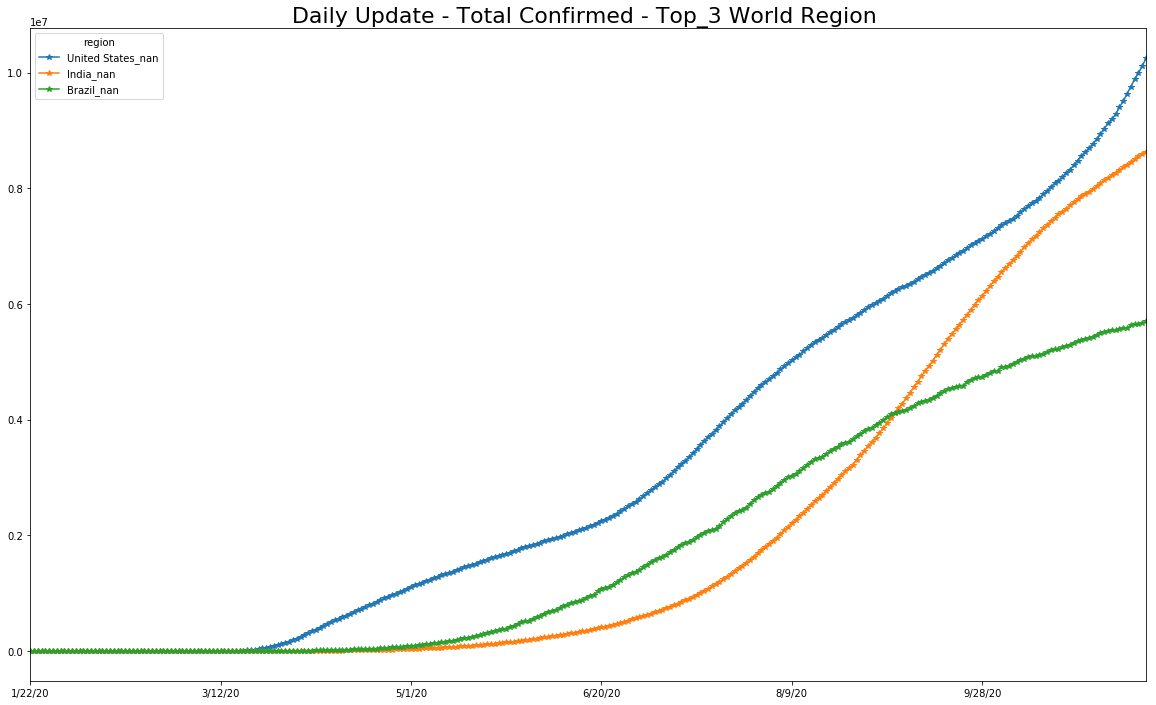

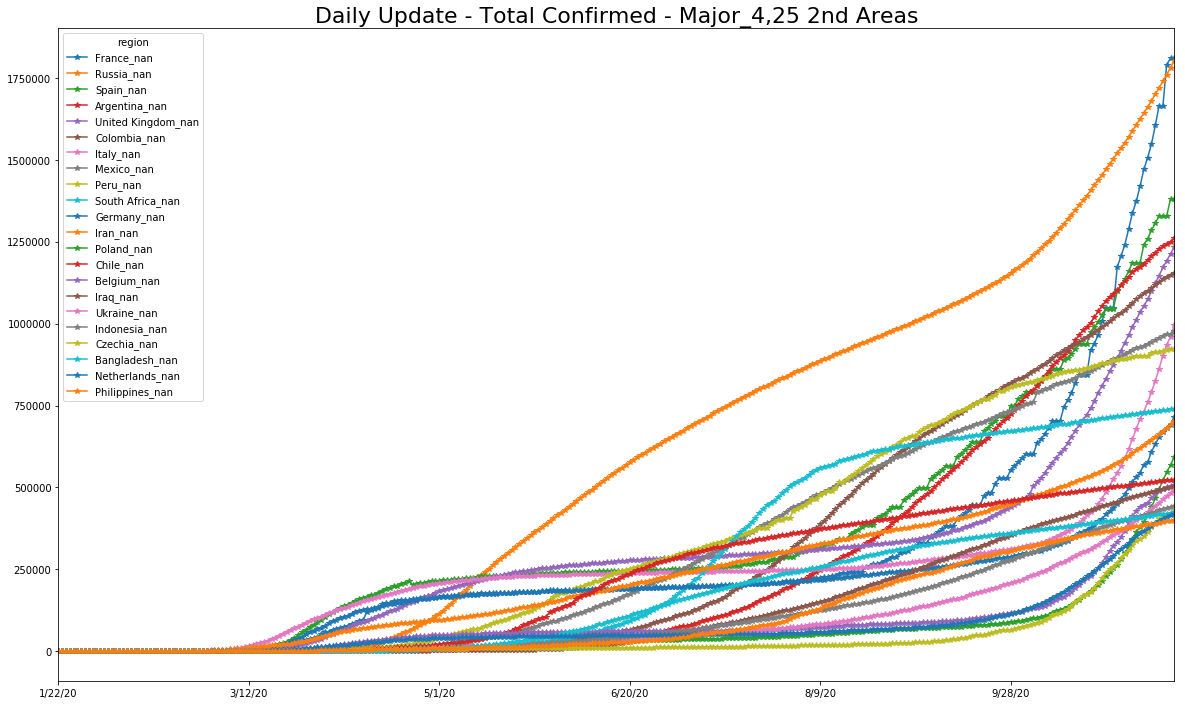

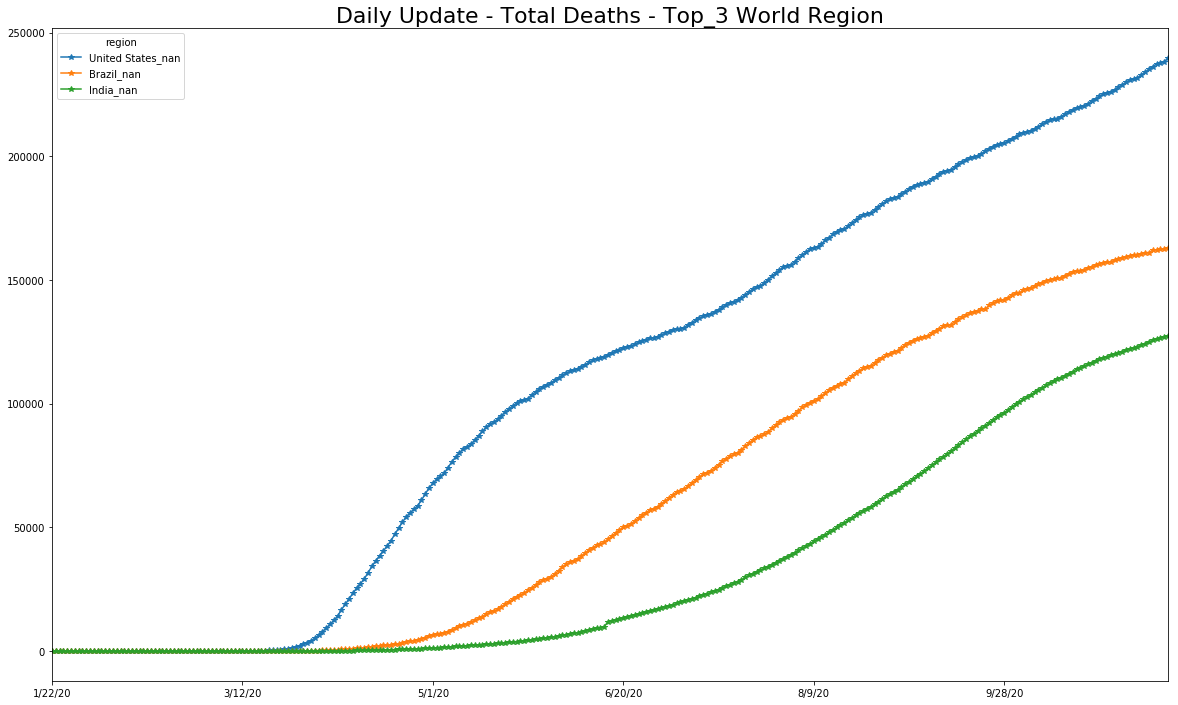

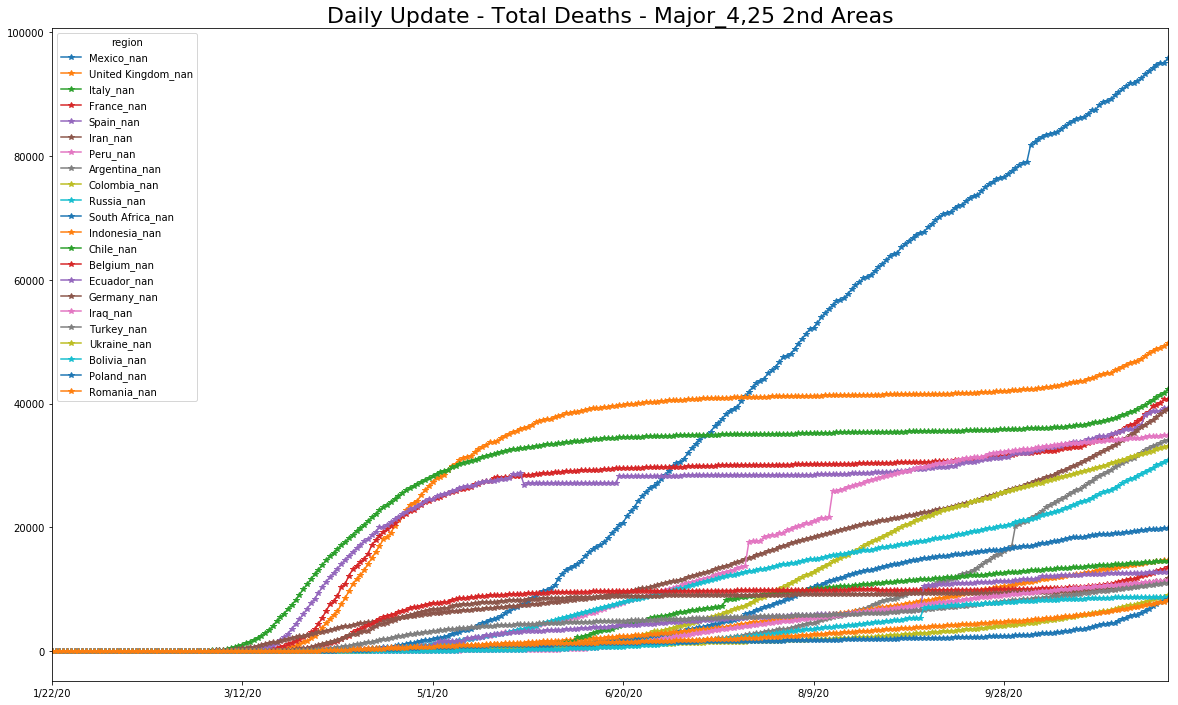

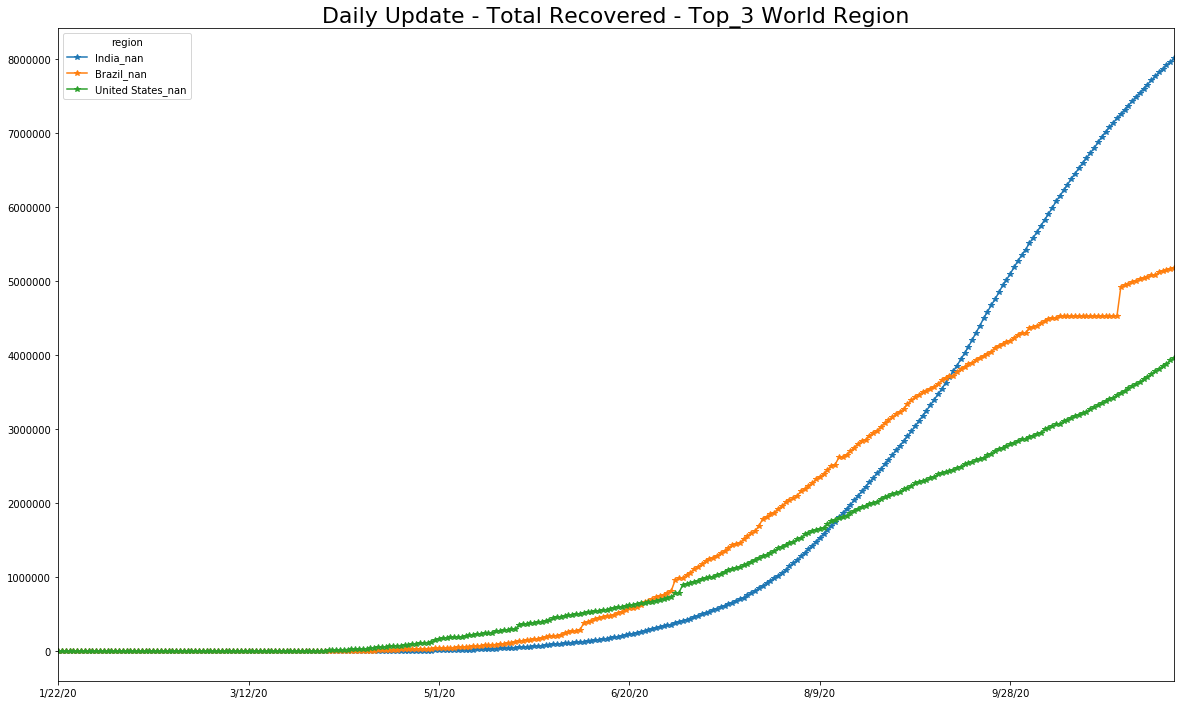

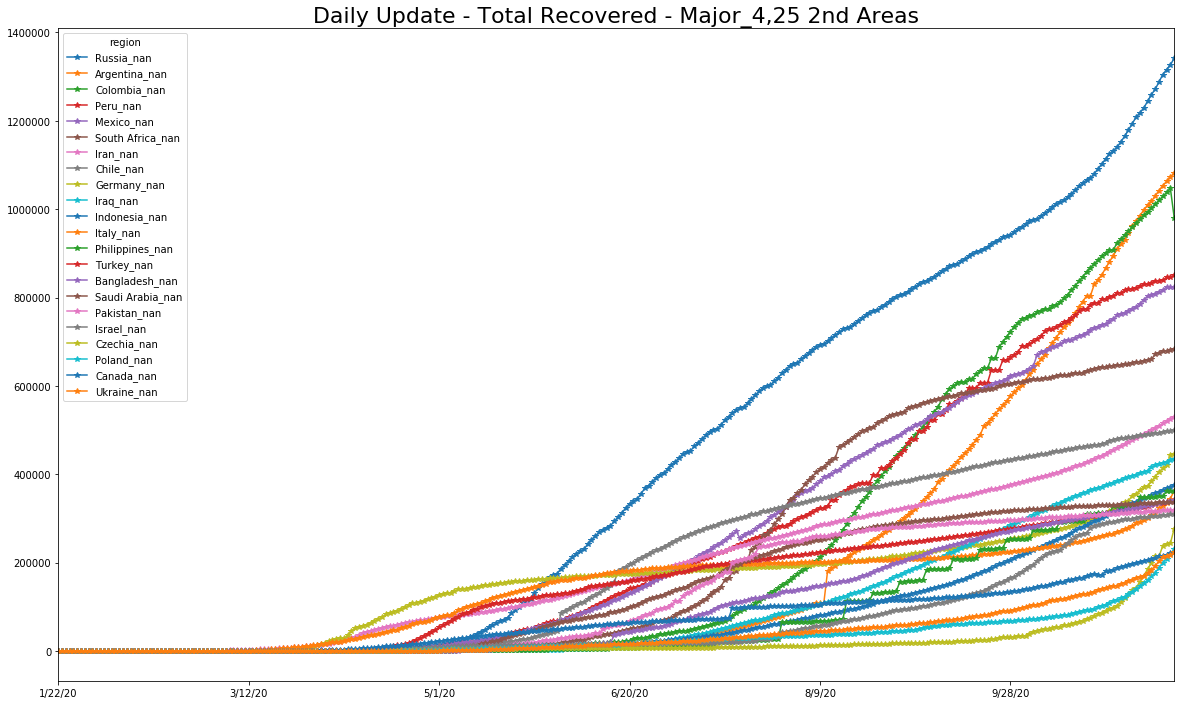

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/11/11


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

date                     region   min   max
0   2020/11/12  Australia_New South Wales  15.8  25.2
1   2020/11/12                Austria_nan  -0.8   1.1
2   2020/11/12                Belgium_nan  10.1  11.4
3   2020/11/12                 Brazil_nan  21.7  22.8
4   2020/11/12             Canada_Ontario  -2.7  -2.6
5   2020/11/12              Canada_Quebec   1.0   1.0
6   2020/11/12                  Chile_nan  12.0  15.0
7   2020/11/12              China_Beijing   0.0  14.0
8   2020/11/12            China_Guangdong  17.0  27.0
9   2020/11/12            China_Hong Kong  20.6  26.1
10  2020/11/12                China_Hubei   9.0  21.6
11  2020/11/12                China_Macau  21.8  24.0
12  2020/11/12             China_Shanghai  11.7  21.2
13  2020/11/12                Finland_nan   0.0   1.0
14  2020/11/12                 France_nan   4.6   9.0
15  2020/11/12                Germany_nan   3.0   5.0
16  2020/11/12                  India_nan  12.0  26.0
17  2020/11/12                   Iran_nan   9.2  17.1
18  2020/11/12                  Italy_nan  10.1  11.3
19  2020/11/12                  Japan_nan  -1.7   5.6
20  2020/11/12           Korea, South_nan   1.9  15.0
21  2020/11/12               Malaysia_nan  20.3  31.0
22  2020/11/12                 Mexico_nan  15.1  15.1
23  2020/11/12            Netherlands_nan  14.4  15.6
24  2020/11/12                 Norway_nan   0.0   0.6
25  2020/11/12                   Peru_nan  23.0  23.2
26  2020/11/12            Philippines_nan  25.0  27.8
27  2020/11/12                 Poland_nan   6.1   6.7
28  2020/11/12               Portugal_nan   8.9  10.6
29  2020/11/12                 Russia_nan  -1.0   1.0
30  2020/11/12              Singapore_nan  25.5  32.0
31  2020/11/12                  Spain_nan   5.7   8.4
32  2020/11/12                 Sweden_nan   6.7   8.3
33  2020/11/12            Switzerland_nan   5.3   6.0
34  2020/11/12                 Turkey_nan   2.3   5.5
35  2020/11/12          United States_nan  -2.2  -2.2
36  2020/11/12         United Kingdom_nan   8.9  10.0

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34994         3752        20770          862         576   
7/16/20            35070         3851        21355          877         607   
7/17/20            35229         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
7/15/20  ...         1009           14581            0          10428   
7/16/20  ...         1026           15066            0          10854   
7/17/20  ...         1037           15607            0          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 269 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/7/20             42033        23705        61381         5319       12335   
11/8/20             42092        24206        62051         5383       12433   
11/9/20             42297        24731        62693         5437       12680   
11/10/20            42463        25294        63446         5477       12816   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/7/20                       131        1236851       104249   
11/8/20                       131        1242182       106424   
11/9/20                       131        1250499       107466   
11/10/20                      131        1262476       108687   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
11/7/20                                      114                       4462   
11/8/20                                      114                       4469   
11/9/20                                      114                       4469   
11/10/20                                     114                       4469   

region    ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
11/7/20   ...         3441           68367            0          94698   
11/8/20   ...         3514           68730            0          94883   
11/9/20   ...         3560           69027            0          95149   
11/10/20  ...         3620           69027            1          95445   

region    Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
11/7/20          1213                   57657                  10       2070   
11/8/20          1213                   58158                  10       2070   
11/9/20          1215                   58838                  10       2071   
11/10/20         1226                   59422                  10       2071   

region    Zambia_nan  Zimbabwe_nan  
11/7/20        16908          8498  
11/8/20        16954          8531  
11/9/20        16971          8561  
11/10/20       16997          8610  

[4 rows x 269 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
7195 2020-05-10  Vietnam_nan  26.9  33.0
7196 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35070             0             0   
2     2020-07-17  Afghanistan_nan      35229            76             0   
3     2020-07-18  Afghanistan_nan      35301           159             0   
4     2020-07-19  Afghanistan_nan      35475            72           307   
5     2020-07-20  Afghanistan_nan      35526           174           405   
6     2020-07-21  Afghanistan_nan      35615            51           297   
7     2020-07-22  Afghanistan_nan      35727            89           314   
8     2020-07-23  Afghanistan_nan      35928           112           252   
9     2020-07-24  Afghanistan_nan      35981           201           402   
10    2020-07-25  Afghanistan_nan      36036            53           366   
11    2020-07-26  Afghanistan_nan      36157            55           309   
12    2020-07-27  Afghanistan_nan      36263           121           229   
13    2020-07-28  Afghanistan_nan      36368           106           282   
14    2020-07-29  Afghanistan_nan      36471           105           332   
15    2020-07-30  Afghanistan_nan      36542           103           314   
16    2020-07-31  Afghanistan_nan      36675            71           279   
17    2020-08-01  Afghanistan_nan      36710           133           307   
18    2020-08-02  Afghanistan_nan      36710            35           239   
19    2020-08-03  Afghanistan_nan      36747             0           168   
20    2020-08-04  Afghanistan_nan      36782            37            72   
21    2020-08-05  Afghanistan_nan      36829            35            72   
22    2020-08-06  Afghanistan_nan      36896            47           119   
23    2020-08-07  Afghanistan_nan      37015            67           149   
24    2020-08-08  Afghanistan_nan      37054           119           233   
25    2020-08-09  Afghanistan_nan      37054            39           225   
26    2020-08-10  Afghanistan_nan      37162             0           158   
27    2020-08-11  Afghanistan_nan      37269           108           147   
28    2020-08-12  Afghanistan_nan      37345           107           215   
29    2020-08-13  Afghanistan_nan      37424            76           291   
30    2020-08-14  Afghanistan_nan      37431            79           262   
...          ...              ...        ...           ...           ...   
32970 2020-10-13     Zimbabwe_nan       8036            10            27   
32971 2020-10-14     Zimbabwe_nan       8055            15            26   
32972 2020-10-15     Zimbabwe_nan       8075            19            44   
32973 2020-10-16     Zimbabwe_nan       8099            20            54   
32974 2020-10-17     Zimbabwe_nan       8110            24            63   
32975 2020-10-18     Zimbabwe_nan       8147            11            55   
32976 2020-10-19     Zimbabwe_nan       8159            37            72   
32977 2020-10-20     Zimbabwe_nan       8187            12            60   
32978 2020-10-21     Zimbabwe_nan       8215            28            77   
32979 2020-10-22     Zimbabwe_nan       8242            28            68   
32980 2020-10-23     Zimbabwe_nan       8257            27            83   
32981 2020-10-24     Zimbabwe_nan       8269            15            70   
32982 2020-10-25     Zimbabwe_nan       8276            12            54   
32983 2020-10-26     Zimbabwe_nan       8303             7            34   
32984 2020-10-27     Zimbabwe_nan       8315            27            46   
32985 2020-10-28     Zimbabwe_nan       8320            12            46   
32986 2020-10-29     Zimbabwe_nan       8349             5            44   
32987 2020-10-30     Zimbabwe_nan       8362            29            46   
32988 2020-10-31     Zimbabwe_nan       8367            13            47   
32989 2020-11-01     Zimbabwe_nan       8374             5            47   
32990 2020-11-02     Zimbabwe_nan       8389             7  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
32999 2020-11-11  Zimbabwe_nan          0            49           112   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32999           200          100.57248         101.318075          102.37824   

       last_day  kalman_prediction  population  infected_rate  min  max  
32999      8610             8624.0    14862924       0.000006  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
32999 2020-11-11  Zimbabwe_nan          0            49           112   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32999           200          100.57248         101.318075          102.37824   

       last_day  kalman_prediction  population  infected_rate  min  max  
32999      8610             8624.0    14862924       0.000006  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
32277  2020-11-09  Zimbabwe_nan       8561            33            87   
32278  2020-11-10  Zimbabwe_nan       8610            30            90   
32279  2020-11-11  Zimbabwe_nan          0            49           112   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
32277           157         100.388444         101.030436         101.874970   
32278           172         100.351776         101.062566         102.050423   
32279           200         100.572480         101.318075         102.378240   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
32277                 8531  ...    14862924       0.000006  NaN  NaN   
32278                 8561  ...    14862924       0.000006  NaN  NaN   
32279                 8610  ...    14862924       0.000006  NaN  NaN   

       population_percentage : infected_rate confirmed  \
32277                                         0.000574   
32278                                         0.000576   
32279                                         0.000579   

       population_percentage : factor 9/10 infected_rate confirmed  \
32277                                           0.005740             
32278                                           0.005761             
32279                                           0.005794             

       delta : new_cases  delta : new_cases per 1M hab  \
32277               11.0                      0.740097   
32278               16.0                      1.076504   
32279               14.0                      0.941941   

       delta : roling 7day AVG  \
32277                22.428571   
32278                24.571429   
32279                28.571429   

       delta : aprox 14-day case notification rate per 100k hab  
32277                                           2.112639         
32278                                           2.314484         
32279                                           2.691260         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse           rmse            mae
258  United States_nan  9.048731e+11  951248.191609  103256.781513


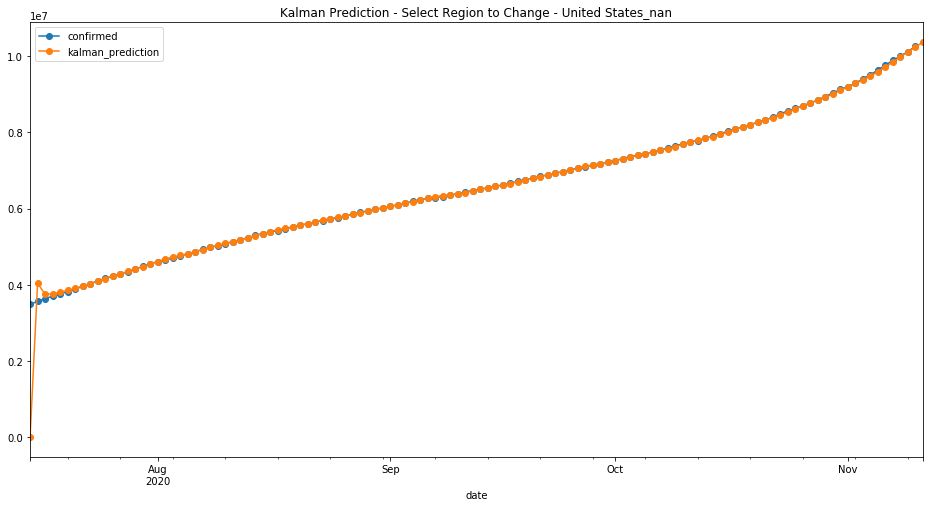

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse          mae
209  Russia_nan  2.801440e+10  167375.022415  17704.87395


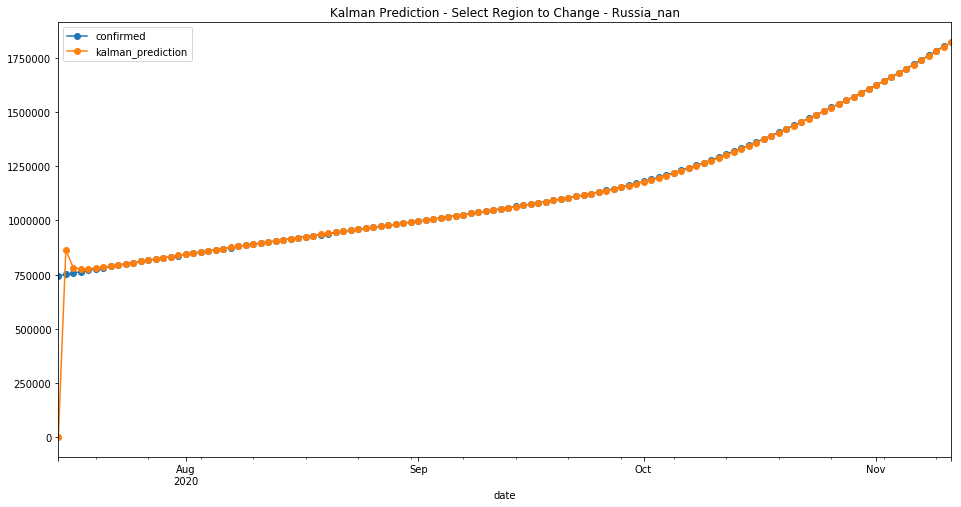

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  2.754870e+11  524868.532803  65569.613445


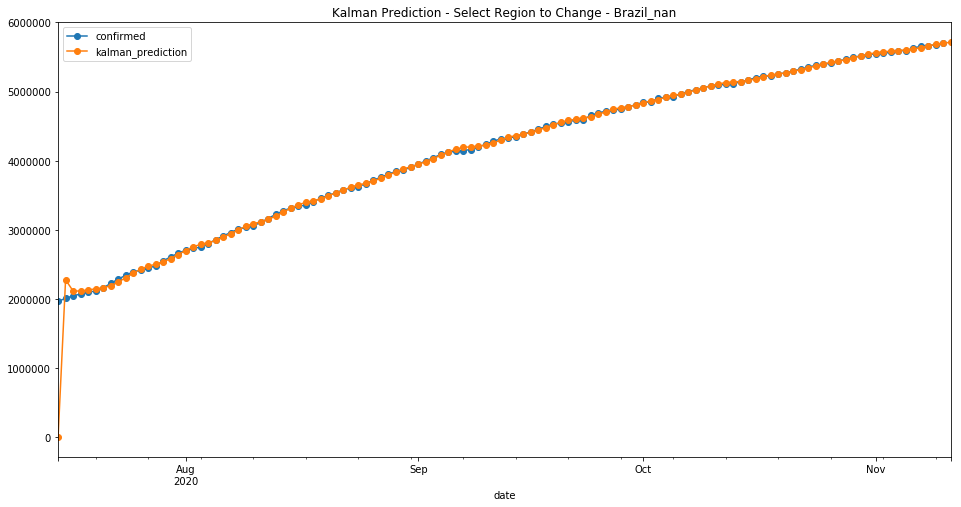

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse           mae
257  United Kingdom_nan  1.332566e+10  115436.82763  12783.176471


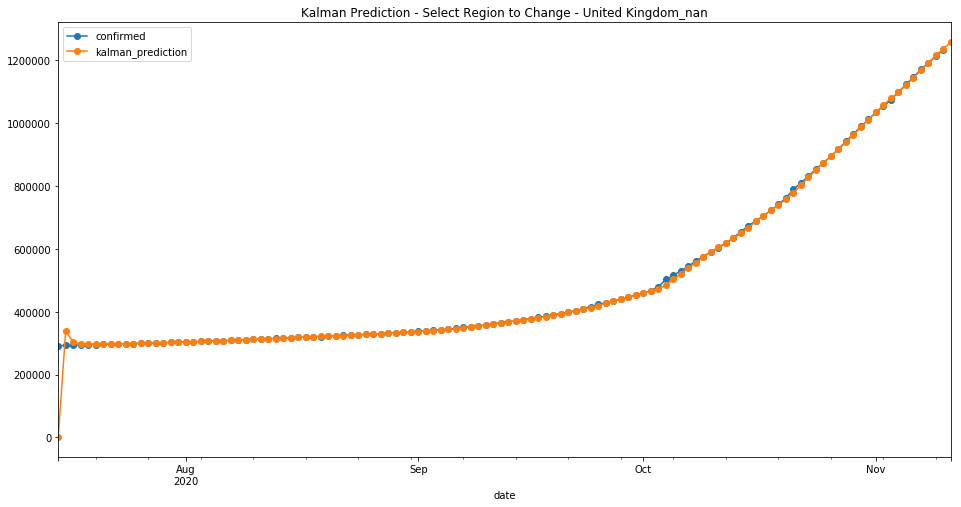

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9" 2020-10-20; OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpp56a296p
  JVM stdout: /tmp/tmpp56a296p/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpp56a296p/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    1 month and 13 days
H2O_cluster_name:           H2O_from_python_unknownUser_6su8zy
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-11-03
last_train_date= 2020-11-10
first_bootstrap_date= 2020-11-02
boost_bootstrap_date= 2020-11-07
first_test_date= 2020-11-01
last_test_date= 2020-11-11
first_valid_date= 2020-11-09


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   41711.0      41633 2020-11-02  Afghanistan_nan
1   41809.0      41728 2020-11-03  Afghanistan_nan
2   41922.0      41814 2020-11-04  Afghanistan_nan
3   42018.0      41935 2020-11-05  Afghanistan_nan
4   42118.0      41975 2020-11-06  Afghanistan_nan
5   42205.0      42033 2020-11-07  Afghanistan_nan
6   42253.0      42092 2020-11-08  Afghanistan_nan
7   42300.0      42297 2020-11-09  Afghanistan_nan
8   42412.0      42463 2020-11-10  Afghanistan_nan
9   42599.0          0 2020-11-11  Afghanistan_nan
10  21440.0      21523 2020-11-02      Albania_nan
11  21761.0      21904 2020-11-03      Albania_nan
12  22099.0      22300 2020-11-04      Albania_nan
13  22496.0      22721 2020-11-05      Albania_nan
14  22925.0      23210 2020-11-06      Albania_nan
15  23390.0      23705 2020-11-07      Albania_nan
16  23927.0      24206 2020-11-08      Albania_nan
17  24475.0      24731 2020-11-09      Albania_nan
18  25030.0      25294 2020-11-10      Albania_nan
19  25608.0          0 2020-11-11      Albania_nan
20  58641.0      58574 2020-11-02      Algeria_nan
21  58962.0      58979 2020-11-03      Algeria_nan
22  59326.0      59527 2020-11-04      Algeria_nan
23  59816.0      60169 2020-11-05      Algeria_nan
24  60447.0      60800 2020-11-06      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  63243.0      63748 2020-11-07  Azerbaijan_nan
176  64783.0      65411 2020-11-08  Azerbaijan_nan
177  66448.0      66046 2020-11-09  Azerbaijan_nan
178  67668.0      67392 2020-11-10  Azerbaijan_nan
179  68769.0          0 2020-11-11  Azerbaijan_nan
180   6958.0       6735 2020-11-02     Bahamas_nan
181   6926.0       6790 2020-11-03     Bahamas_nan
182   6885.0       6843 2020-11-04     Bahamas_nan
183   6939.0       6882 2020-11-05     Bahamas_nan
184   7010.0       6882 2020-11-06     Bahamas_nan
185   7095.0       6947 2020-11-07     Bahamas_nan
186   7009.0       6947 2020-11-08     Bahamas_nan
187   7152.0       6964 2020-11-09     Bahamas_nan
188   7133.0       7012 2020-11-10     Bahamas_nan
189   7102.0          0 2020-11-11     Bahamas_nan
190  81776.0      82133 2020-11-02     Bahrain_nan
191  81989.0      82363 2020-11-03     Bahrain_nan
192  82204.0      82624 2020-11-04     Bahrain_nan
193  82443.0      82786 2020-11-05     Bahrain_nan
194  82643.0      83023 2020-11-06     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  100382.0     100400 2020-11-02  Belarus_nan
221  101366.0     101329 2020-11-03  Belarus_nan
222  102317.0     102313 2020-11-04  Belarus_nan
223  103283.0     103295 2020-11-05  Belarus_nan
224  104262.0     104286 2020-11-06  Belarus_nan
225  105250.0     105283 2020-11-07  Belarus_nan
226  106248.0     106279 2020-11-08  Belarus_nan
227  107249.0     107262 2020-11-09  Belarus_nan
228  108243.0     108300 2020-11-10  Belarus_nan
229  109267.0          0 2020-11-11  Belarus_nan
230  462855.0     447355 2020-11-02  Belgium_nan
231  470800.0     452541 2020-11-03  Belgium_nan
232  474746.0     468213 2020-11-04  Belgium_nan
233  483959.0     479341 2020-11-05  Belgium_nan
234  493483.0     488044 2020-11-06  Belgium_nan
235  501473.0     494168 2020-11-07  Belgium_nan
236  507263.0     500789 2020-11-08  Belgium_nan
237  512685.0     503182 2020-11-09  Belgium_nan
238  515042.0     507475 2020-11-10  Belgium_nan
239  517431.0          0 2020-11-11  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2219793240.62354
# MSE on the validation data =  1985306428266.9346
# R^2 on the training data =  0.9991302481945589
# R^2 on the validation data =  0.4432221841923162


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1605074529363_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           15586132.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.908      2216.0      2543.0     2436.814



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2219793240.62354
RMSE: 47114.68179478176
MAE: 4198.438026747882
RMSLE: 0.21298393991523176
Mean Residual Deviance: 2219793240.62354

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 1985306428266.9346
RMSE: 1409009.0234866966
MAE: 356965.83229543583
RMSLE: 7.03620809416235
Mean Residual Deviance: 1985306428266.9346

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-11-11 06:02:18   0.122 sec              0.0            NaN   
1     2020-11-11 06:02:18   0.573 sec              1.0  117576.822314   
2     2020-11-11 06:02:19   0.767 sec              2.0   96713.230217   
3     2020-11-11 06:02:19   0.890 sec              3.0   82908.195344   
4     2020-11-11 06:02:19   1.264 sec              4.0   77275.349823   
5     2020-11-11 06:02:19   1.504 sec              5.0   73189.472380   
6     2020-11-11 06:02:19   1.586 sec              6.0   69819.570675   
7     2020-11-11 06:02:19   1.671 sec              7.0   69657.389038   
8     2020-11-11 06:02:20   1.815 sec              8.0   66627.191385   
9     2020-11-11 06:02:20   1.874 sec              9.0   59489.291494   
10    2020-11-11 06:02:20   1.930 sec             10.0   59434.044200   
11    2020-11-11 06:02:20   2.194 sec             11.0   58670.115887   
12    2020-11-11 06:02:20   2.530 sec             12.0   55483.976986   
13    2020-11-11 06:02:21   2.737 sec             13.0   56883.052455   
14    2020-11-11 06:02:21   2.889 sec             14.0   54830.555793   
15    2020-11-11 06:02:21   2.991 sec             15.0   53539.550927   
16    2020-11-11 06:02:21   3.142 sec             16.0   55424.102137   
17    2020-11-11 06:02:21   3.337 sec             17.0   53687.593526   
18    2020-11-11 06:02:21   3.486 sec             18.0   55734.124449   
19    2020-11-11 06:02:22   3.733 sec             19.0   54519.571354   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   18395.120669       1.382431e+10     1.419982e+06   363447.019918   
2   15280.708662       9.353449e+09     1.386914e+06   358639.442937   
3   12711.722166       6.873769e+09     1.394732e+06   357365.795514   
4   11719.958886       5.971480e+09     1.391113e+06   356161.852627   
5   11036.373994       5.356699e+09     1.394748e+06   356147.331813   
6   10258.240714       4.874772e+09     1.418865e+06   360829.146904   
7    9693.747683       4.852152e+09     1.416171e+06   359896.888229   
8    8814.655246       4.439183e+09     1.417583e+06   359399.751661   
9    8185.560613       3.538976e+09     1.414659e+06   358812.866064   
10   8047.928474       3.532406e+09     1.413997e+06   358377.074070   
11   7742.503571       3.442182e+09     1.414285e+06   358171.038057   
12   7359.702913       3.078472e+09     1.413654e+06   357792.569945   
13   7445.219837       3.235682e+09     1.413414e+06   357772.949770   
14   7126.300399       3.006390e+09     1.413330e+06   357713.894982   
15   7027.575031       2.866484e+09     1.408612e+06   357400.214399   
16   7147.588350       3.071831e+09     1.407401e+06   357434.844907   
17   7000.572227       2.882358e+09     1.408876e+06   357244.953464   
18   6900.616268       3.106293e+09     1.408488e+06   357098.285148   
19   6713.375187       2.972384e+09     1.407889e+06   357194.599966   

    validation_deviance  
0                   NaN  
1          2.016349e+12  
2          1.923530e+12  
3          1.945278e+12  
4          1.935196e+12  
5          1.945322e+12  
6          2.013177e+12  
7          2.005539e+12  
8          2.009541e+12  
9          2.001261e+12  
10         1.999388e+12  
11         2.000203e+12  
12         1.998419e+12  
13         1.997740e+12  
14         1.997502e+12  
15         1.984187e+12  
16         1.980779e+12  
17         1.984931e+12  
18         1.983839e+12  
19         1.982151e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.008851e+18           1.000000    0.350063
1            last_day         1.524014e+18           0.758650    0.265575
2              region         1.067046e+18           0.531172    0.185944
3        7_day_change         4.981783e+17           0.247992    0.086813
4        1_day_change         3.037638e+17           0.151213    0.052934
5        3_day_change         1.921931e+17           0.095673    0.033492
6       infected_rate         4.757265e+16           0.023682    0.008290
7   7_day_change_rate         3.368936e+16           0.016770    0.005871
8   1_day_change_rate         2.856741e+16           0.014221    0.004978
9   3_day_change_rate         2.672742e+16           0.013305    0.004658
10                max         4.974468e+15           0.002476    0.000867
11                min         2.957335e+15           0.001472    0.000515

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         2.008851e+18           1.000000    0.350063
1            last_day         1.524014e+18           0.758650    0.265575
2              region         1.067046e+18           0.531172    0.185944
3        7_day_change         4.981783e+17           0.247992    0.086813
4        1_day_change         3.037638e+17           0.151213    0.052934
5        3_day_change         1.921931e+17           0.095673    0.033492
6       infected_rate         4.757265e+16           0.023682    0.008290
7   7_day_change_rate         3.368936e+16           0.016770    0.005871
8   1_day_change_rate         2.856741e+16           0.014221    0.004978
9   3_day_change_rate         2.672742e+16           0.013305    0.004658
10                max         4.974468e+15           0.002476    0.000867
11                min         2.957335e+15           0.001472    0.000515

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


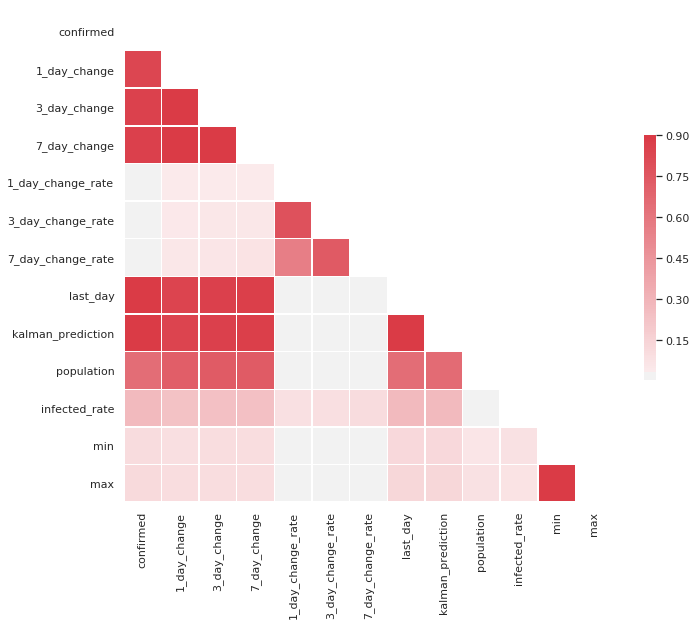

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.835447
3_day_change         0.857060
7_day_change         0.864472
1_day_change_rate    0.023532
3_day_change_rate    0.025482
7_day_change_rate    0.027185
last_day             0.988160
kalman_prediction    0.989020
population           0.650375
infected_rate        0.269945
min                  0.107948
max                  0.115161
Name: confirmed, dtype: float64


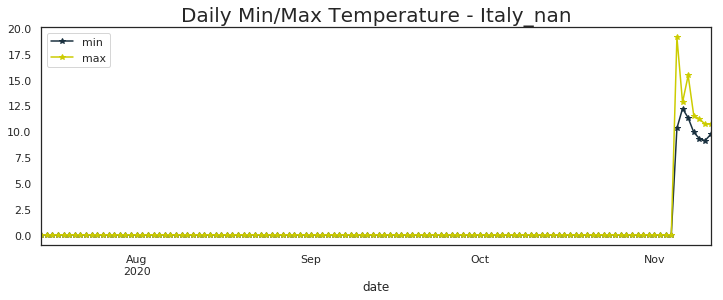

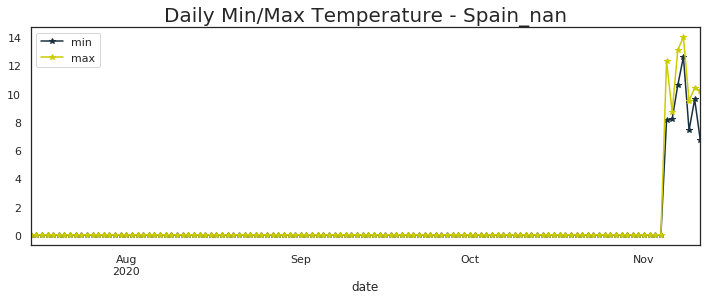

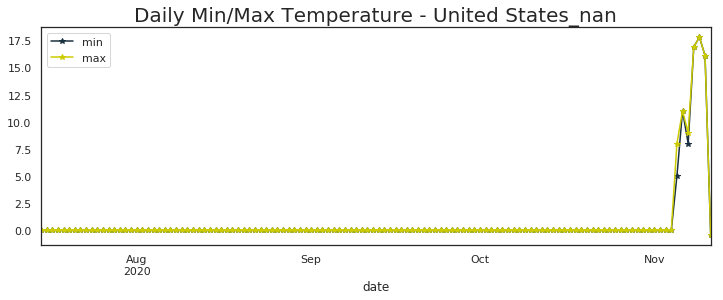

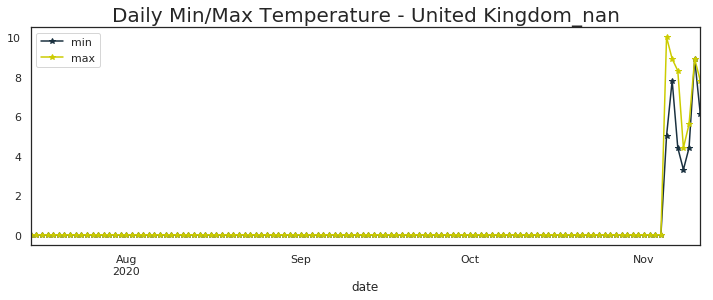

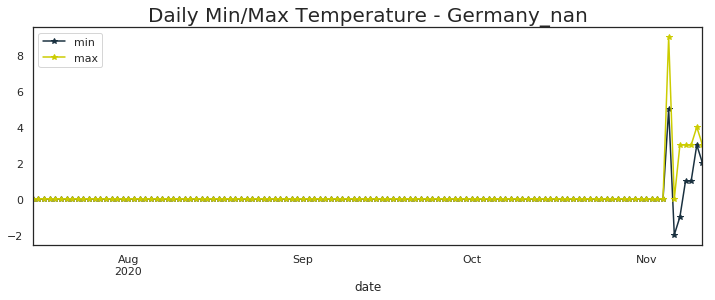

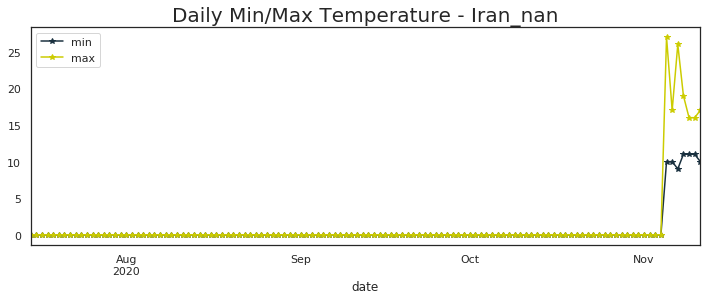

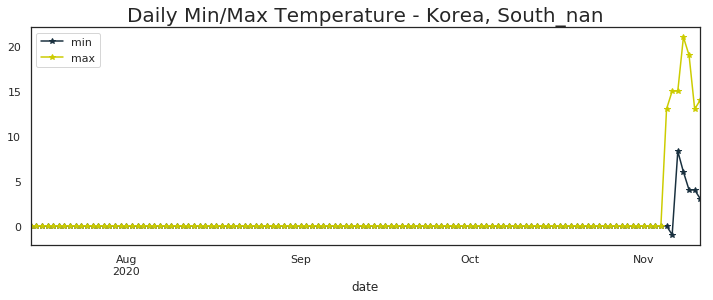

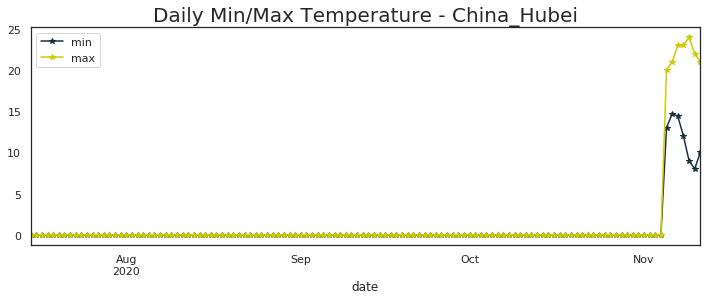

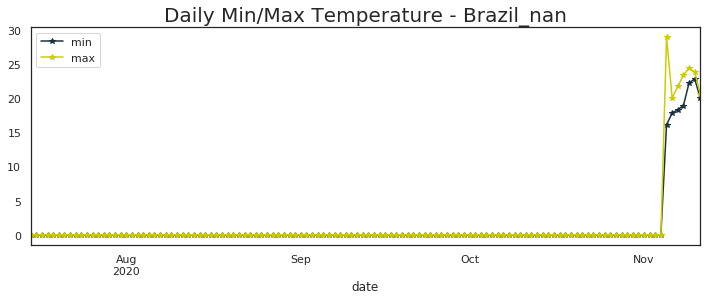

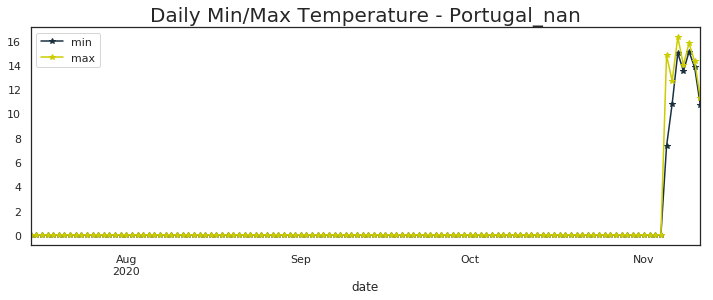

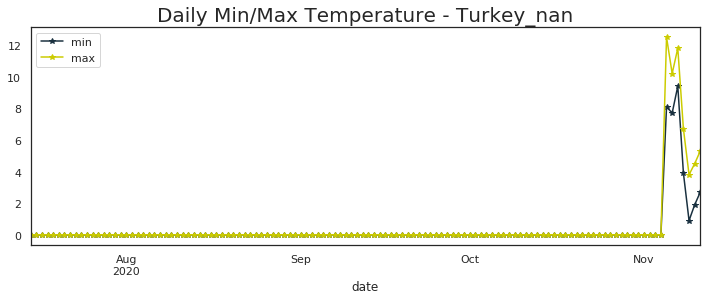

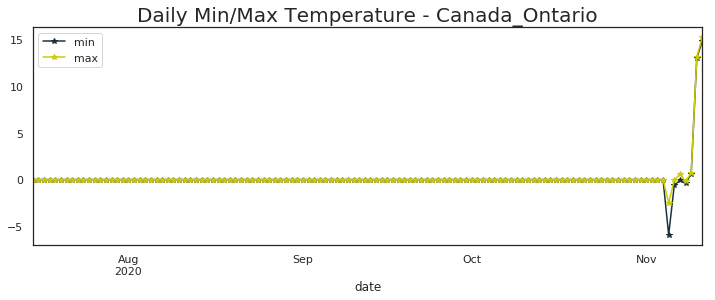

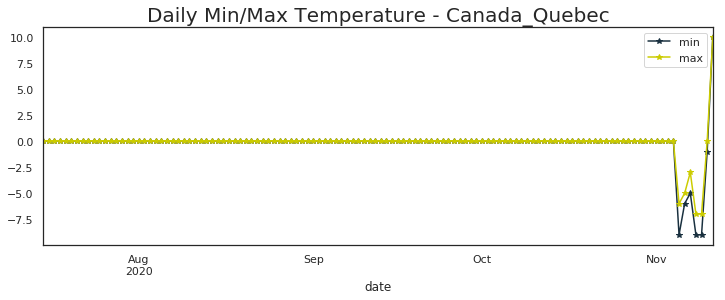

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   14.0  31.0
Brazil_nan                  22.8  28.9
France_nan                  12.1  13.3
Russia_nan                   0.0   4.0
Spain_nan                   12.6  14.0
Argentina_nan                0.0   0.0
United Kingdom_nan           8.9  10.0
Colombia_nan                 0.0   0.0
Italy_nan                   12.2  19.1
Mexico_nan                  14.8  14.8
Peru_nan                    24.6  29.9
South Africa_nan             0.0   0.0
Germany_nan                  5.0   9.0
Iran_nan                    11.0  27.0
Poland_nan                   8.9  10.6
Chile_nan                   17.0  22.0
Belgium_nan                 11.9  13.4
Iraq_nan                     0.0   0.0
Ukraine_nan                  0.0   0.0
Indonesia_nan                0.0   0.0
Czechia_nan                  0.0   0.0
Bangladesh_nan              

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

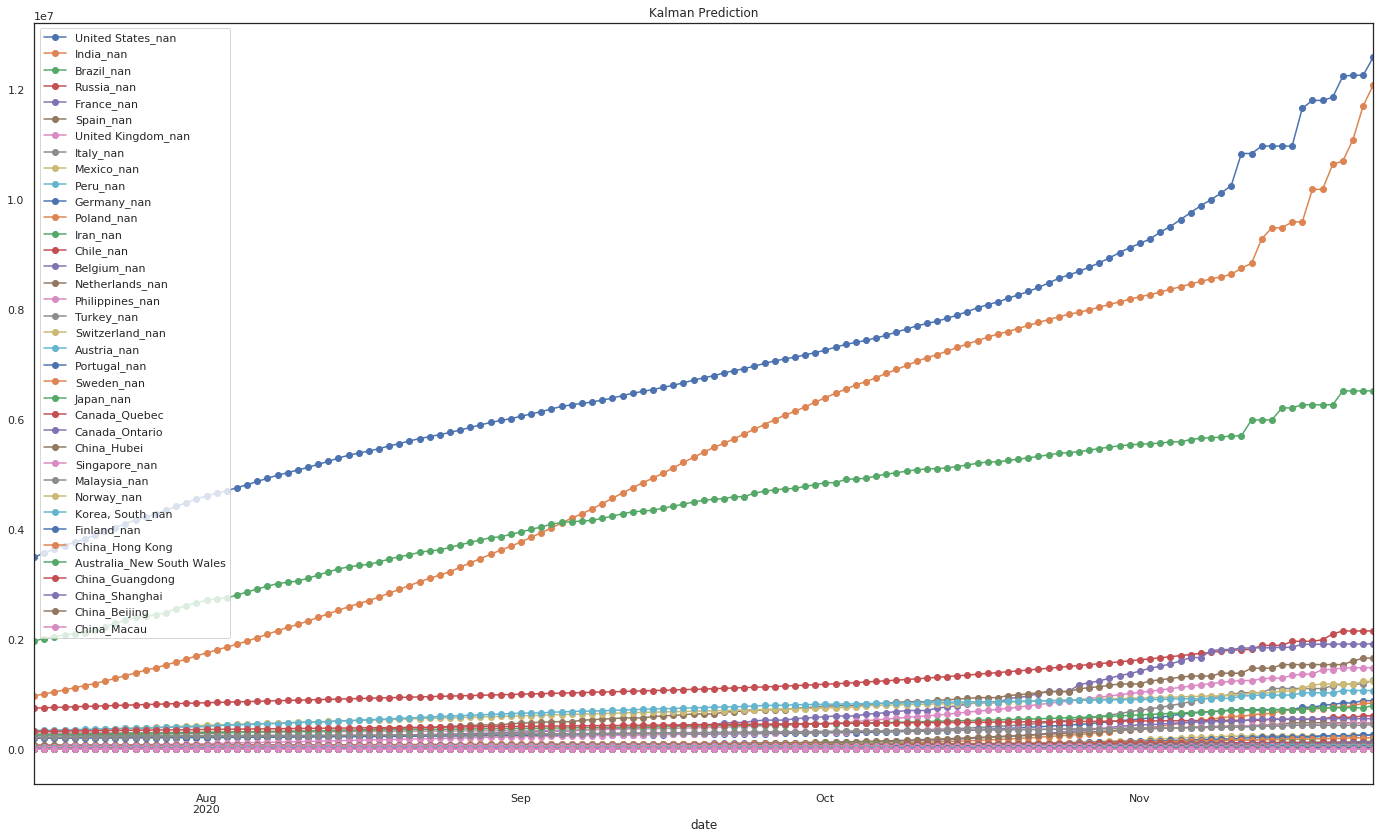

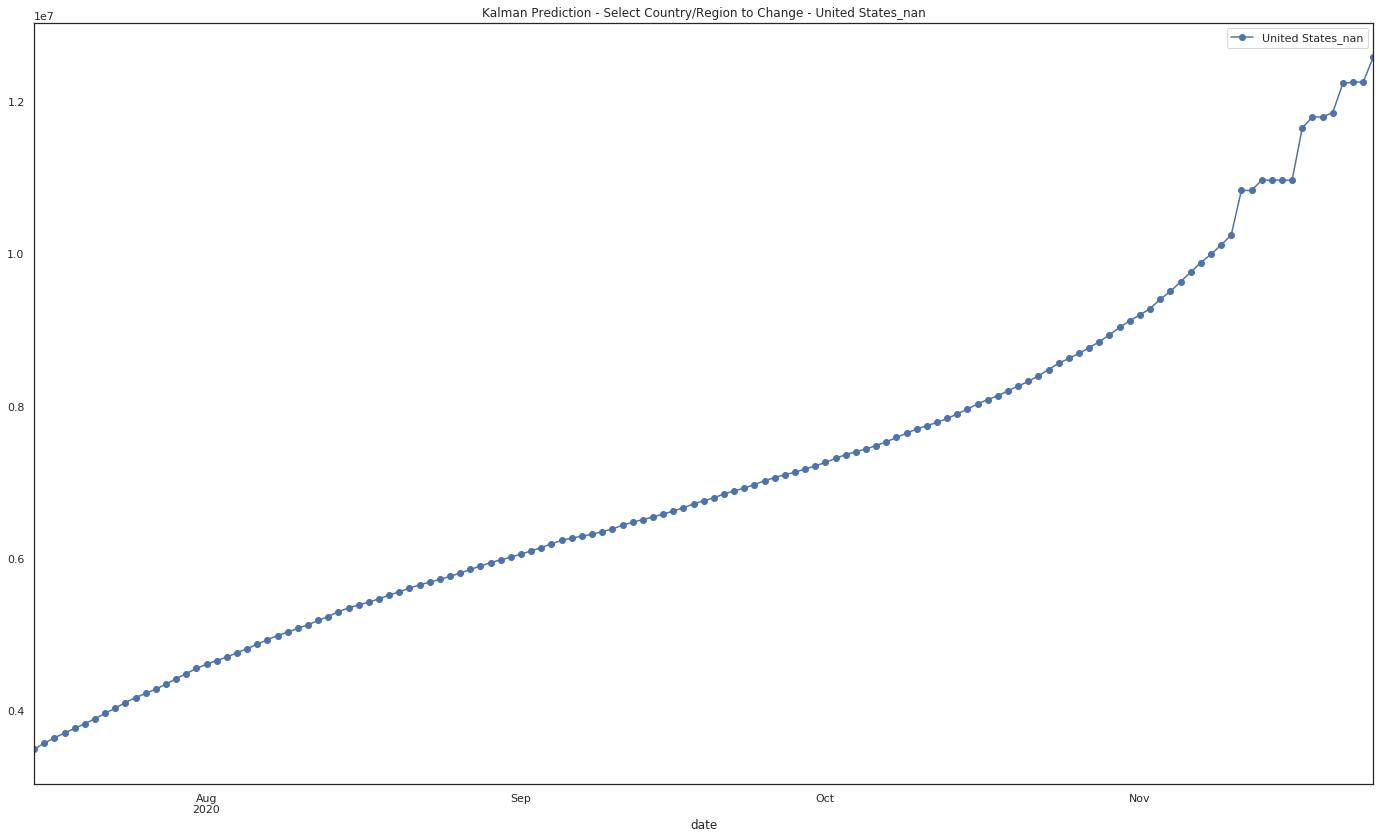

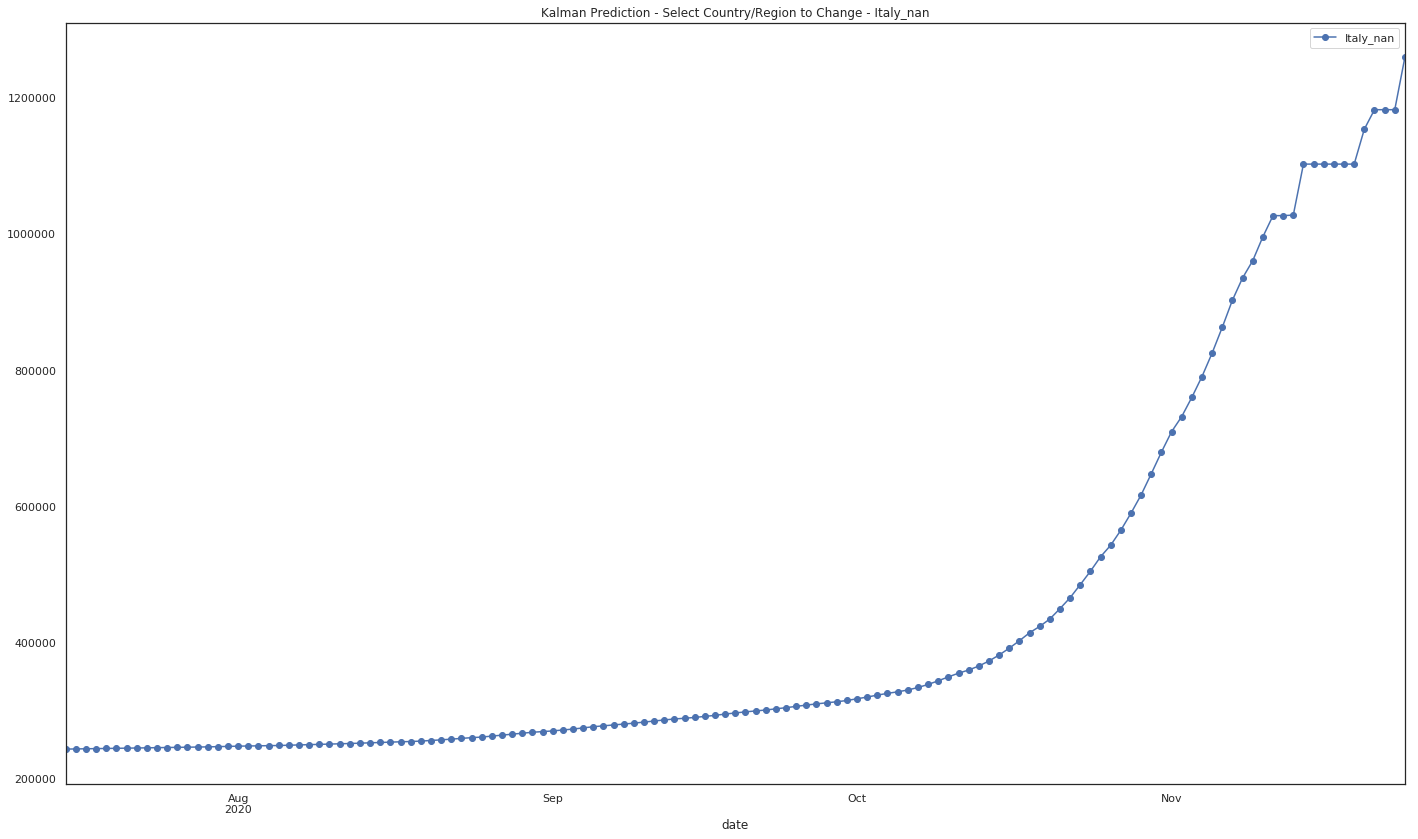

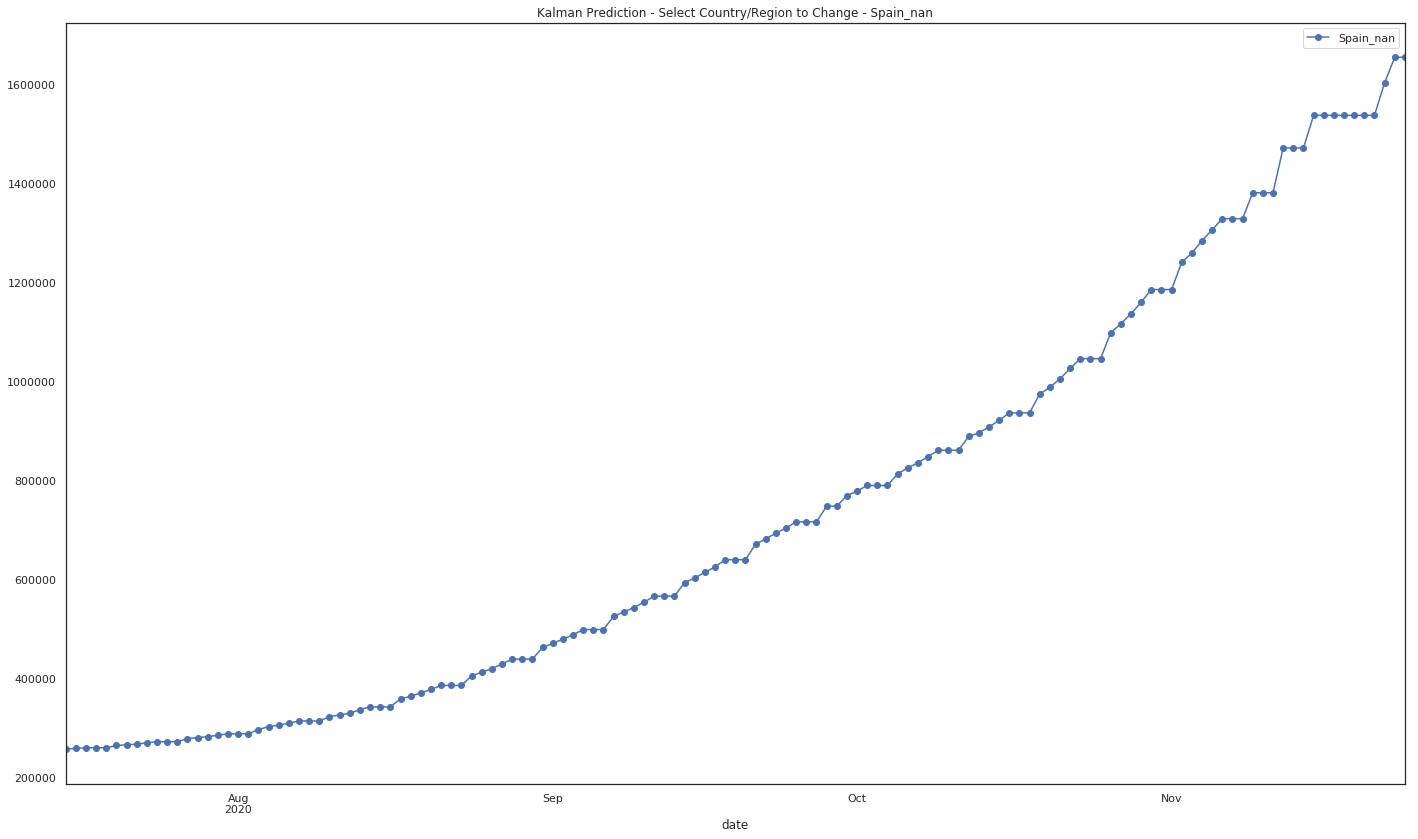

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


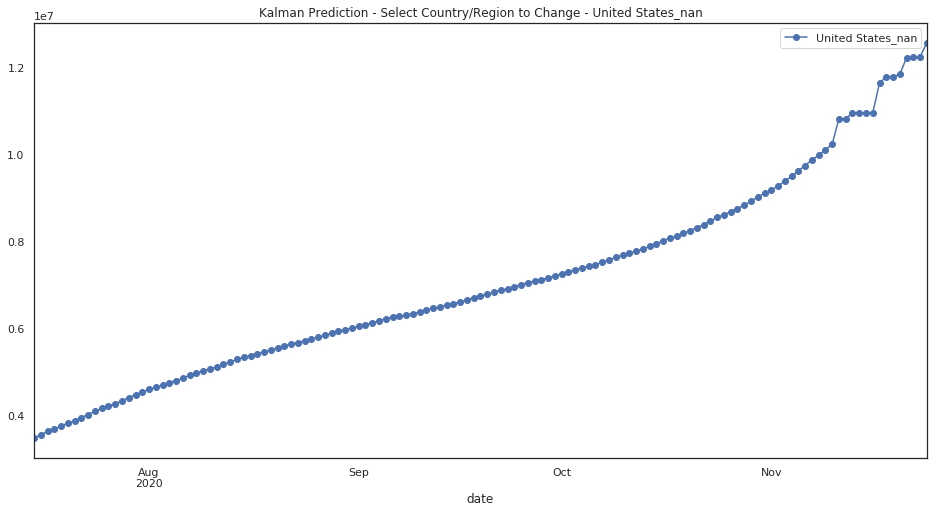

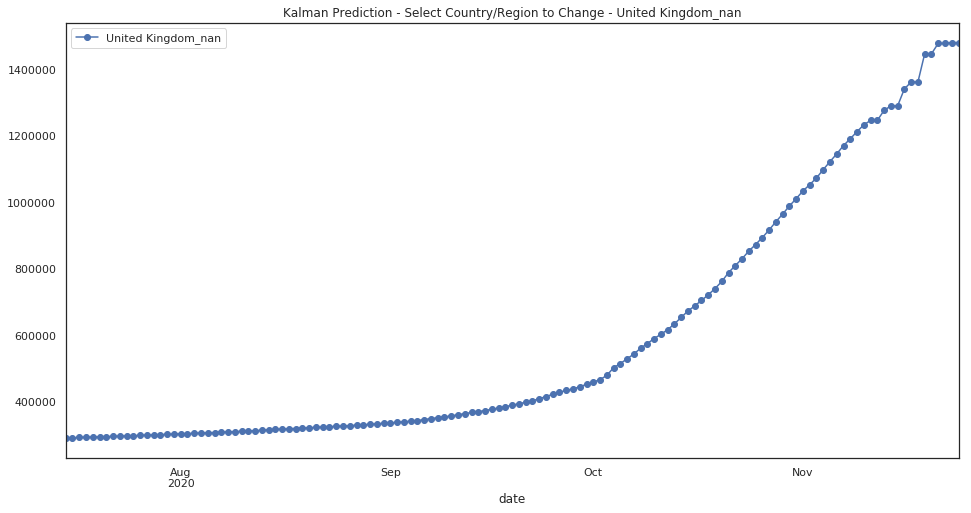

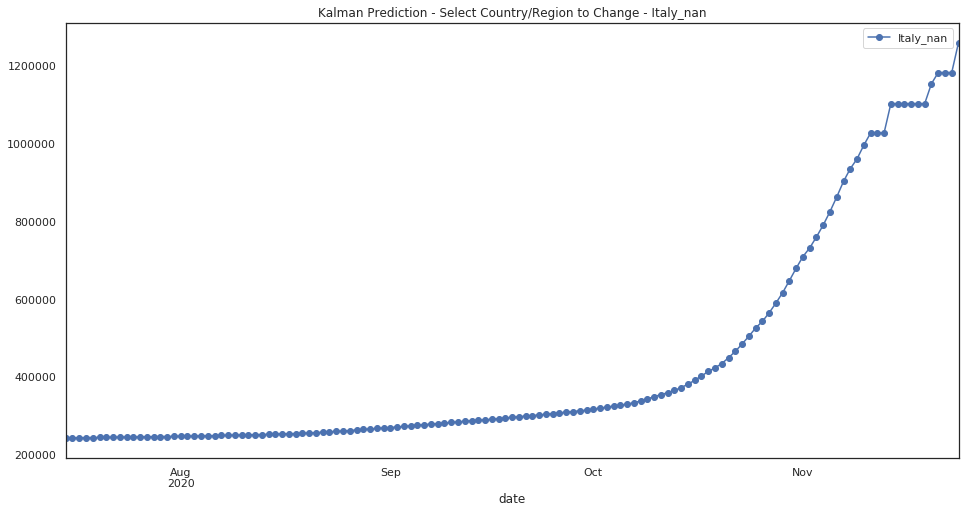

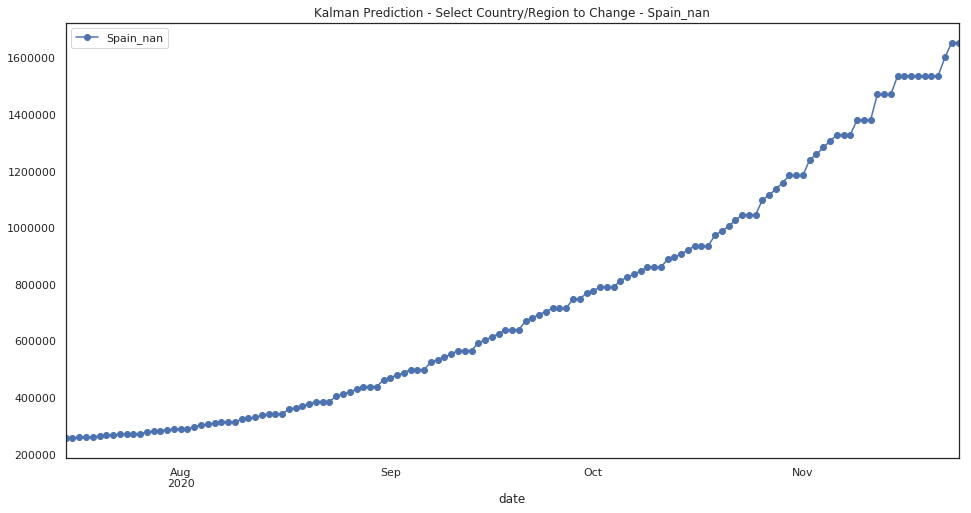

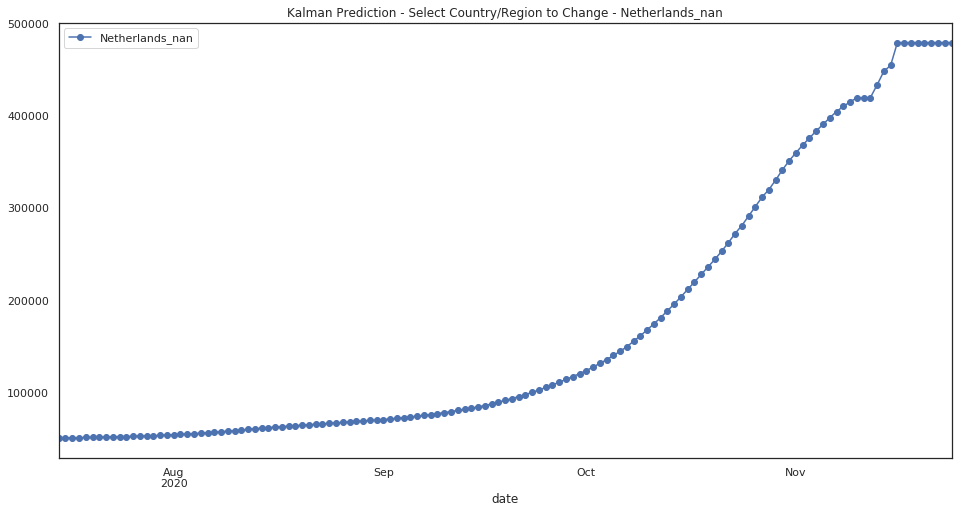

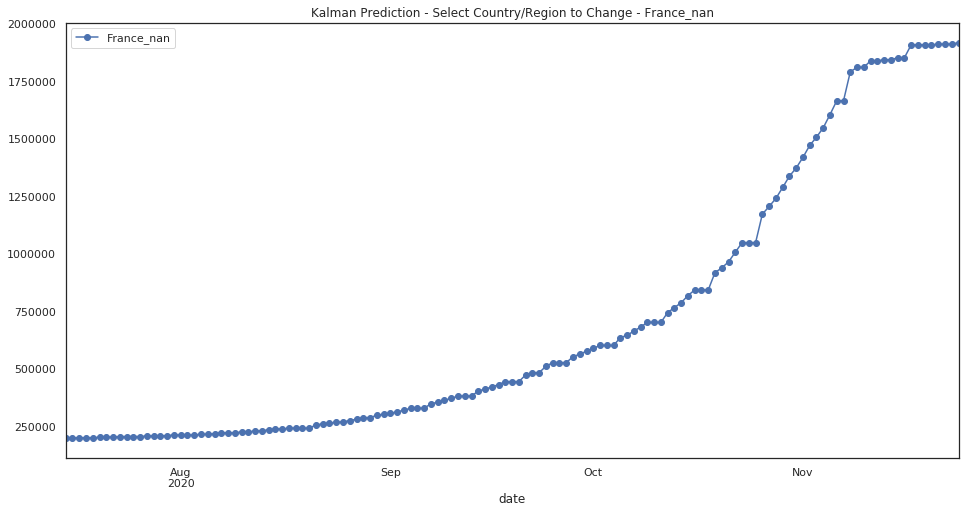

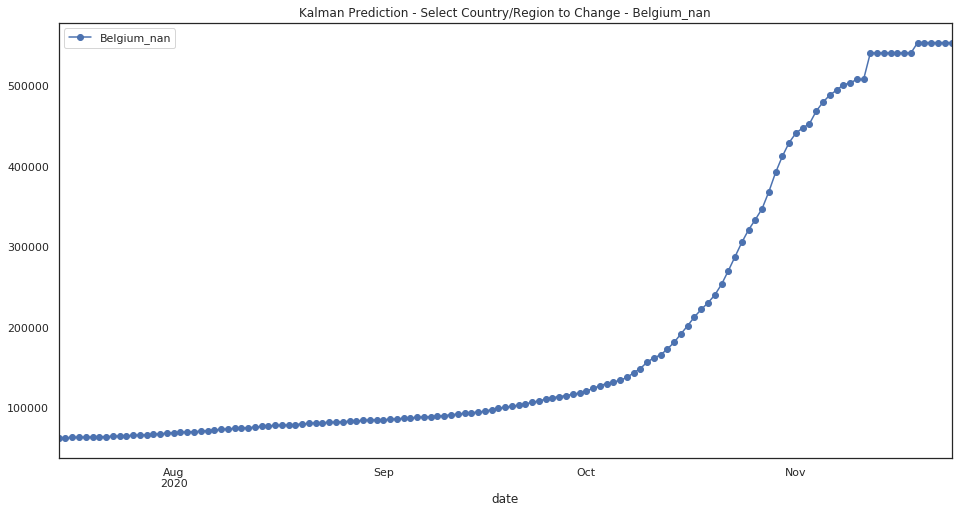

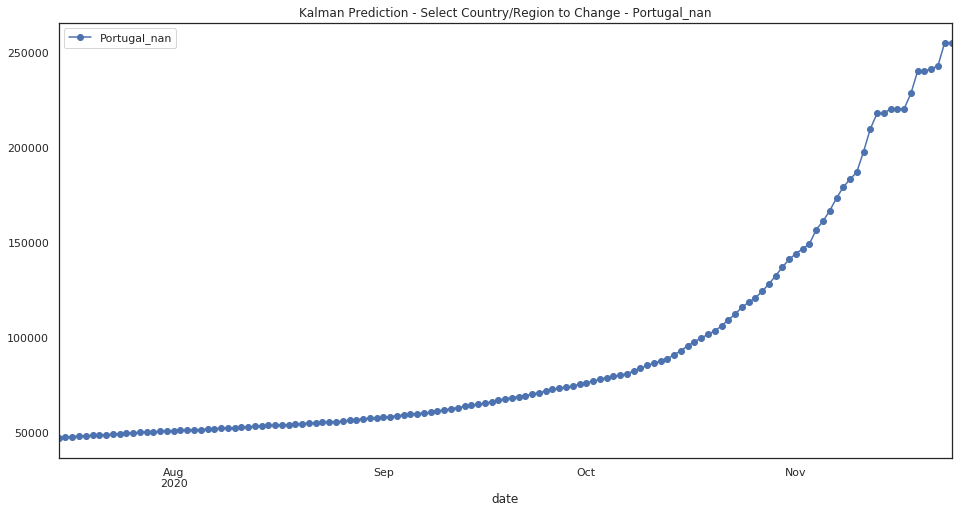

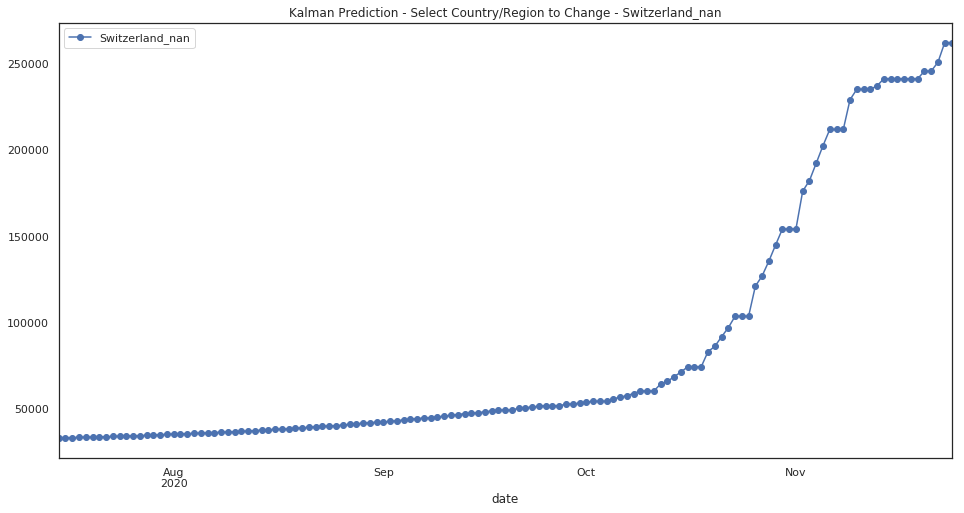

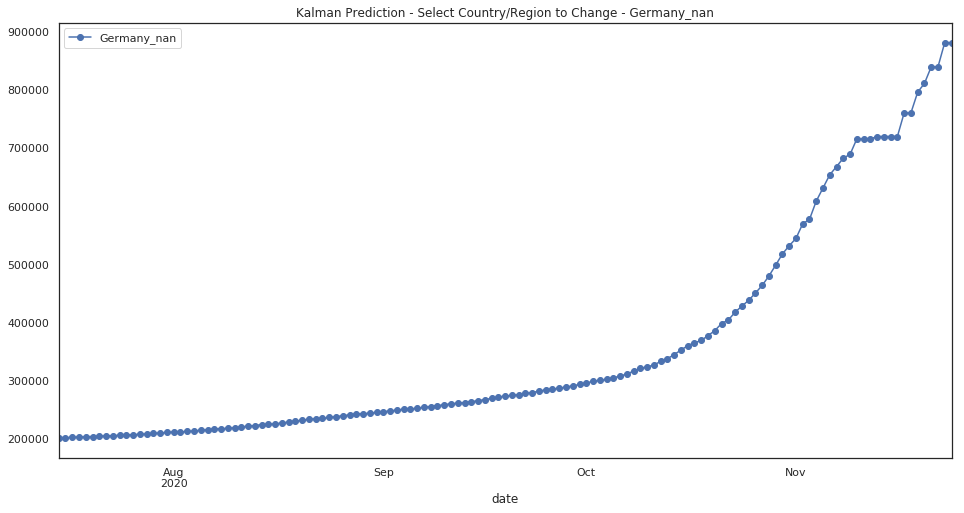

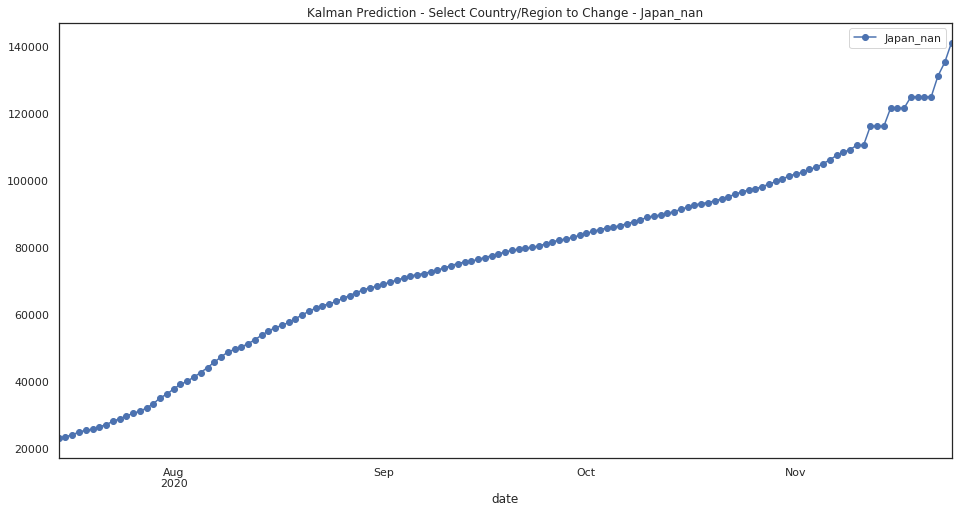

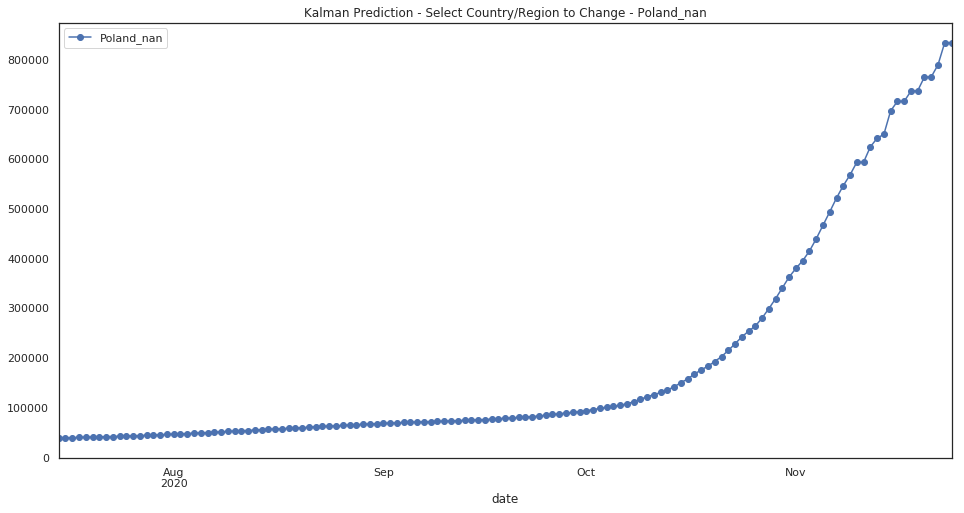

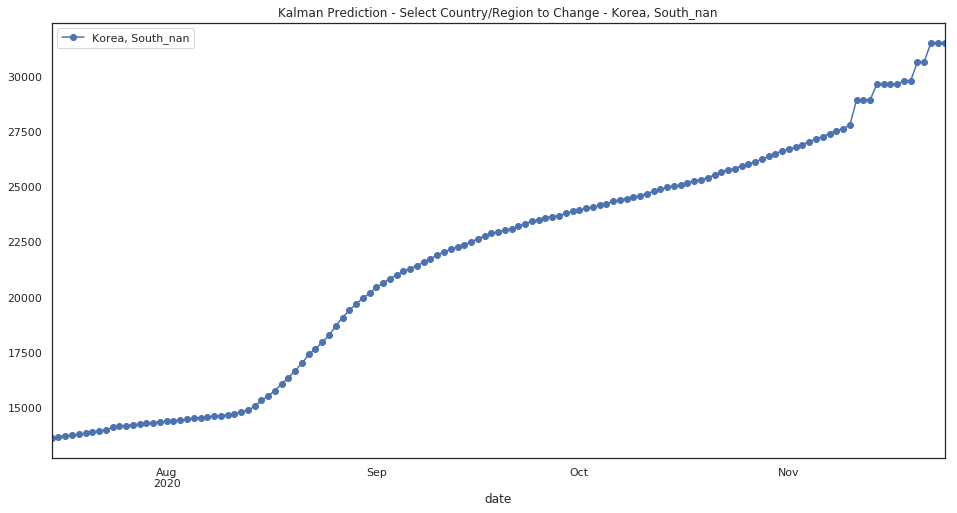

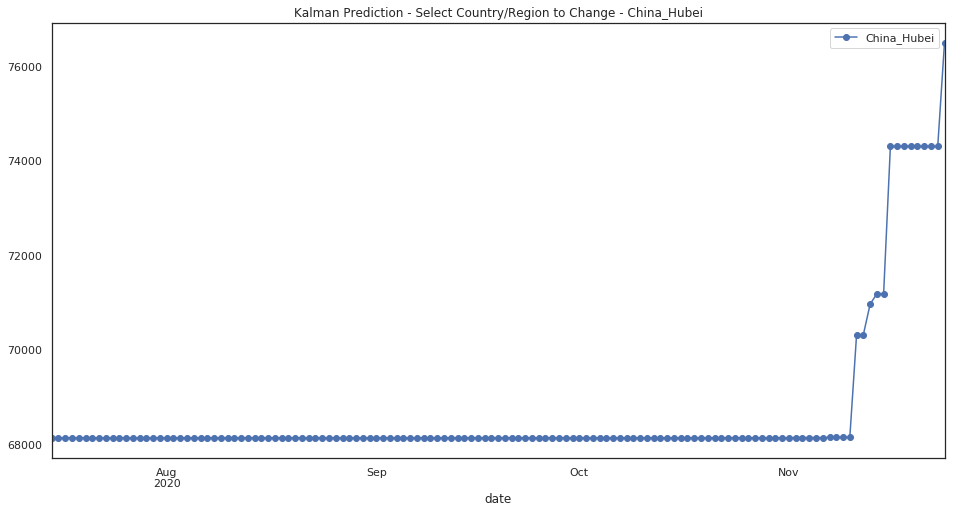

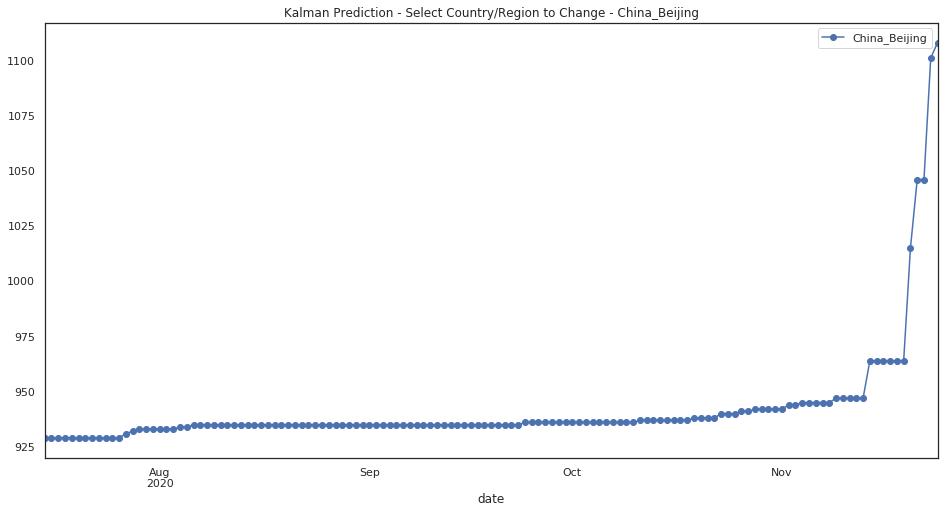

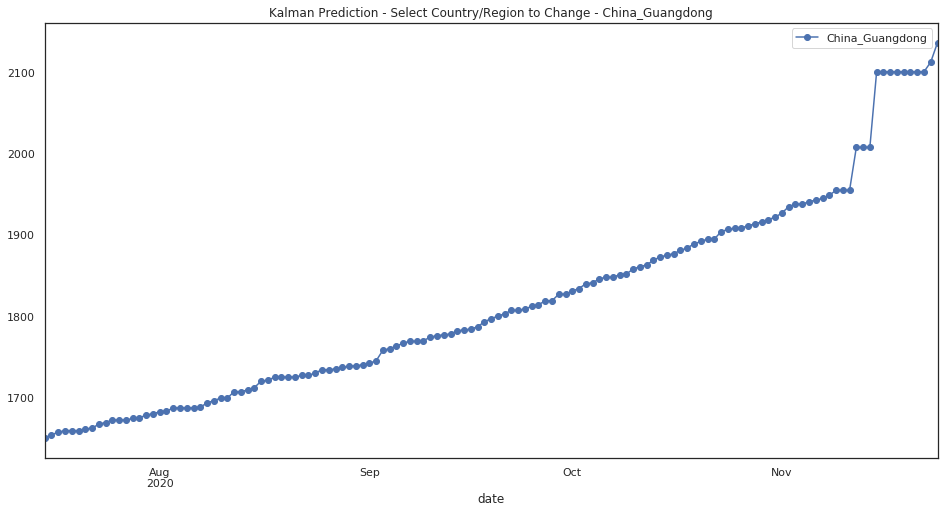

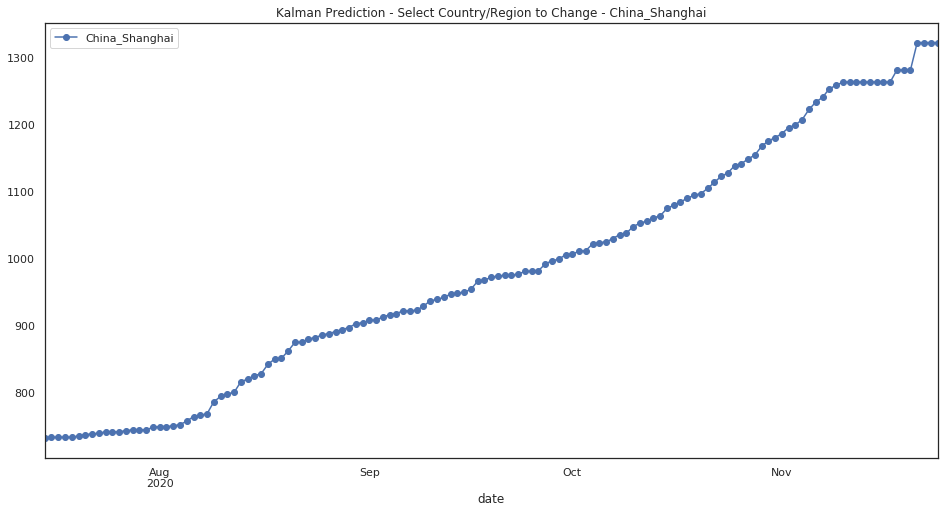

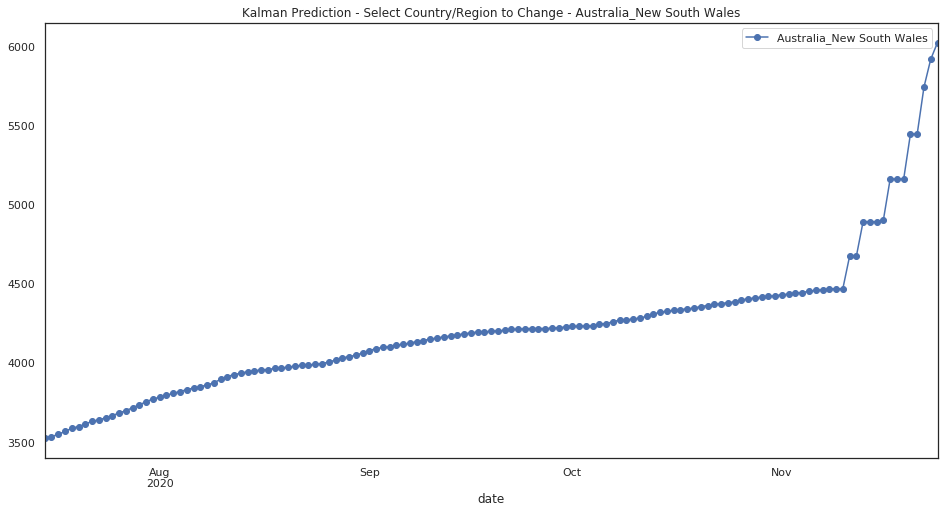

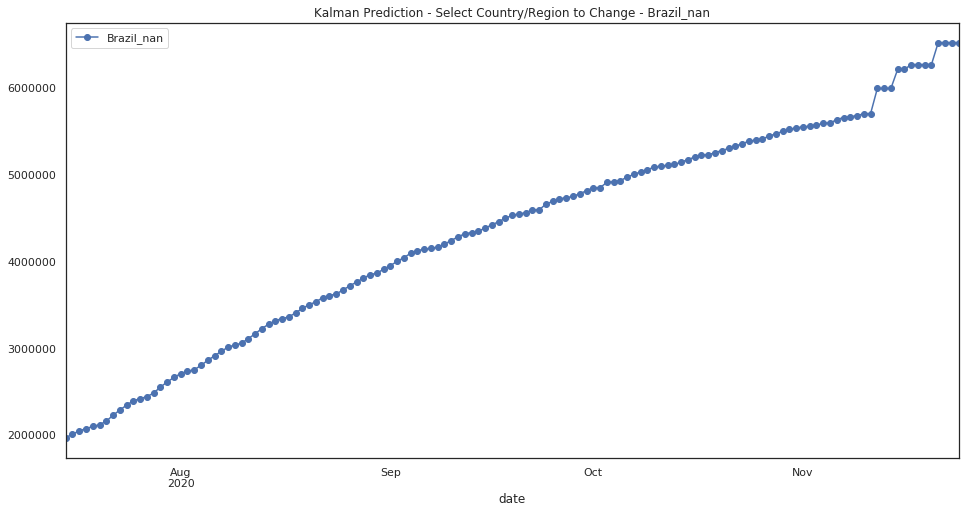

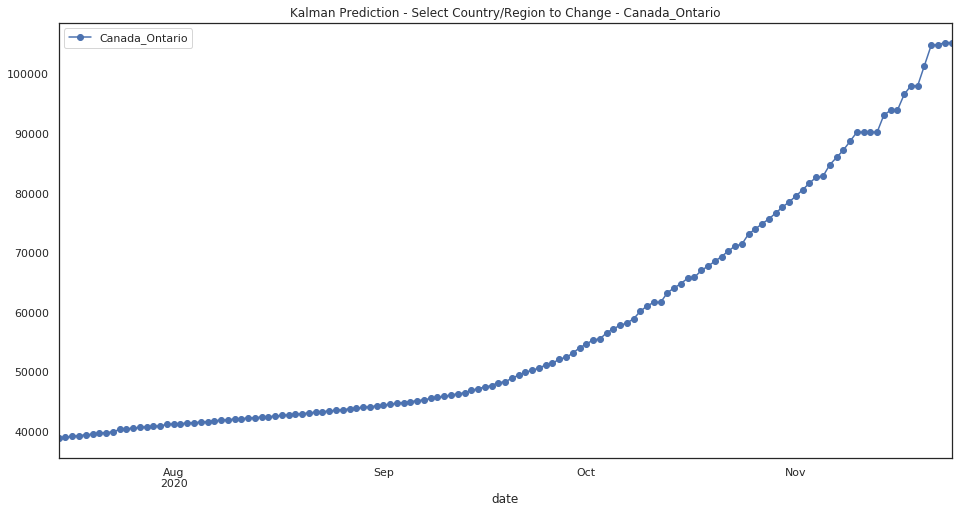

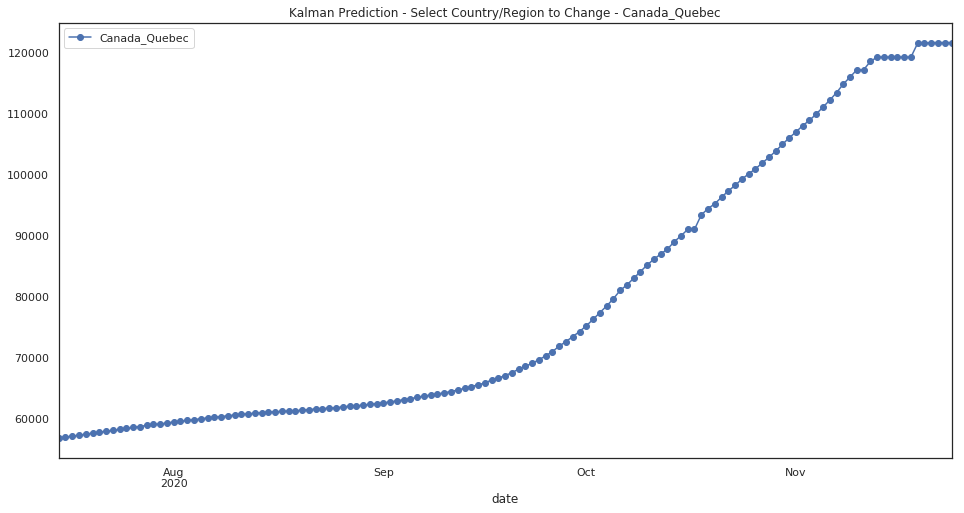

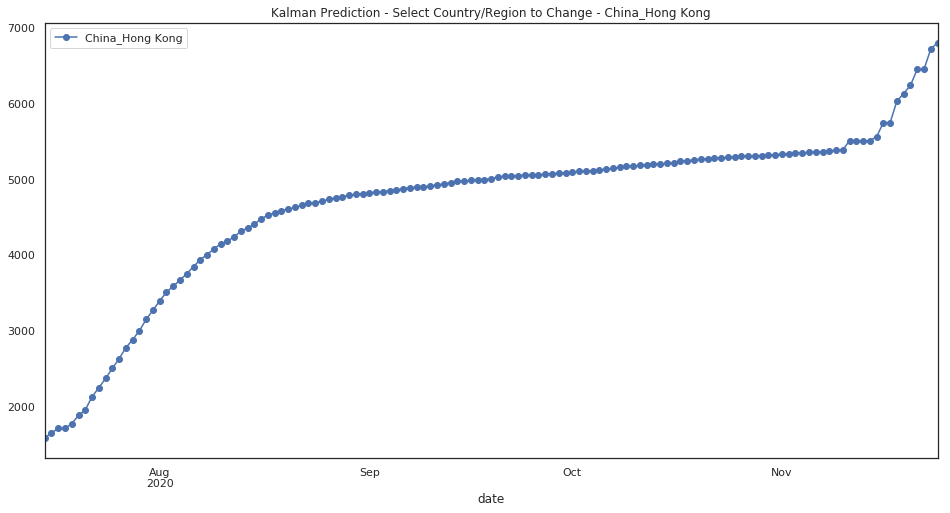

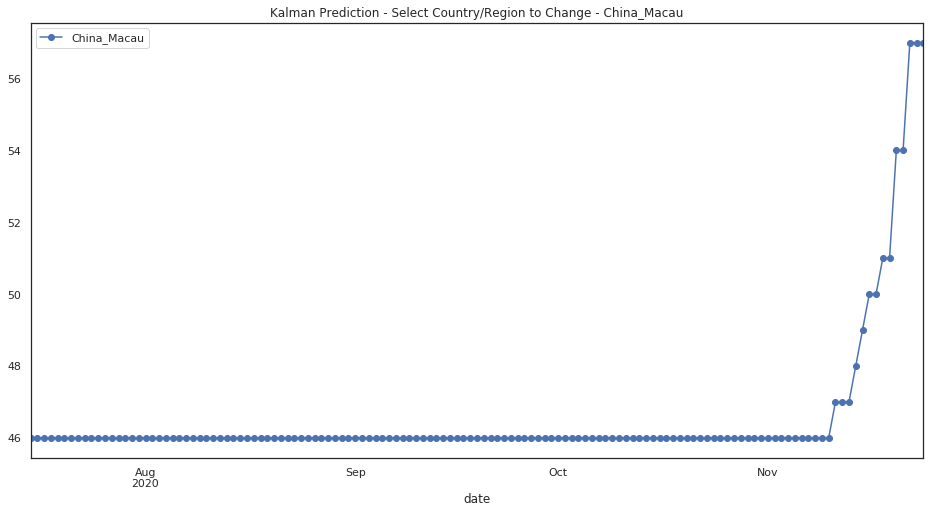

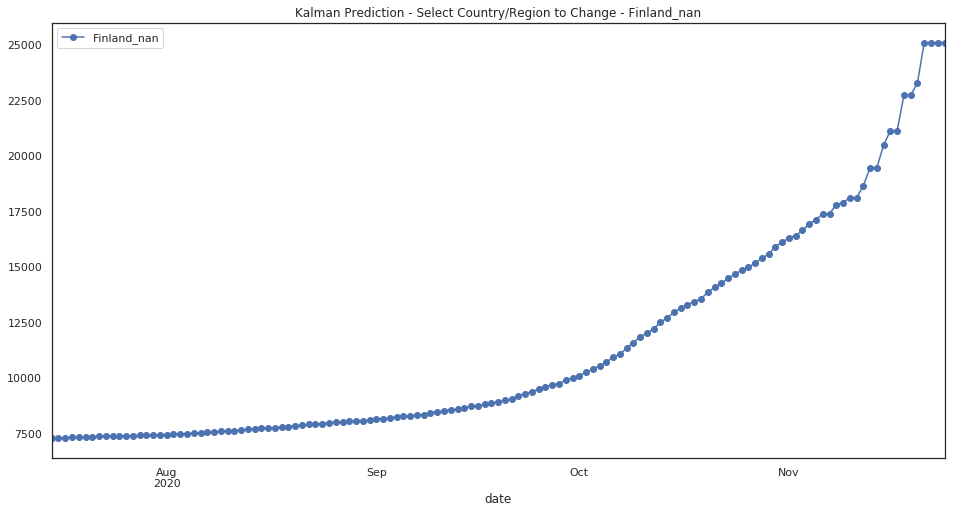

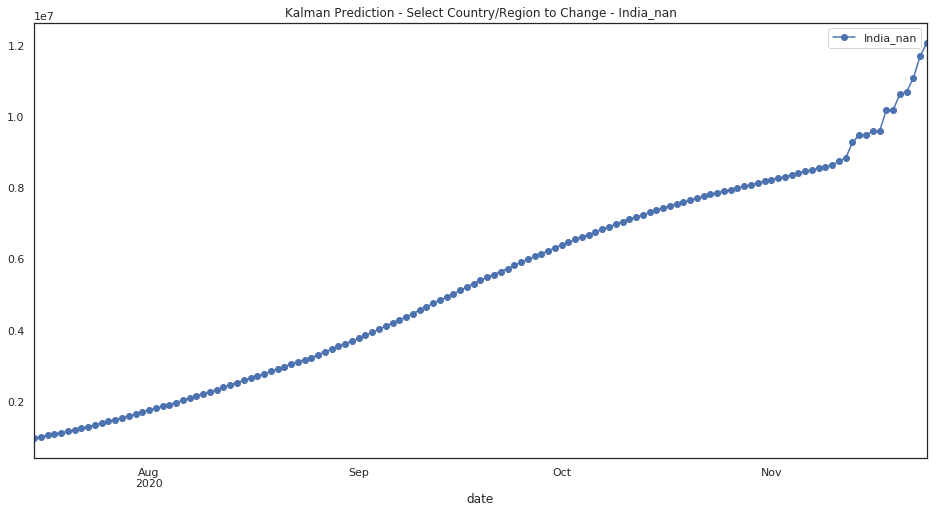

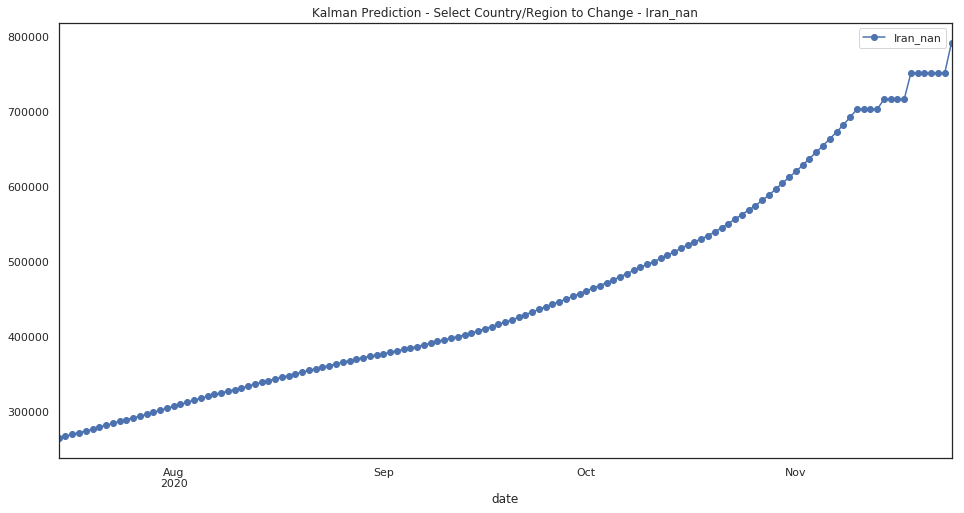

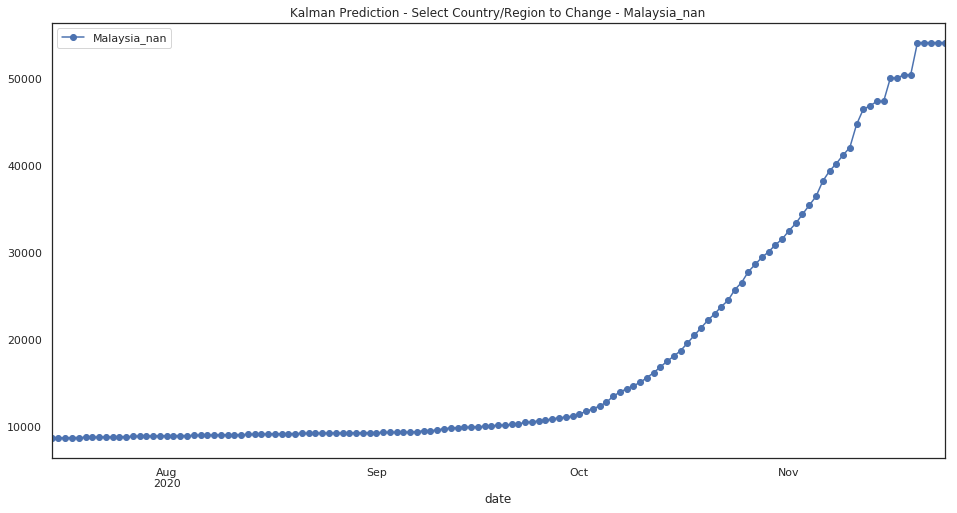

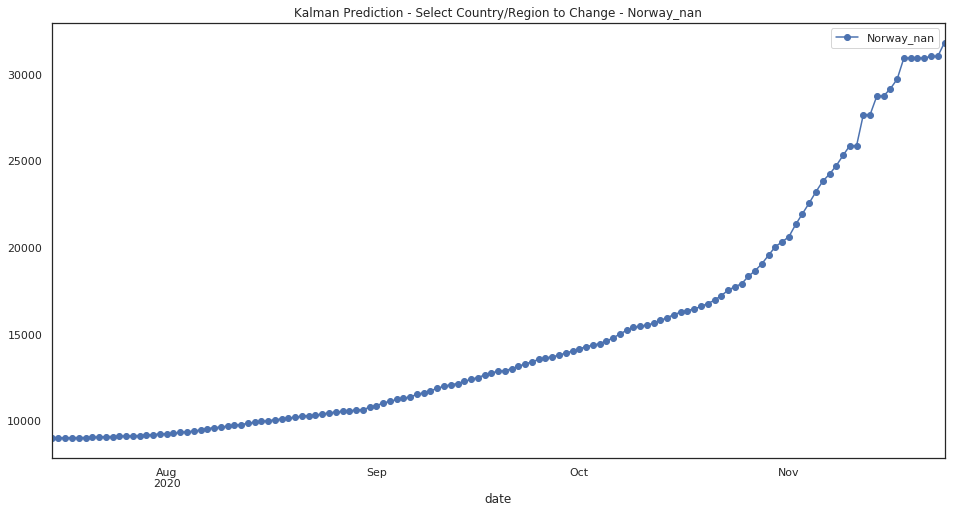

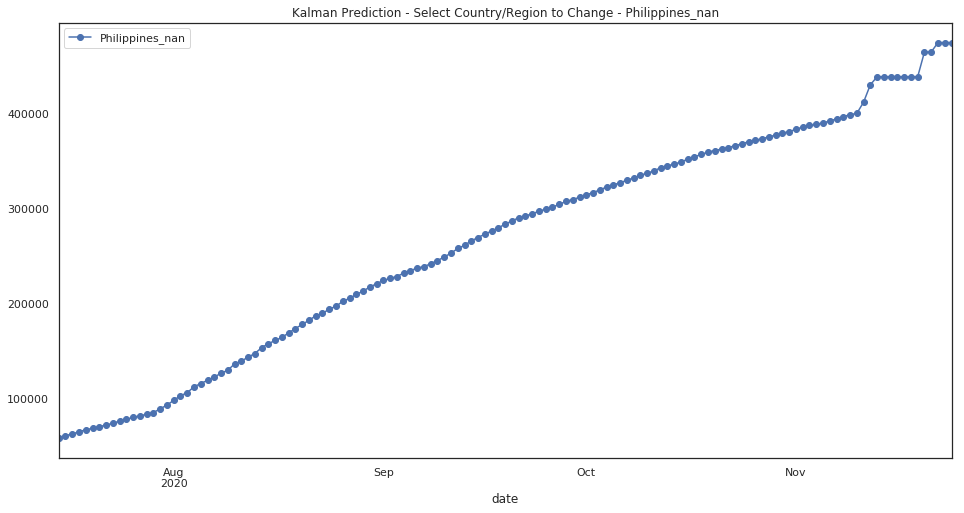

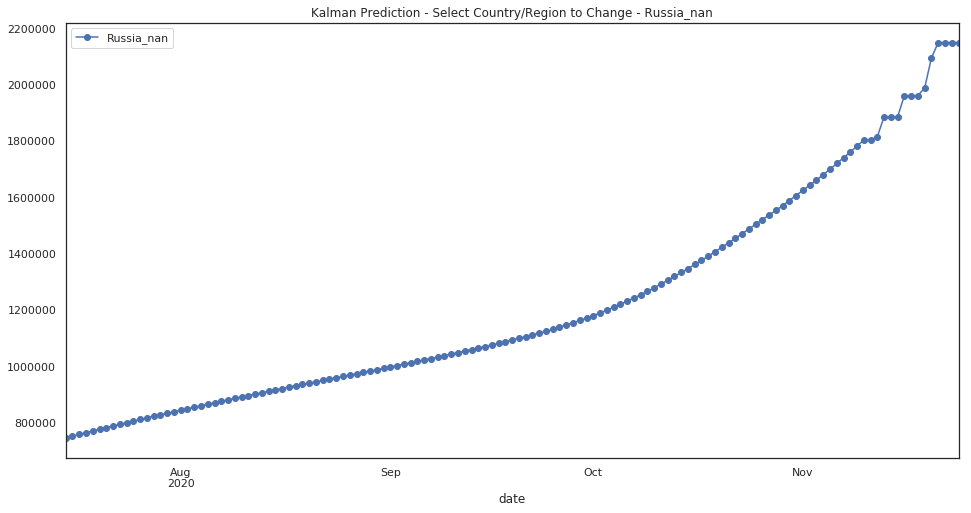

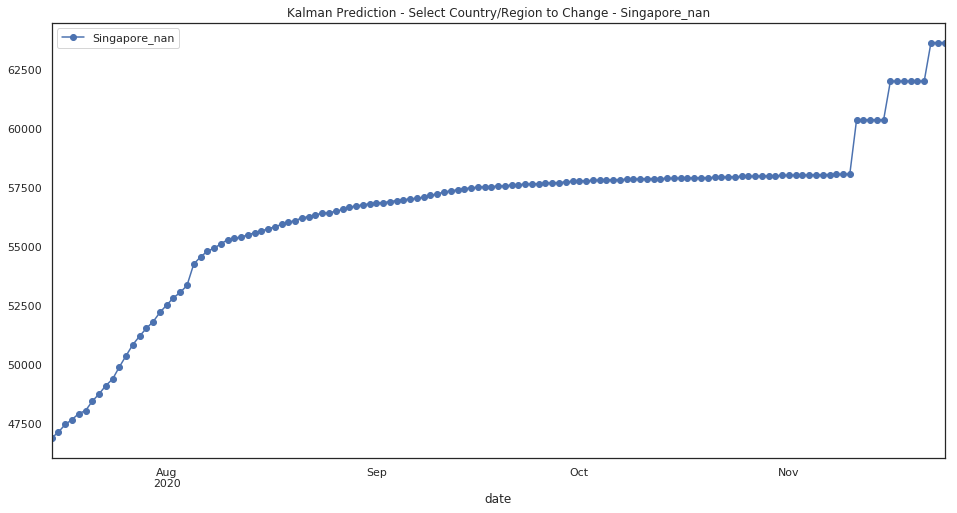

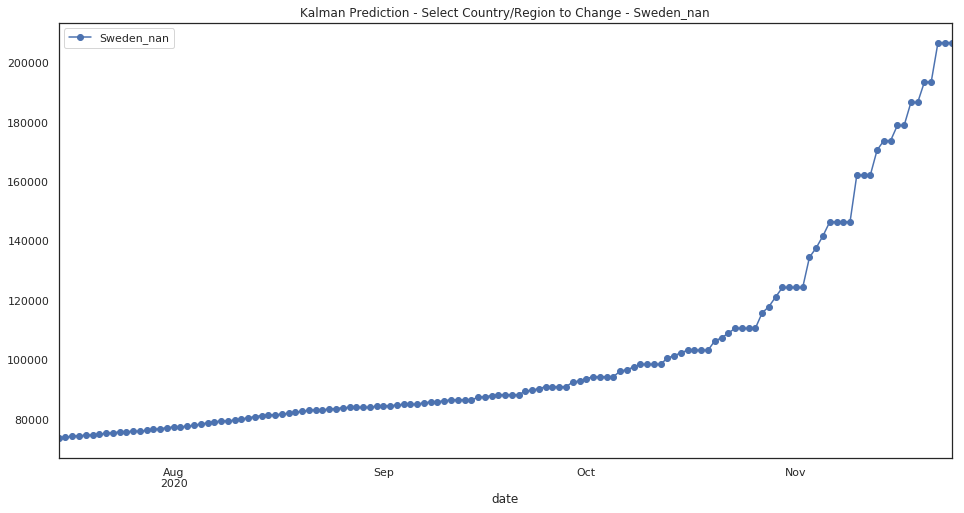

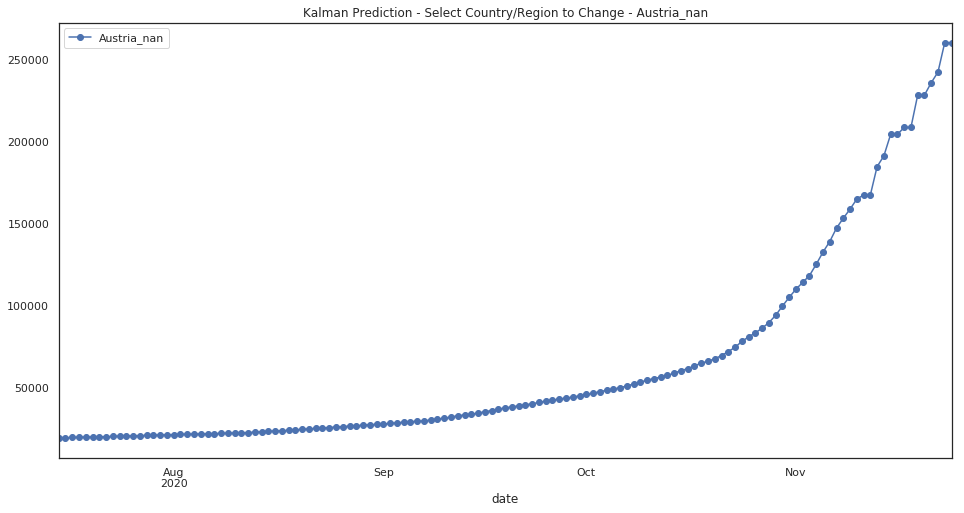

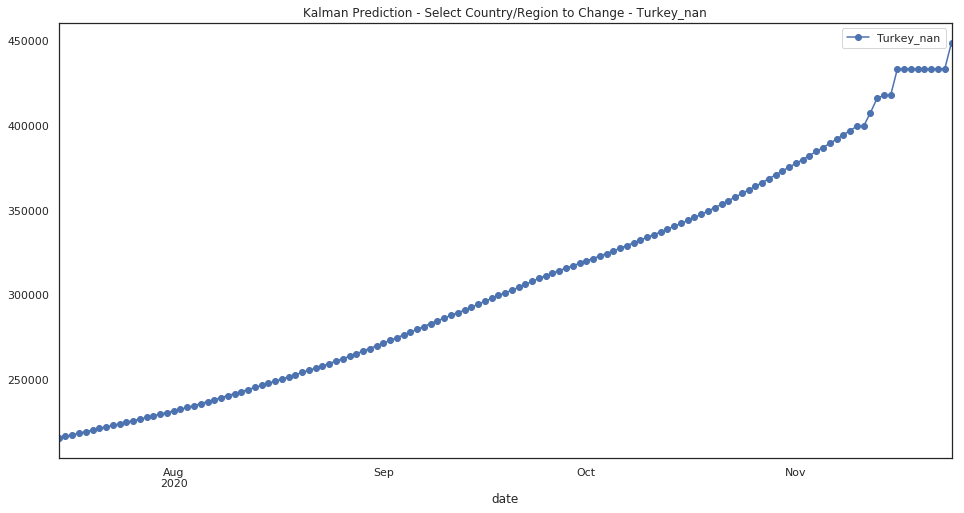

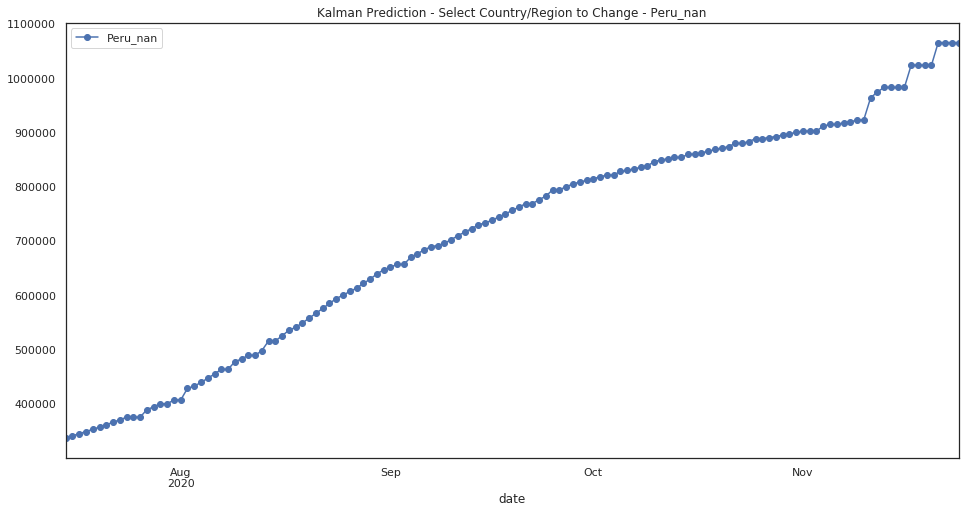

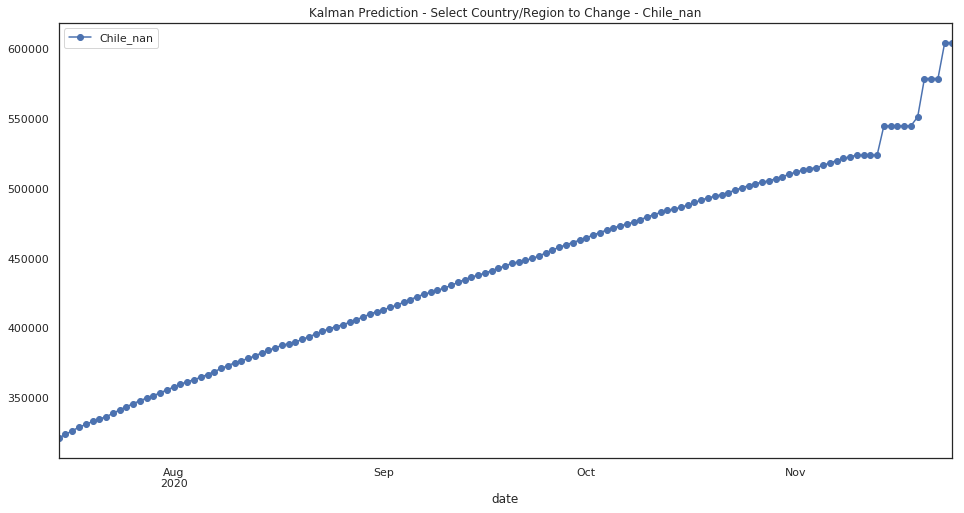

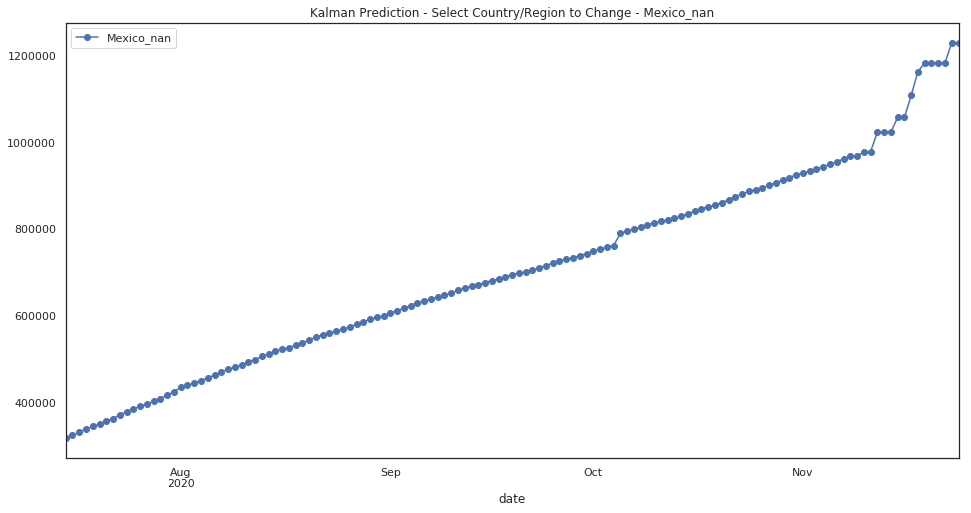

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-11-24 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      12586140.0
India_nan                                   NaN      12084222.0
Brazil_nan                                  NaN       6516646.0
Russia_nan                                  NaN       2149435.0
France_nan                                  NaN       1918059.0
Spain_nan                                   NaN       1654894.0
United Kingdom_nan                          NaN       1481246.0
Argentina_nan                               NaN       1481240.0
Colombia_nan                                NaN       1433914.0
Italy_nan                                   NaN       1259032.0
Mexico_nan                                  NaN       1230418.0
Peru_nan                                    NaN       1065403.0
Germany_nan                                 NaN        881663.0
Poland_nan                                  NaN        834367.0
South Africa_nan                            NaN        819070.0
Iran_nan                                    NaN        792536.0
Ukraine_nan                                 NaN        619128.0
Chile_nan                                   NaN        604643.0
Indonesia_nan                               NaN        603749.0
Iraq_nan                                    NaN        579797.0
Czechia_nan                                 NaN        555302.0
Belgium_nan                                 NaN        553234.0
Saudi Arabia_nan                            NaN        488839.0
Bangladesh_nan                              NaN        479487.0
Netherlands_nan                             NaN        479059.0
Philippines_nan                             NaN        474177.0
Turkey_nan                                  NaN        448593.0
Romania_nan                                 NaN        448503.0
Pakistan_nan                                NaN        424130.0
Israel_nan                                  NaN        367181.0
...                                         ...             ...
Dominica_nan                                NaN            90.0
China_Ningxia                               NaN            86.0
Saint Vincent and the Grenadines_nan        NaN            85.0
Canada_Prince Edward Island                 NaN            81.0
United Kingdom_British Virgin Islands       NaN            76.0
China_Macau                                 NaN            57.0
Australia_Northern Territory                NaN            47.0
Grenada_nan                                 NaN            41.0
Fiji_nan                                    NaN            40.0
Timor-Leste_nan                             NaN            34.0
Holy See_nan                                NaN            31.0
France_New Caledonia                        NaN            31.0
Canada_Yukon                                NaN            28.0
Laos_nan                                    NaN            26.0
Saint Kitts and Nevis_nan                   NaN            24.0
Solomon Islands_nan                         NaN            19.0
China_Qinghai                               NaN            19.0
Denmark_Greenland                           NaN            19.0
Canada_Grand Princess                       NaN            17.0
France_Saint Pierre and Miquelon            NaN            17.0
United Kingdom_Montserrat                   NaN            15.0
United Kingdom_Falkland Islands (Malvinas)  NaN            13.0
Western Sahara_nan                          NaN            10.0
Canada_Northwest Territories                NaN            10.0
MS Zaandam_nan                              NaN             9.0
United Kingdom_Anguilla                     NaN             3.0
Marshall Islands_nan                        NaN             2.0
Vanuatu_nan                                 NaN             1.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[269 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          43884.0      16672.0      31494.0      14154.0   
2020-07-16          43950.0      16758.0      32004.0      14168.0   
2020-07-17          35070.0       3851.0      21355.0        877.0   
2020-07-18          35229.0       3906.0      21948.0        880.0   
2020-07-19          35301.0       4008.0      22549.0        880.0   
2020-07-20          35475.0       4090.0      23086.0        880.0   
2020-07-21          35526.0       4171.0      23691.0        884.0   
2020-07-22          35615.0       4290.0      24278.0        884.0   
2020-07-23          36011.0       4485.0      25453.0        889.0   
2020-07-24          36062.0       4467.0      26116.0        954.0   
2020-07-25          36164.0       4570.0      26710.0        897.0   
2020-07-26          36273.0       4793.0      27346.0        959.0   
2020-07-27          36353.0       4763.0      27970.0        967.0   
2020-07-28          36467.0       4899.0      28598.0        907.0   
2020-07-29          36573.0       5020.0      29211.0        981.0   
2020-07-30          36648.0       5147.0      29833.0        918.0   
2020-07-31          36779.0       5270.0      30409.0        934.0   
2020-08-01          36809.0       5413.0      30978.0        949.0   
2020-08-02          36843.0       5436.0      31499.0        988.0   
2020-08-03          36881.0       5540.0      32020.0        996.0   
2020-08-04          36898.0       5728.0      32547.0        937.0   
2020-08-05          36942.0       5798.0      33083.0        976.0   
2020-08-06          37003.0       5915.0      33645.0       1005.0   
2020-08-07          37109.0       6089.0      34176.0        944.0   
2020-08-08          37144.0       6207.0      34730.0        955.0   
2020-08-09          37176.0       6369.0      35203.0       1020.0   
2020-08-10          37280.0       6474.0      35766.0       1024.0   
2020-08-11          37352.0       6641.0      36238.0        963.0   
2020-08-12          37438.0       6755.0      36752.0       1032.0   
2020-08-13          37531.0       6909.0      37241.0        977.0   
...                     ...          ...          ...          ...   
2020-10-27          41128.0      19705.0      56784.0       4325.0   
2020-10-28          41243.0      20015.0      57101.0       4410.0   
2020-10-29          41360.0      20278.0      57406.0       4517.0   
2020-10-30          41432.0      20614.0      57728.0       4567.0   
2020-10-31          41535.0      20840.0      58022.0       4665.0   
2020-11-01          41605.0      21201.0      58353.0       4756.0   
2020-11-02          41732.0      21472.0      58653.0       4825.0   
2020-11-03          41819.0      21851.0      59050.0       4888.0   
2020-11-04          41917.0      22221.0      59566.0       4910.0   
2020-11-05          42036.0      22638.0      60182.0       5045.0   
2020-11-06          42076.0      23116.0      60818.0       5135.0   
2020-11-07          42152.0      23585.0      61424.0       5135.0   
2020-11-08          42204.0      24099.0      62100.0       5319.0   
2020-11-09          42386.0      24631.0      62739.0       5383.0   
2020-11-10          42524.0      25188.0      63491.0       5437.0   
2020-11-11          42563.0      25294.0      63583.0       5477.0   
2020-11-12          42606.0      25509.0      63680.0       5477.0   
2020-11-13          42594.0      25466.0      63641.0       5556.0   
2020-11-14          42586.0      25859.0      63597.0       5556.0   
2020-11-15          42585.0      25798.0      63585.0       5556.0   
2020-11-16          43994.0      26365.0      63570.0       5772.0   
2020-11-17          44082.0      27457.0      63556.0       5904.0   
2020-11-18          44985.0      27741.0      63540.0       5904.0   
2020-11-19          44936.0      29107.0      63540.0       6145.0   
2020-11-20

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'France_nan',
 'Spain_nan',
 'United Kingdom_nan',
 'Argentina_nan',
 'Colombia_nan',
 'Italy_nan',
 'Mexico_nan',
 'Peru_nan',
 'Germany_nan',
 'Poland_nan',
 'South Africa_nan',
 'Iran_nan',
 'Ukraine_nan',
 'Chile_nan',
 'Indonesia_nan',
 'Iraq_nan',
 'Czechia_nan',
 'Belgium_nan',
 'Saudi Arabia_nan',
 'Bangladesh_nan',
 'Netherlands_nan',
 'Philippines_nan',
 'Turkey_nan',
 'Romania_nan',
 'Pakistan_nan',
 'Israel_nan',
 'Morocco_nan',
 'Switzerland_nan',
 'Austria_nan',
 'Portugal_nan',
 'Nepal_nan',
 'Ecuador_nan',
 'Sweden_nan',
 'Bolivia_nan',
 'United Arab Emirates_nan',
 'Hungary_nan',
 'Panama_nan',
 'Kuwait_nan',
 'Qatar_nan',
 'Costa Rica_nan',
 'Guatemala_nan',
 'Jordan_nan',
 'Japan_nan',
 'Dominican Republic_nan',
 'Belarus_nan',
 'Lebanon_nan',
 'Kazakhstan_nan',
 'Armenia_nan',
 'Oman_nan',
 'Canada_Quebec',
 'Serbia_nan',
 'Egypt_nan',
 'Honduras_nan',
 'Ethiopia_nan',
 'Venezuela_nan',
 'Canada_Onta

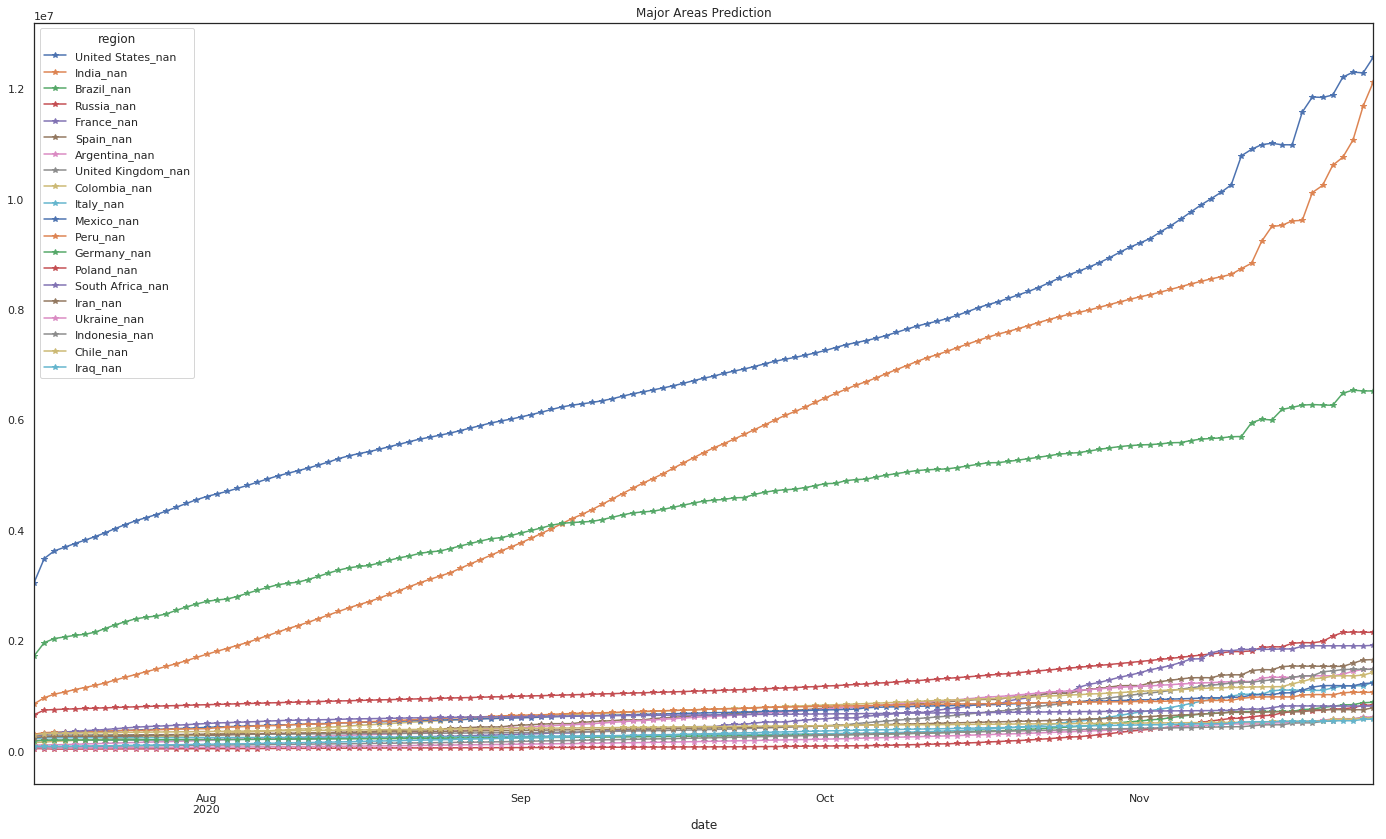

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

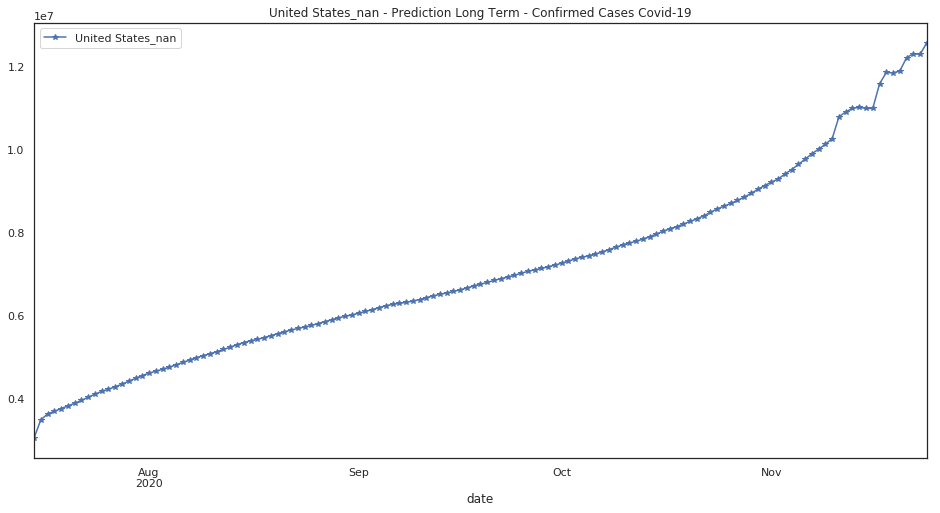

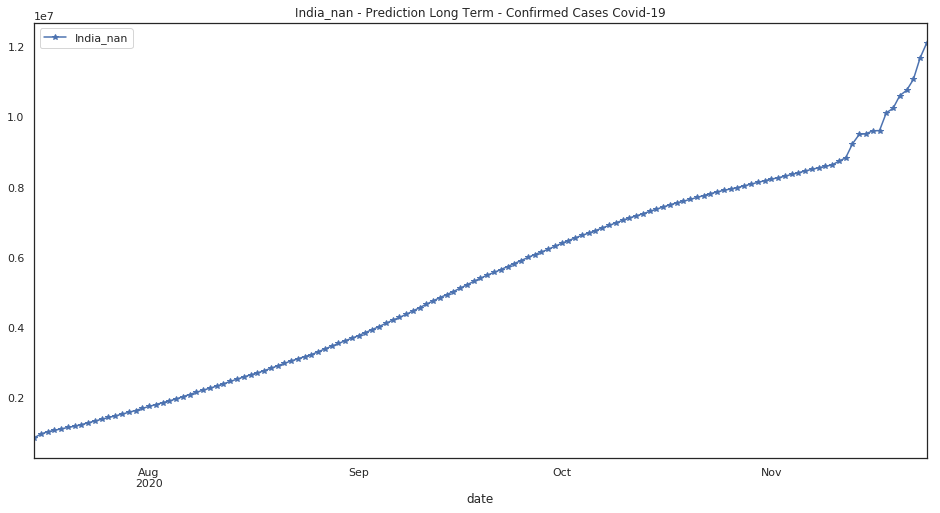

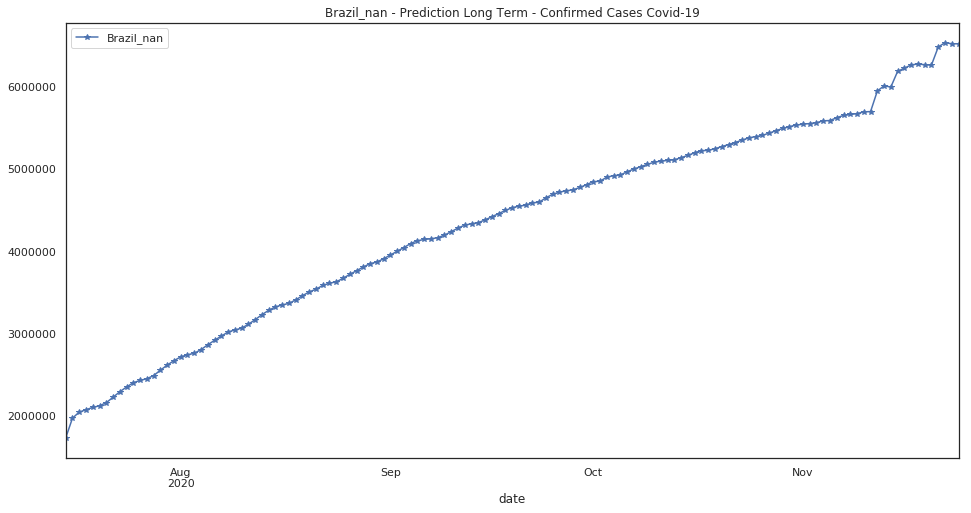

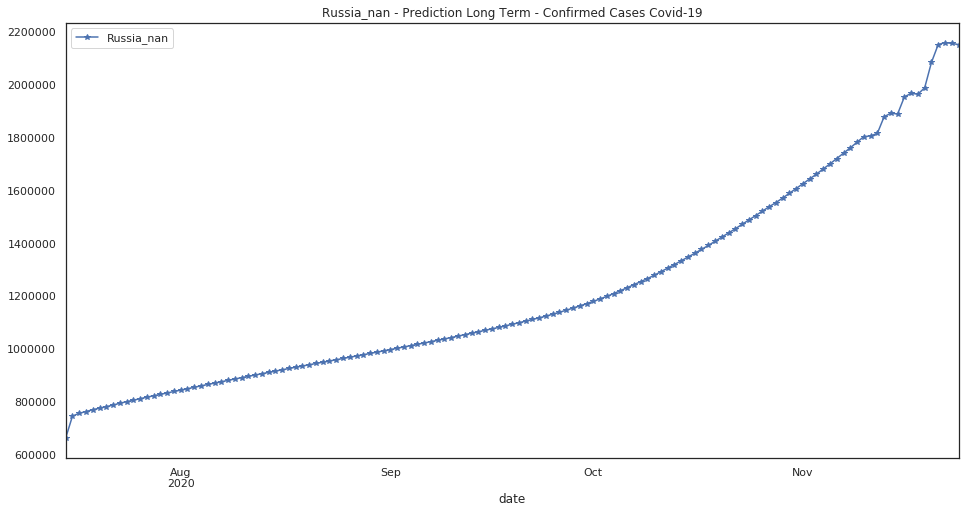

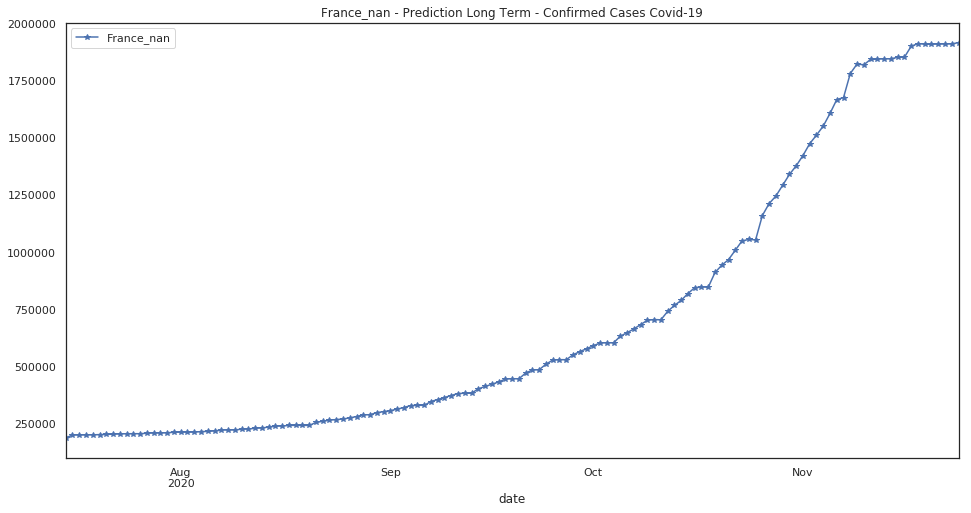

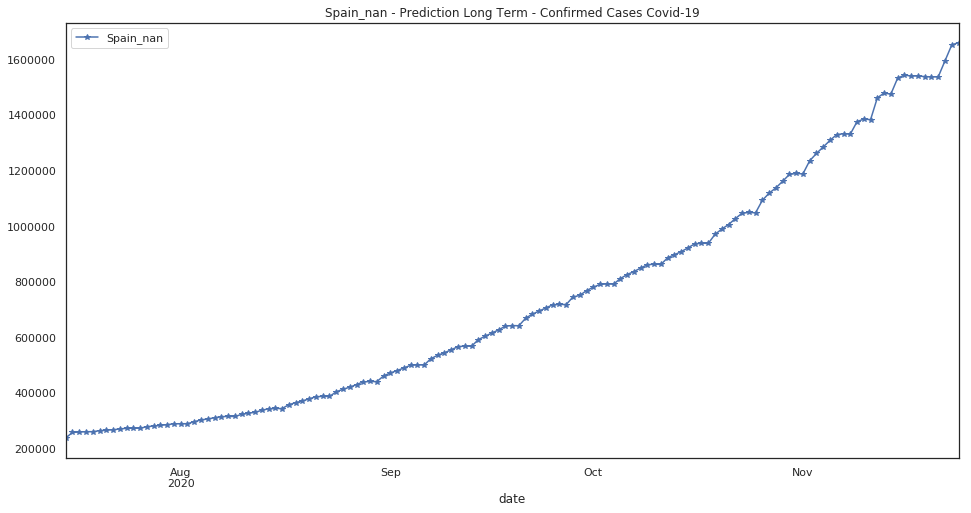

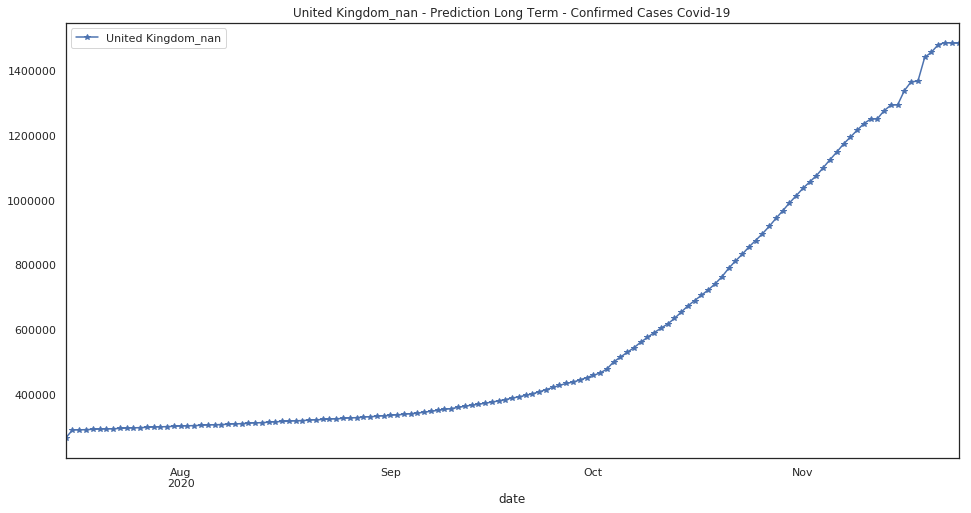

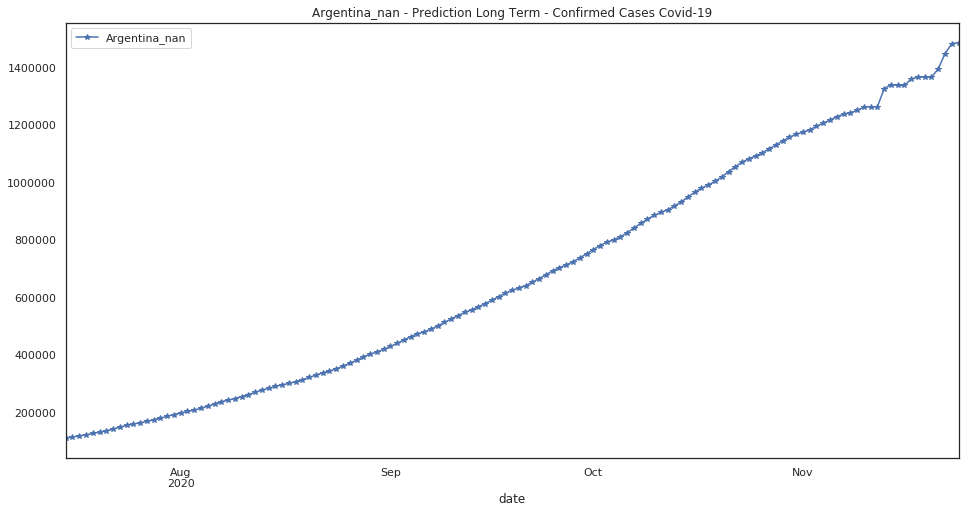

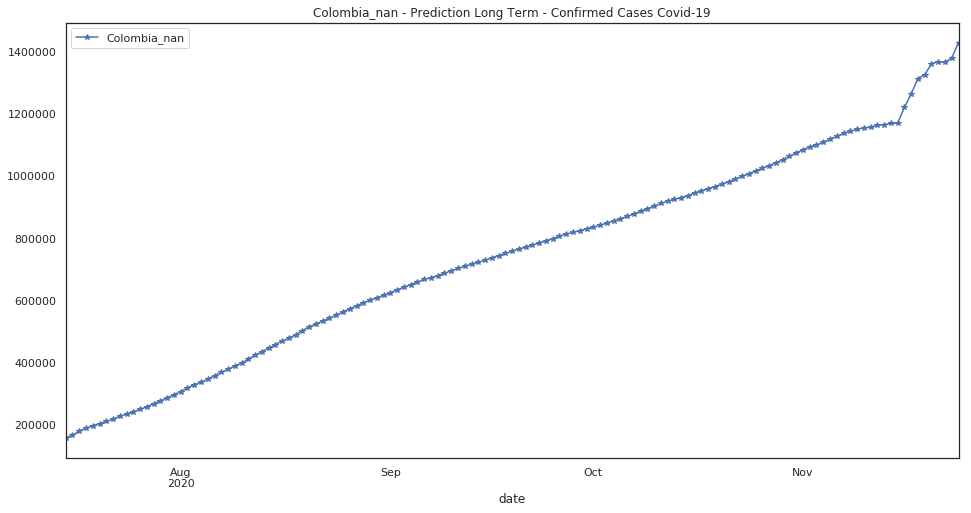

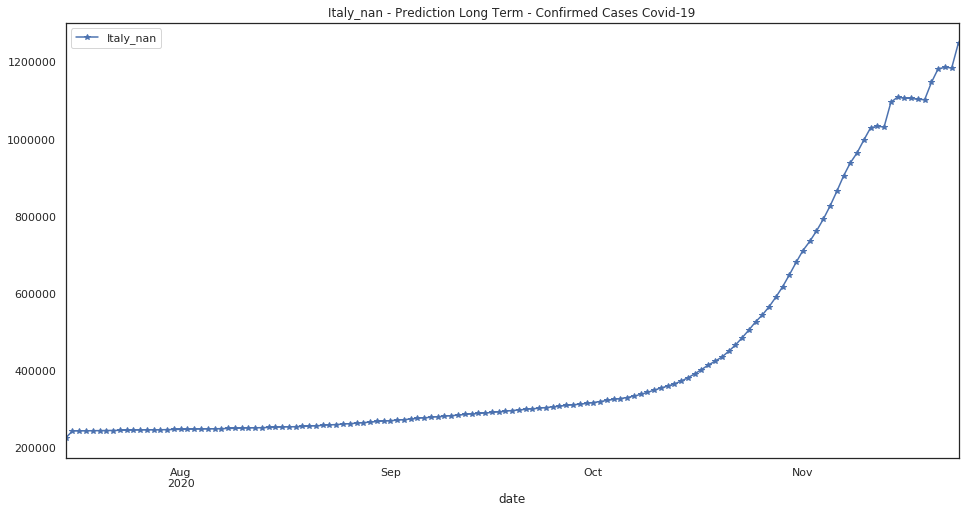

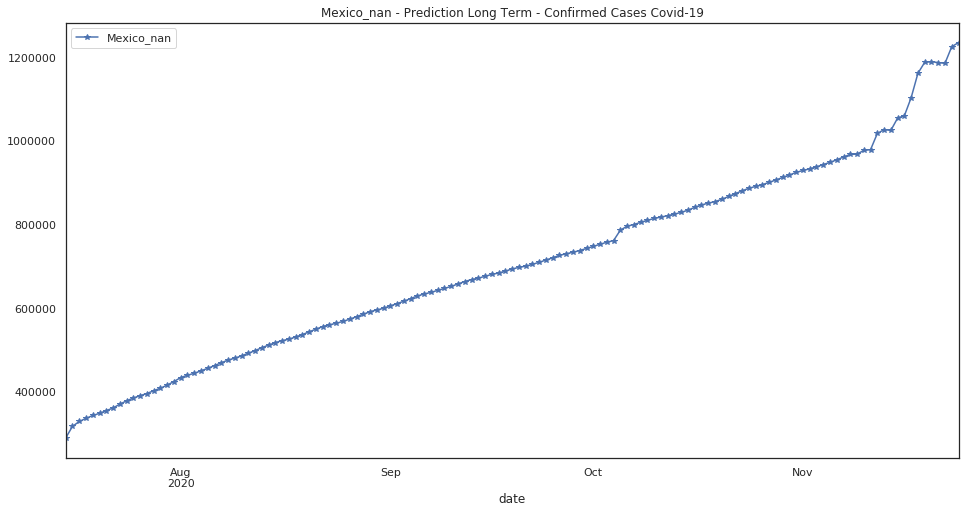

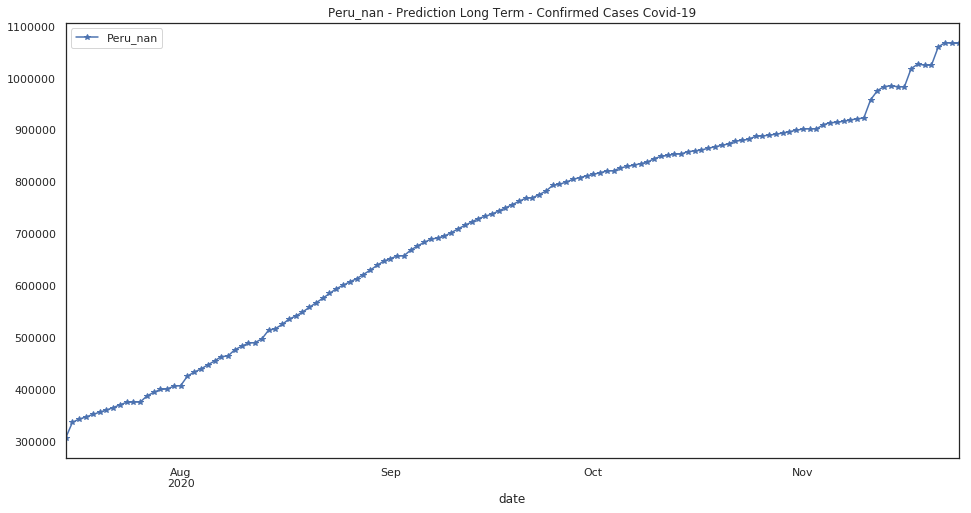

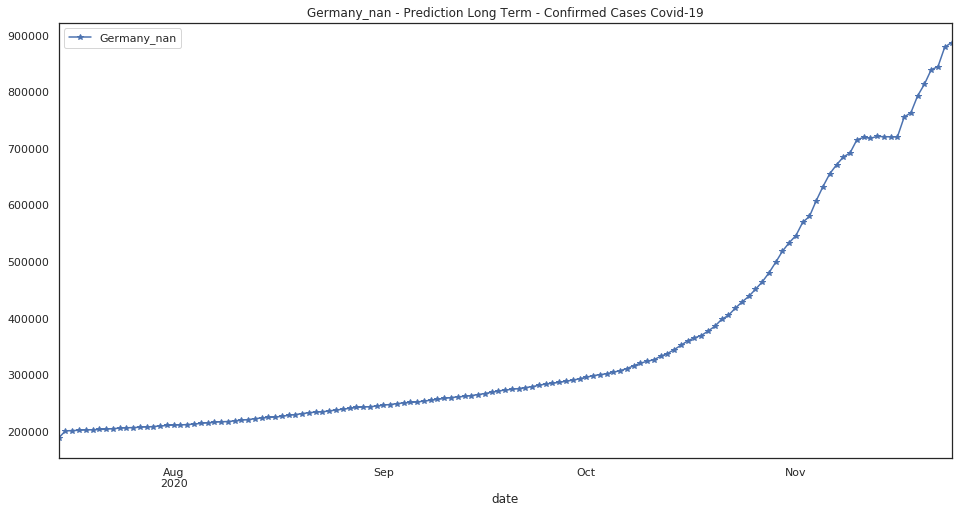

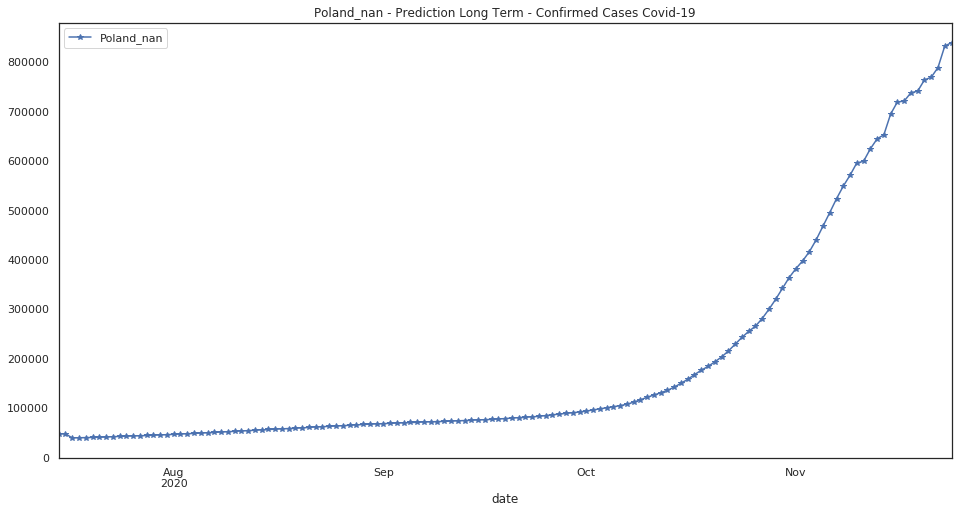

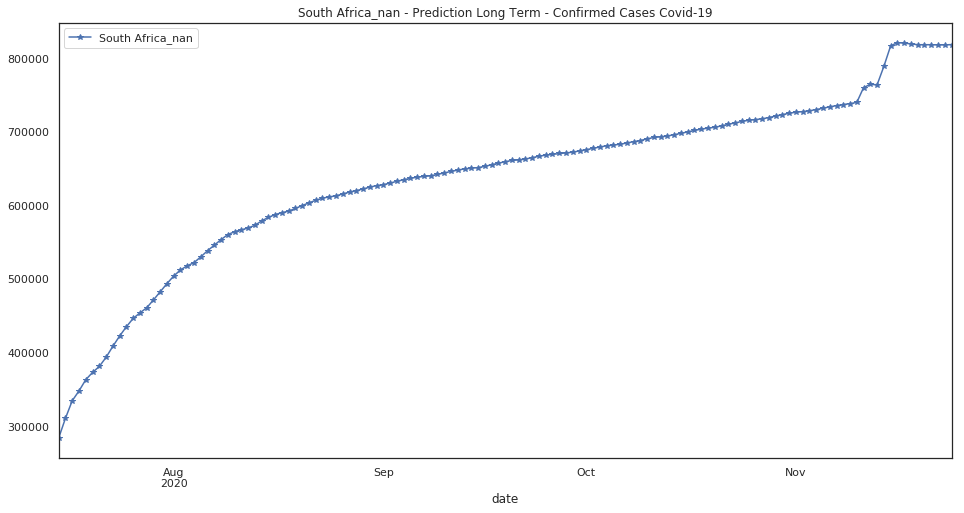

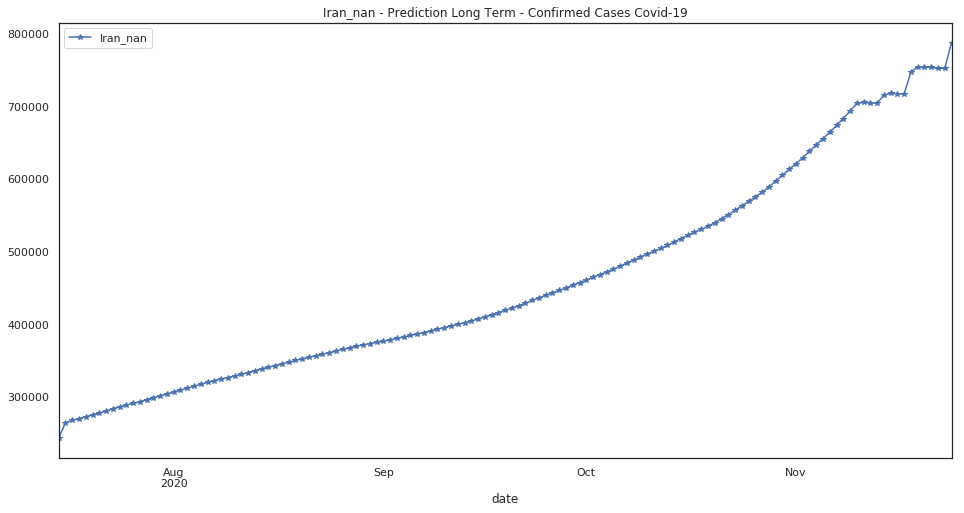

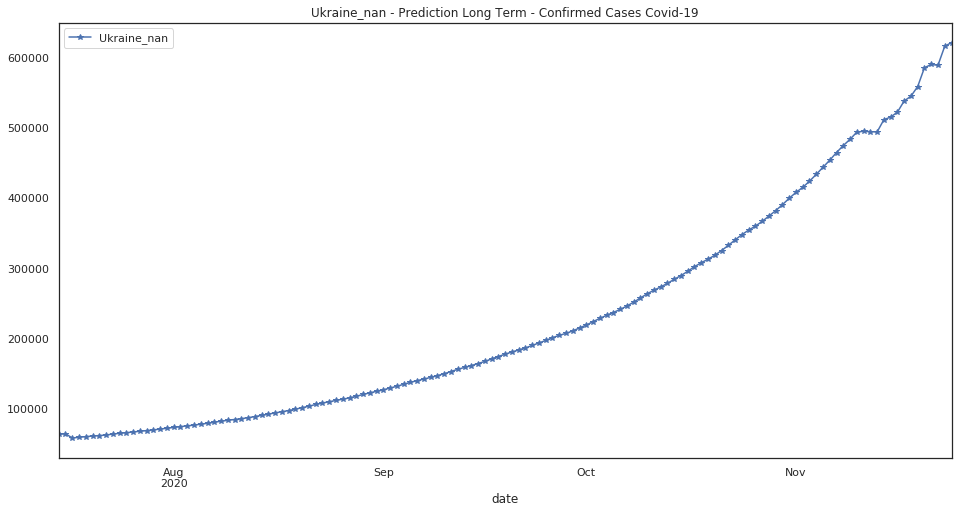

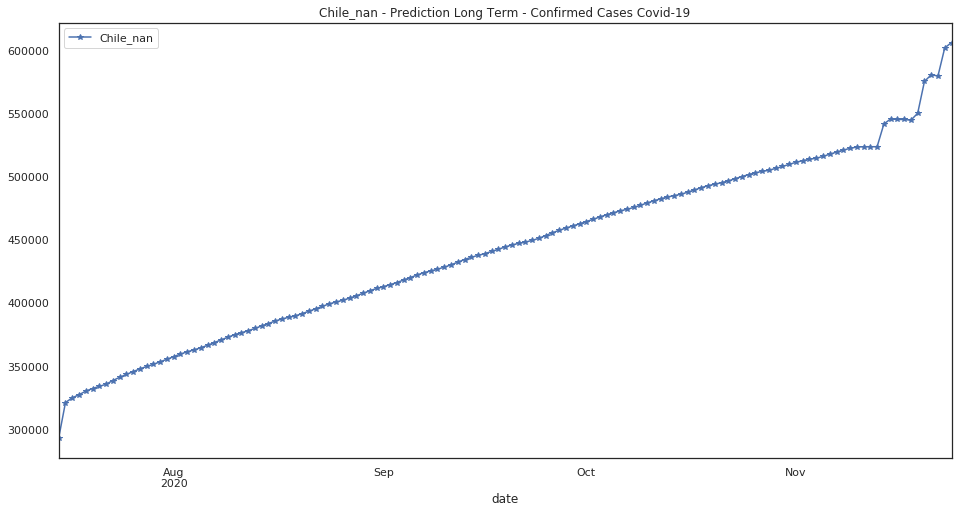

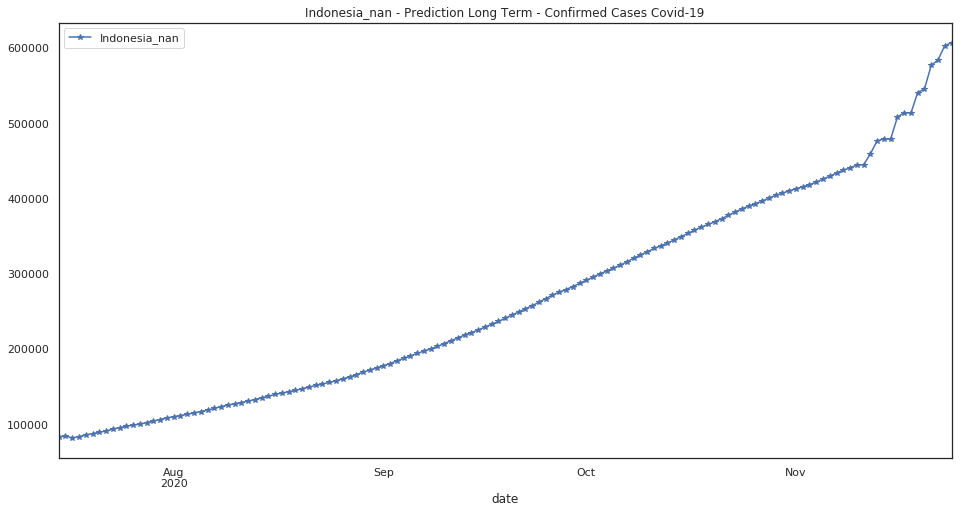

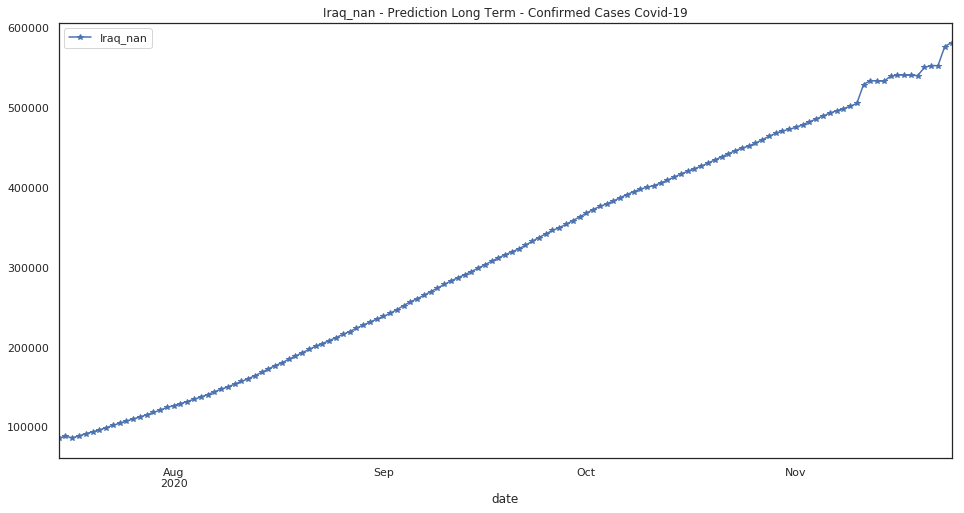

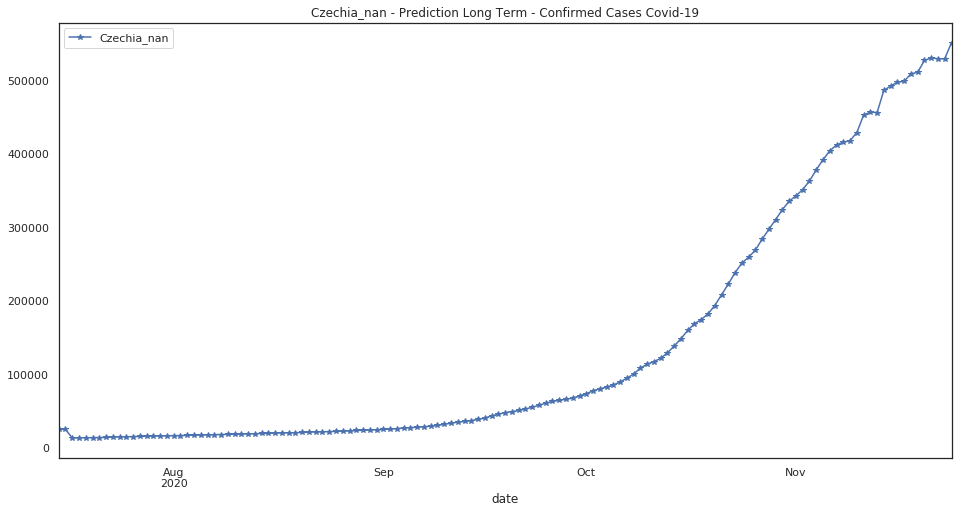

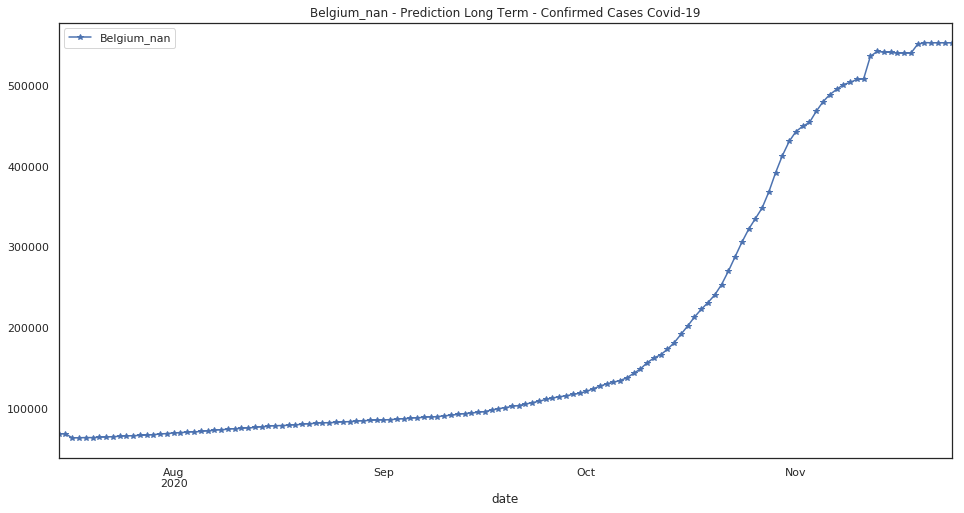

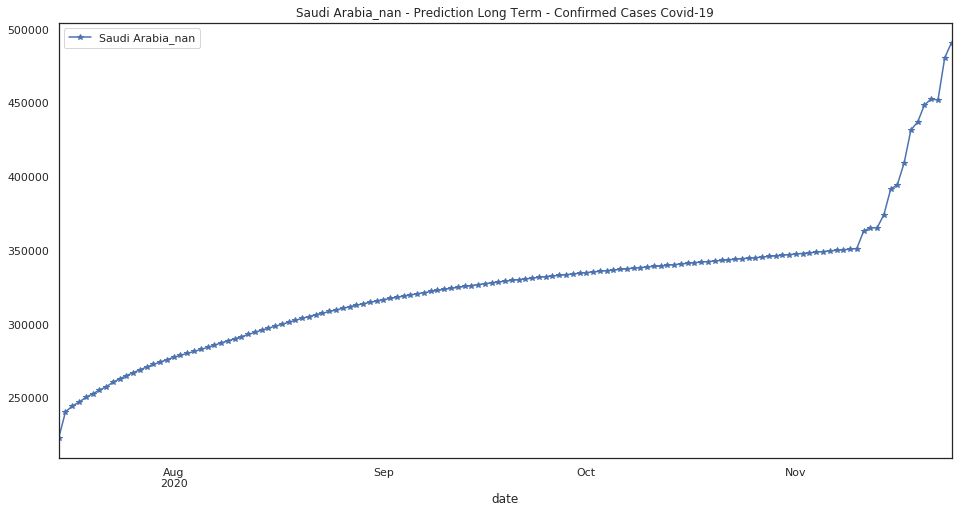

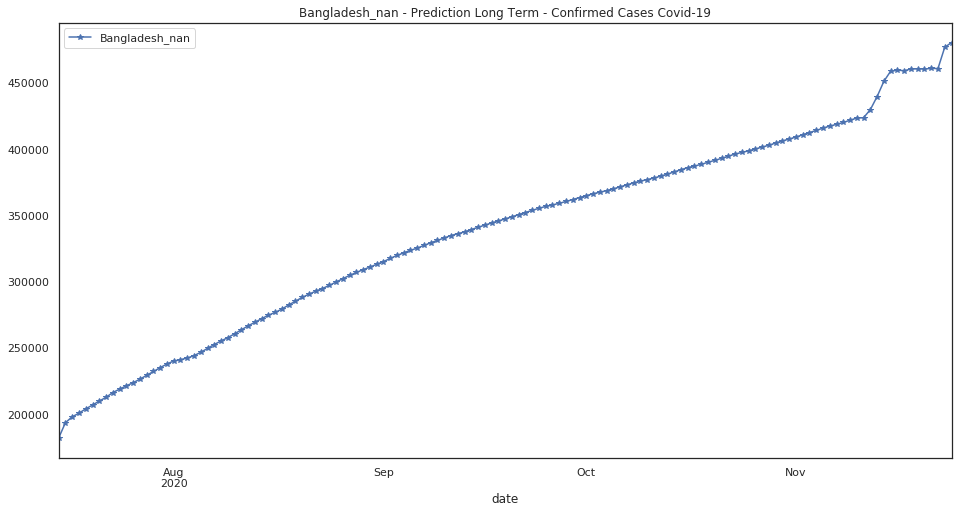

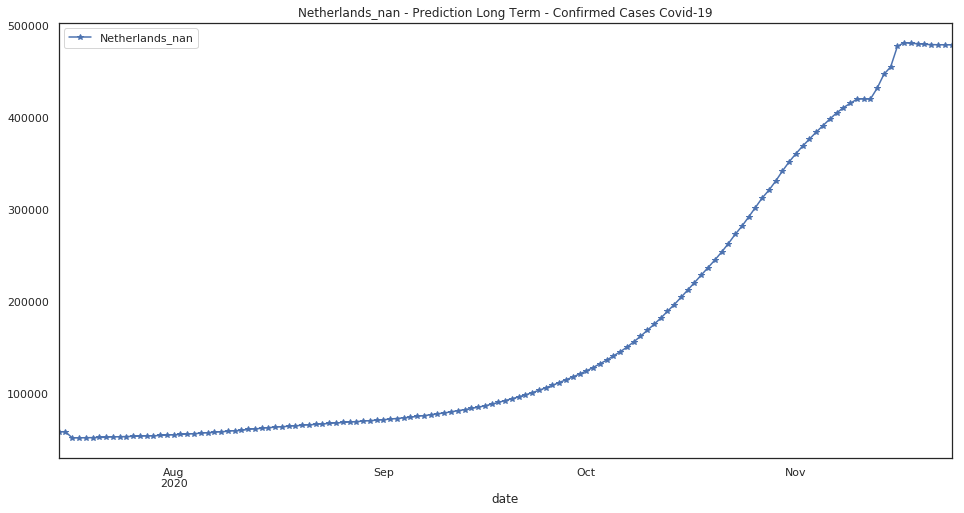

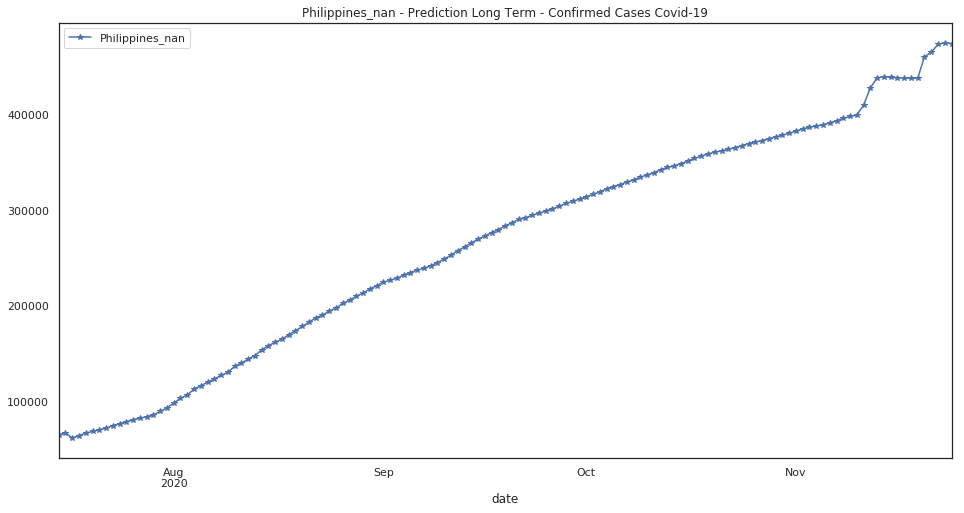

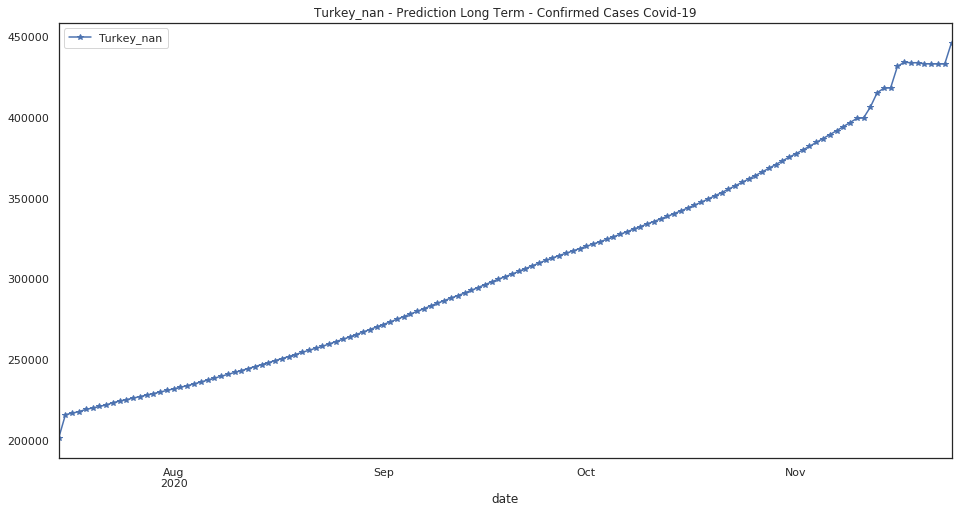

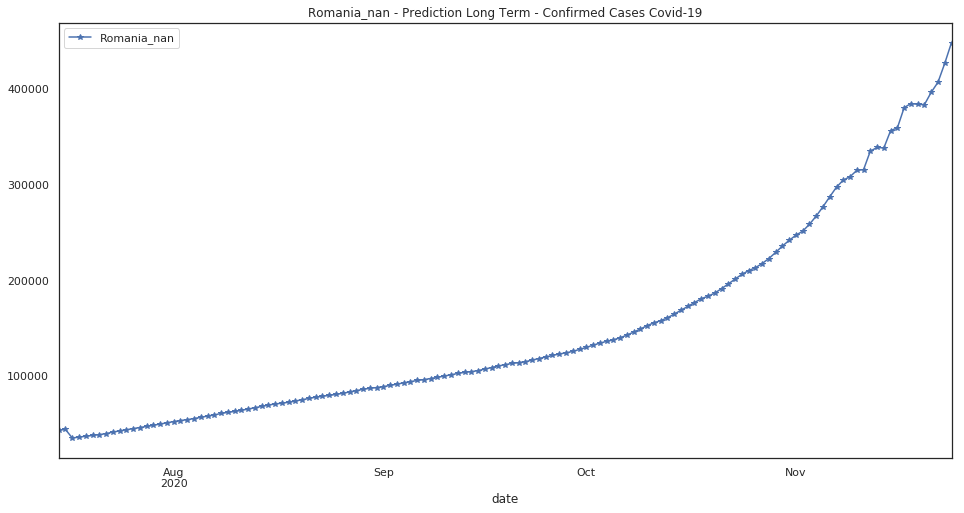

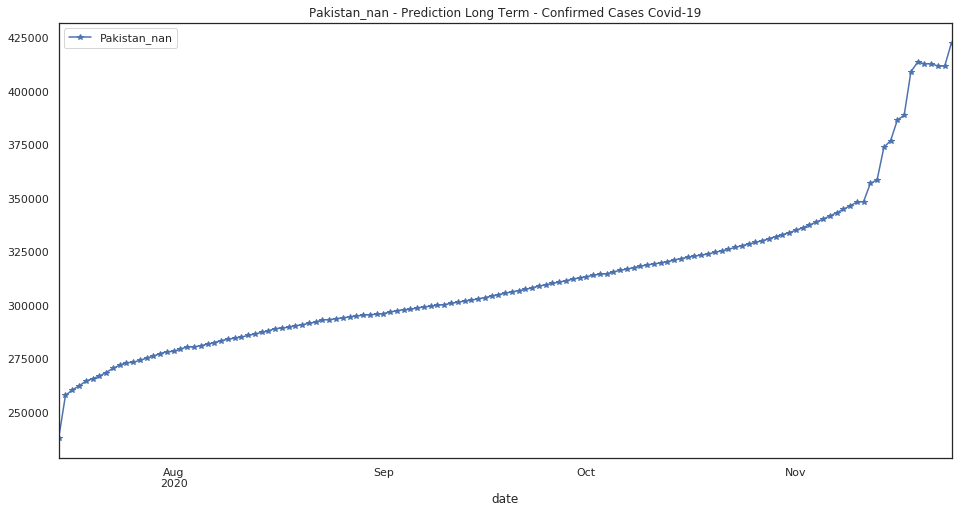

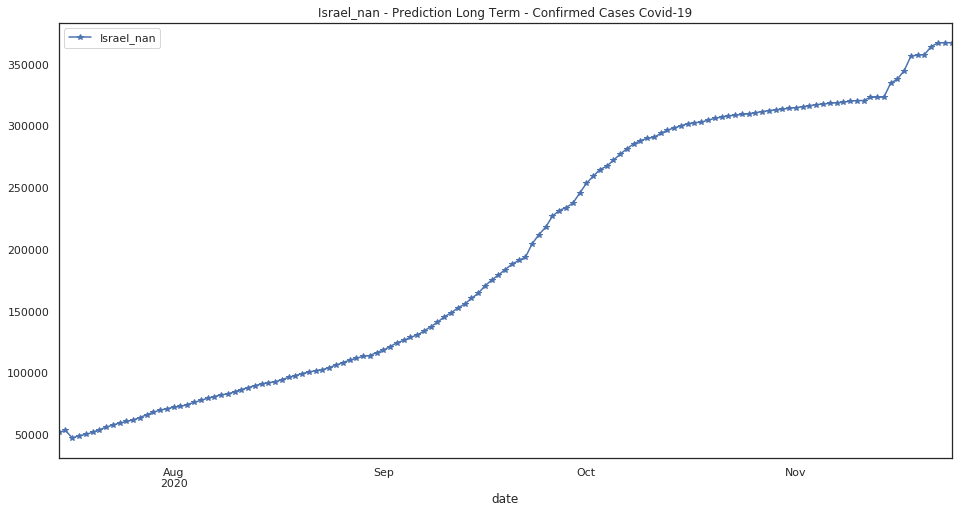

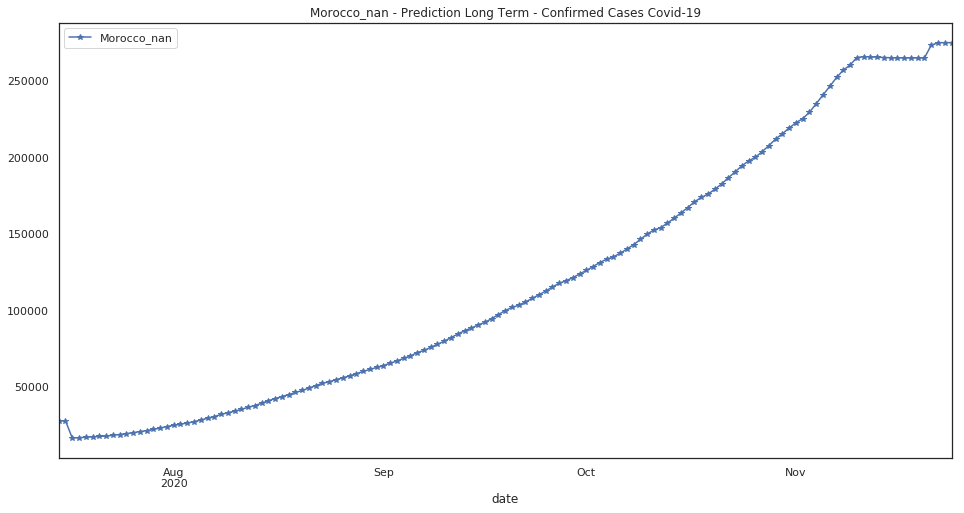

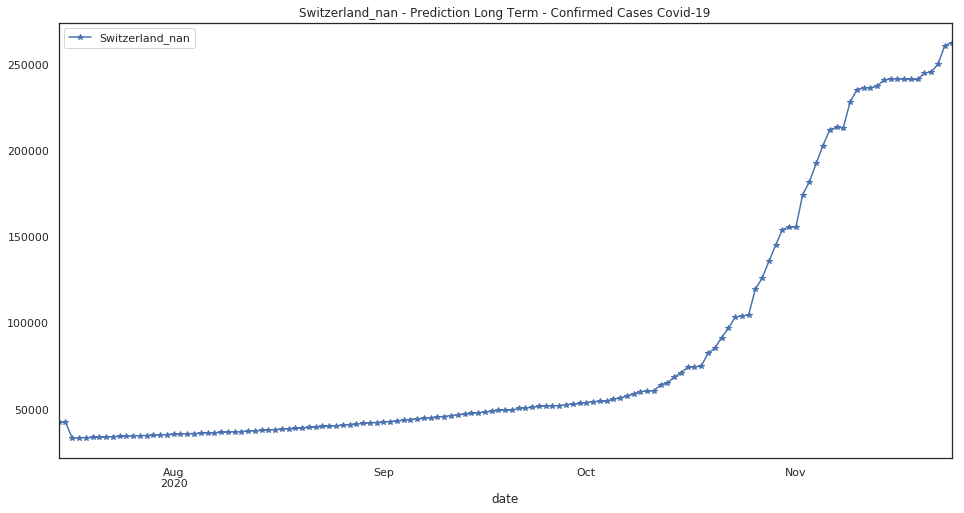

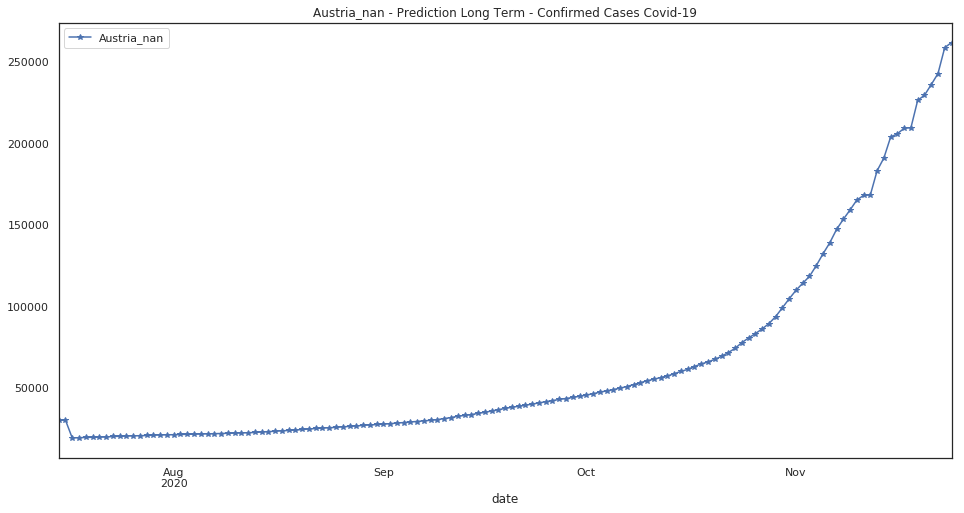

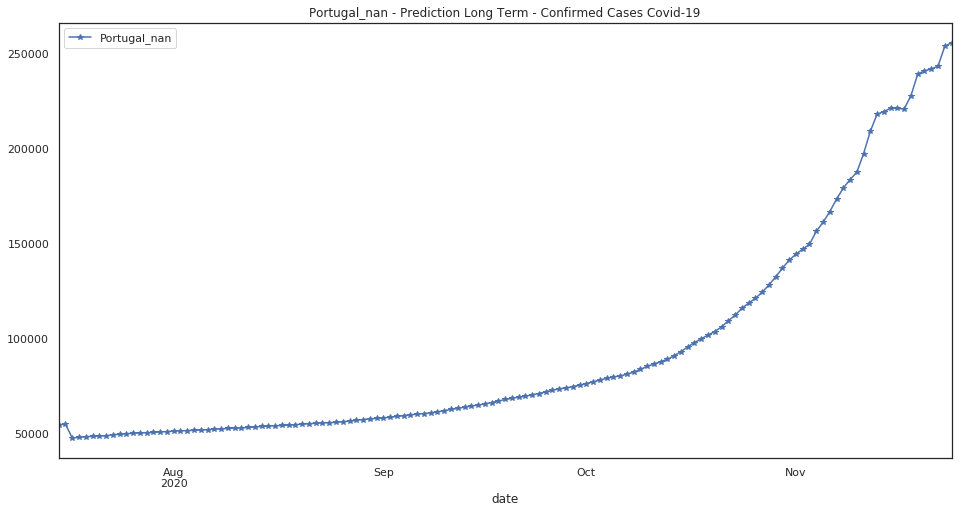

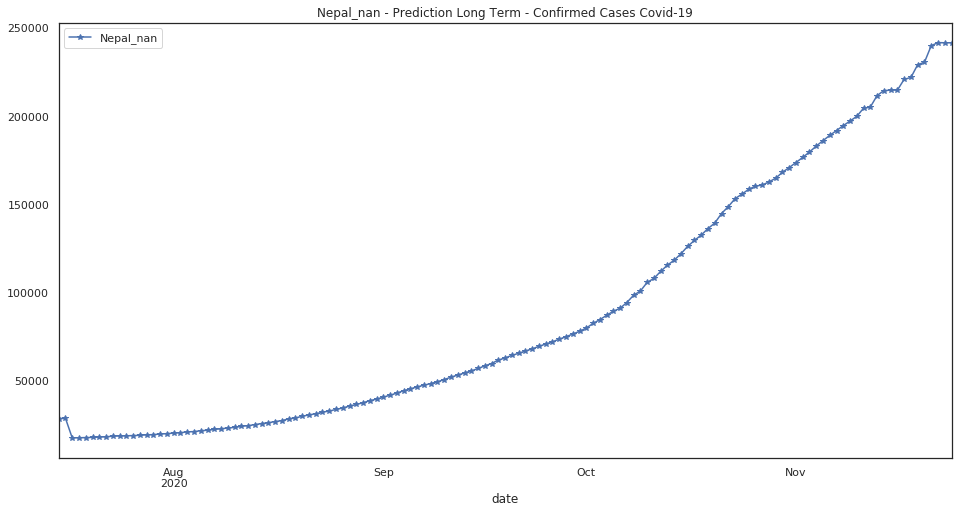

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

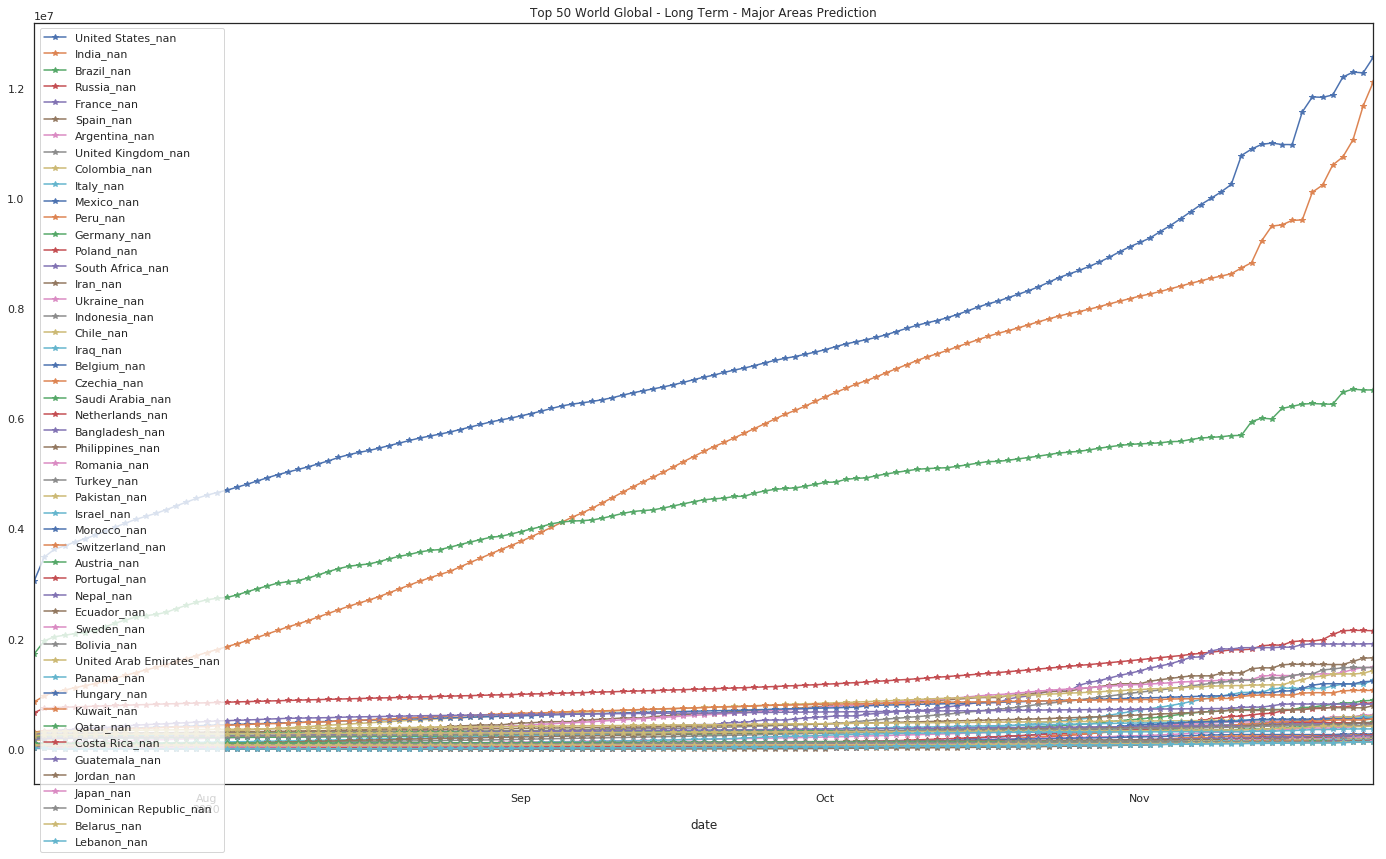

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

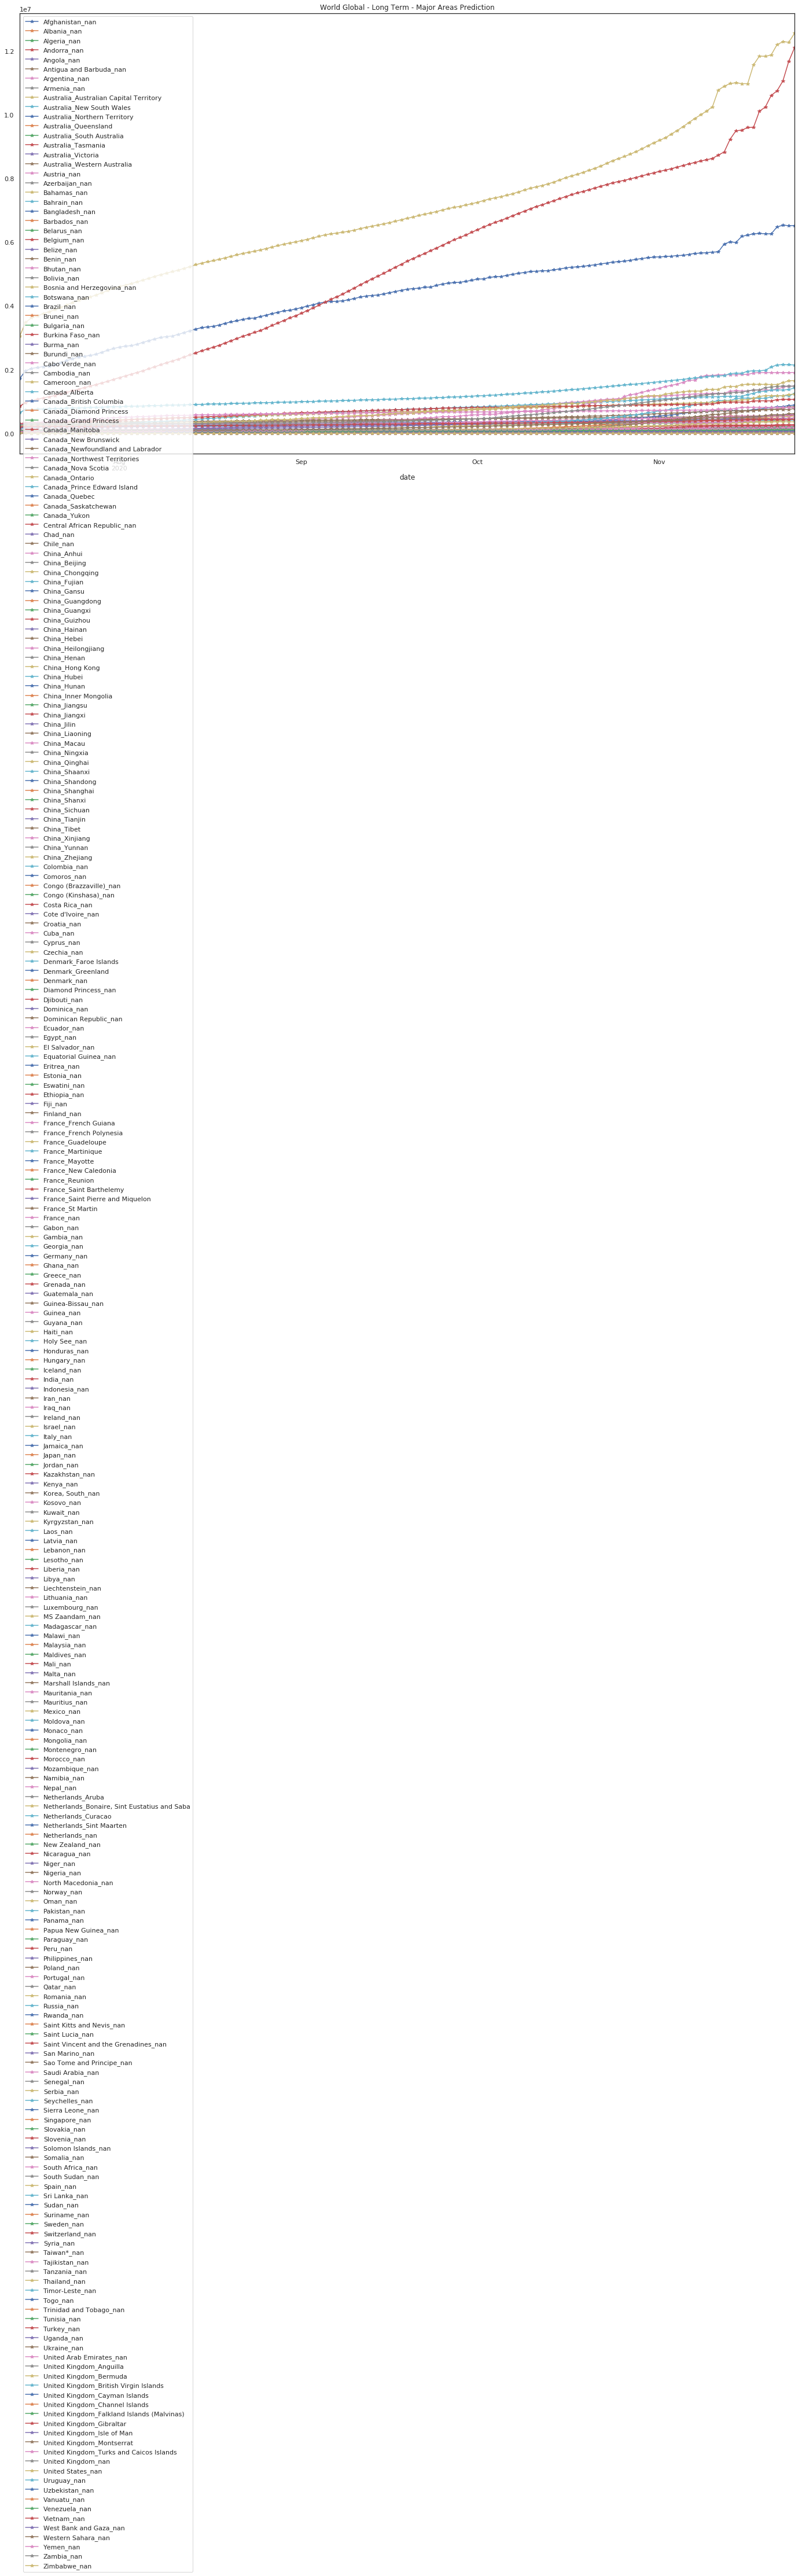

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38264.0       9326.0      43854.0       1124.0   
2020-08-30          38280.0       9455.0      44222.0       1193.0   
2020-08-31          38279.0       9550.0      44574.0       1239.0   
2020-09-01          38310.0       9600.0      44916.0       1176.0   
2020-09-02          38348.0       9775.0      45243.0       1198.0   
2020-09-03          38389.0       9849.0      45557.0       1199.0   
2020-09-04          38412.0       9976.0      45862.0       1279.0   
2020-09-05          38440.0      10104.0      46159.0       1215.0   
2020-09-06          38505.0      10244.0      46451.0       1271.0   
2020-09-07          38584.0      10378.0      46740.0       1311.0   
2020-09-08          38617.0      10533.0      47024.0       1261.0   
2020-09-09          38664.0      10695.0      47303.0       1352.0   
2020-09-10          38690.0      10848.0      47575.0       1301.0   
2020-09-11          38718.0      11006.0      47840.0       1396.0   
2020-09-12          38752.0      11168.0      48097.0       1344.0   
2020-09-13          38822.0      11336.0      48345.0       1408.0   
2020-09-14          38870.0      11502.0      48588.0       1489.0   
2020-09-15          38921.0      11660.0      48825.0       1438.0   
2020-09-16          38966.0      11824.0      49057.0       1565.0   
2020-09-17          38986.0      11965.0      49286.0       1483.0   
2020-09-18          39003.0      12102.0      49505.0       1616.0   
2020-09-19          39036.0      12256.0      49717.0       1564.0   
2020-09-20          39141.0      12383.0      49921.0       1641.0   
2020-09-21          39161.0      12529.0      50118.0       1743.0   
2020-09-22          39214.0      12675.0      50309.0       1681.0   
2020-09-23          39261.0      12816.0      50495.0       1821.0   
2020-09-24          39277.0      12955.0      50675.0       1753.0   
2020-09-25          39302.0      13066.0      50850.0       1883.0   
2020-09-26          39312.0      13187.0      51011.0       1836.0   
2020-09-27          39344.0      13307.0      51166.0       1884.0   
...                     ...          ...          ...          ...   
2020-10-26          41042.0      19413.0      56500.0       4111.0   
2020-10-27          41128.0      19705.0      56784.0       4325.0   
2020-10-28          41243.0      20015.0      57101.0       4410.0   
2020-10-29          41360.0      20278.0      57406.0       4517.0   
2020-10-30          41432.0      20614.0      57728.0       4567.0   
2020-10-31          41535.0      20840.0      58022.0       4665.0   
2020-11-01          41605.0      21201.0      58353.0       4756.0   
2020-11-02          41732.0      21472.0      58653.0       4825.0   
2020-11-03          41819.0      21851.0      59050.0       4888.0   
2020-11-04          41917.0      22221.0      59566.0       4910.0   
2020-11-05          42036.0      22638.0      60182.0       5045.0   
2020-11-06          42076.0      23116.0      60818.0       5135.0   
2020-11-07          42152.0      23585.0      61424.0       5135.0   
2020-11-08          42204.0      24099.0      62100.0       5319.0   
2020-11-09          42386.0      24631.0      62739.0       5383.0   
2020-11-10          42524.0      25188.0      63491.0       5437.0   
2020-11-11          42563.0      25294.0      63583.0       5477.0   
2020-11-12          42606.0      25509.0      63680.0       5477.0   
2020-11-13          42594.0      25466.0      63641.0       5556.0   
2020-11-14          42586.0      25859.0      63597.0       5556.0   
2020-11-15          42585.0      25798.0      63585.0       5556.0   
2020-11-16          43994.0      26365.0      63570.0       5772.0   
2020-11-17          44082.0      27457.0      63556.0       5904.0   
2020-11-18          44985.0      27741.0      63540.0       5904.0   
2020-11-19

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
245                             Timor-Leste_nan  -8.874217  125.727539   
246                                    Togo_nan   8.619500    0.824800   
247                     Trinidad and Tobago_nan  10.691800  -61.222500   
248                                 Tunisia_nan  33.886917    9.537499   
249                                  Turkey_nan  38.963700   35.243300   
250                           United States_nan  40.000000 -100.000000   
251                                  Uganda_nan   1.373333   32.290275   
252                                 Ukraine_nan  48.379400   31.165600   
253                    United Arab Emirates_nan  23.424076   53.847818   
254                     United Kingdom_Anguilla  18.220600  -63.068600   
255                      United Kingdom_Bermuda  32.307800  -64.750500   
256       United Kingdom_British Virgin Islands  18.420700  -64.640000   
257               United Kingdom_Cayman Islands  19.313300  -81.254600   
258              United Kingdom_Channel Islands  49.372300   -2.364400   
259  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
260                    United Kingdom_Gibraltar  36.140800   -5.353600   
261                  United Kingdom_Isle of Man  54.236100   -4.548100   
262                   United Kingdom_Montserrat  16.742498  -62.187366   
263     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
264                          United Kingdom_nan  55.378100   -3.436000   
265                                 Uruguay_nan -32.522800  -55.765800   
266                              Uzbekistan_nan  41.377491   64.585262   
267                                 Vanuatu_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      22               Belarus_nan  53.709800   27.953400   
4      23               Belgium_nan  50.833300    4.469936   
5      27               Bolivia_nan -16.290200  -63.588700   
6      30                Brazil_nan -14.235000  -51.925300   
7      57                 Chile_nan -35.675100  -71.543000   
8      91              Colombia_nan   4.570900  -74.297300   
9      95            Costa Rica_nan   9.748900  -83.753400   
10    100               Czechia_nan  49.817500   15.473000   
11    107    Dominican Republic_nan  18.735700  -70.162700   
12    108               Ecuador_nan  -1.831200  -78.183400   
13    128                France_nan  46.227600    2.213700   
14    133               Germany_nan  51.165691   10.451526   
15    137             Guatemala_nan  15.783500  -90.230800   
16    145               Hungary_nan  47.162500   19.503300   
17    147                 India_nan  20.593684   78.962880   
18    148             Indonesia_nan  -0.789300  113.921300   
19    149                  Iran_nan  32.427908   53.688046   
20    150                  Iraq_nan  33.223191   43.679291   
21    152                Israel_nan  31.046051   34.851612   
22    153                Israel_nan  31.046051   34.851612   
23    154                 Italy_nan  41.871940   12.567380   
24    156                 Japan_nan  36.204824  138.252924   
25    157                Jordan_nan  31.240000   36.510000   
26    158            Kazakhstan_nan  48.019600   66.923700   
27    162                Kuwait_nan  29.311660   47.481766   
28    166               Lebanon_nan  33.854700   35.862300   
29    167               Lebanon_nan  33.854700   35.862300   
30    184                Mexico_nan  23.634500 -102.552800   
31    189               Morocco_nan  31.791700   -7.092600   
32    192                 Nepal_nan  28.166700   84.250000   
33    197           Netherlands_nan  52.132600    5.291300   
34    205              Pakistan_nan  30.375300   69.345100   
35    206                Panama_nan   8.538000  -80.782100   
36    209                  Peru_nan  -9.190000  -75.015200   
37    210           Philippines_nan  12.879721  121.774017   
38    211                Poland_nan  51.919400   19.145100   
39    212              Portugal_nan  39.399900   -8.224500   
40    213                 Qatar_nan  25.354800   51.183900   
41    214               Romania_nan  45.943200   24.966800   
42    215                Russia_nan  61.524010  105.318756   
43    222          Saudi Arabia_nan  23.885942   45.079162   
44    232          South Africa_nan -30.559500   22.937500   
45    234                 Spain_nan  40.463667   -3.749220   
46    238                Sweden_nan  60.128161   18.643501   
47    239           Switzerland_nan  46.818200    8.227500   
48    249                Turkey_nan  38.963700   35.243300   
49    250         United States_nan  40.000000 -100.000000   
50    252               Ukraine_nan  48.379400   31.165600   
51    253  United Arab Emirates_nan  23.424076   53.847818   
52    264        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              110212.0             113380.0             117546.0   
1               30087.0              30188.0              19270.0   
2              182021.0             193590.0             197972.0   
3               70405.0              70561.0              65623.0   
4               68165.0              68484.0              63238.0   
5               58886.0              60574.0              54561.0   
6             1726441.0            1966748.0            2041469.0   
7              293173.0             321205.0             324947.0   
8              157266.0           

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()